<h1 style='font-size: 25px; color: crimson; font-family: Manilla Script; font-weight: 600; text-align: center'>Analysis of Variance (ANOVA) | Comparing Group Differences</h1>

---

<h2 style='font-family: Manilla Script; font-weight: 600; font-size: 20px; text-align: left'>1.0. Import Required Libraries</h2>

In [1]:
# Data Manipulation & Utilities
import numpy as np
import pandas as pd
import string
import math
import re

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical Analysis
import scipy.stats as stats
from scipy.stats import shapiro, levene, skew, kurtosis, gaussian_kde

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Configuration & Settings
import warnings
warnings.simplefilter("ignore")
pd.set_option('display.max_columns', 10)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

print("\n----- Libraries Loaded Successfully -----\n")


----- Libraries Loaded Successfully -----



<h2 style='font-family: Manilla Script; font-weight: 600; font-size: 20px; text-align: left'>2.0. Load and Inspect Dataset</h2>

In [2]:
filepath = "./datasets/Fertilizer Experiment.csv"
df = pd.read_csv(filepath)
display(df)

Fertilizer Light Exposure  Plant Height (cm)  Leaf Area (cm²)  \
0      Control       Full Sun              58.56           185.74   
1      Organic     Full Shade              46.70           138.80   
2      Control  Partial Shade              58.33           203.84   
3      Control     Full Shade              42.73           140.47   
4      Organic     Full Shade              41.82           129.78   
..         ...            ...                ...              ...   
115  Synthetic  Partial Shade              65.24           228.35   
116    Organic  Partial Shade              63.56           179.53   
117    Control  Partial Shade              62.75           180.21   
118    Control     Full Shade              39.60           144.32   
119  Synthetic     Full Shade              41.75           124.40   

     Chlorophyll Content (SPAD units)  Root Length (cm)  Biomass (g)  \
0                               46.52             24.32        11.99   
1                               34.69             17.66         8.67   
2                               40.82             27.00         9.50   
3                               29.07             19.59        10.35   
4                               34.73             19.78        10.55   
..                                ...               ...          ...   
115                             41.79             23.97        10.94   
116                             35.55             26.30        10.47   
117                             41.25             26.23        12.41   
118                             29.12             18.74         9.15   
119                             25.94             20.52         8.48   

     Flower Count (number)  Seed Yield (g)  Stomatal Conductance (mmol/m²/s)  
0                    19.54            6.69                            242.41  
1                    15.37            6.17                            233.66  
2                    16.39            5.41                            230.07  
3                    12.45            4.26                            154.25  
4                    15.14            4.64                            200.54  
..                     ...             ...                               ...  
115                  21.14            7.48                            254.78  
116                  16.11            6.17                            234.22  
117                  17.99            6.18                            278.97  
118                  13.72            4.46                            186.87  
119                  13.60            4.94                            180.23  

[120 rows x 10 columns]

<h1 style='font-family: Manilla Script; font-size: 25px; font-weight: 600'> 3.0: Data Overview & Quality Checks</h1>

<h4 style='font-family: Manilla Script; font-size: 20px; font-weight: 600'> 3.1: Columns Profiling</h4>

In [3]:
def column_summaries(df: pd.DataFrame) -> pd.DataFrame:
    summary_data = []
    for col_name in df.columns:
        col_dtype = df[col_name].dtype
        num_of_nulls = df[col_name].isnull().sum()
        num_of_non_nulls = df[col_name].notnull().sum()
        num_of_distinct_values = df[col_name].nunique()
        
        if num_of_distinct_values <= 10:
            distinct_values_counts = df[col_name].value_counts().to_dict()
        else:
            top_10_values_counts = df[col_name].value_counts().head(10).to_dict()
            distinct_values_counts = {k: v for k, v in sorted(top_10_values_counts.items(), key=lambda item: item[1], reverse=True)}

        summary_data.append({
            'col_name': col_name,
            'col_dtype': col_dtype,
            'num_of_nulls': num_of_nulls,
            'num_of_non_nulls': num_of_non_nulls,
            'num_of_distinct_values': num_of_distinct_values,
            'distinct_values_counts': distinct_values_counts
        })
    
    summary_df = pd.DataFrame(summary_data)
    return summary_df

summary_df = column_summaries(df)
display(summary_df)

col_name col_dtype  num_of_nulls  num_of_non_nulls  \
0                        Fertilizer    object             0               120   
1                    Light Exposure    object             0               120   
2                 Plant Height (cm)   float64             0               120   
3                   Leaf Area (cm²)   float64             0               120   
4  Chlorophyll Content (SPAD units)   float64             0               120   
5                  Root Length (cm)   float64             0               120   
6                       Biomass (g)   float64             0               120   
7             Flower Count (number)   float64             0               120   
8                    Seed Yield (g)   float64             0               120   
9  Stomatal Conductance (mmol/m²/s)   float64             0               120   

   num_of_distinct_values                             distinct_values_counts  
0                       3    {'Control': 41, 'Synthetic': 40, 'Organic': 39}  
1                       3  {'Full Shade': 44, 'Full Sun': 40, 'Partial Sh...  
2                     120  {58.56151388665052: 1, 46.696826238466286: 1, ...  
3                     120  {185.73856643236132: 1, 138.7980608962804: 1, ...  
4                     120  {46.5196207922374: 1, 34.69363266870892: 1, 40...  
5                     120  {24.31891050096943: 1, 17.6585349528435: 1, 26...  
6                     120  {11.994074041165357: 1, 8.667791843721698: 1, ...  
7                     120  {19.53594616947752: 1, 15.366158832462084: 1, ...  
8                     120  {6.687959618540082: 1, 6.165373569255893: 1, 5...  
9                     120  {242.41380014645895: 1, 233.65862057163417: 1,...

<h4 style='font-family: Manilla Script; font-size: 20px; font-weight: 600'> 3.2: Dataset Shape and Columns</h4>

In [4]:
nrows, ncols = df.shape
print(f"Dataset has {nrows} entries and {ncols} columns")

Dataset has 120 entries and 10 columns


In [5]:
for i, column in enumerate(df.columns.tolist()): print(f"{'-'*5} {i}: {column}")

----- 0: Fertilizer
----- 1: Light Exposure
----- 2: Plant Height (cm)
----- 3: Leaf Area (cm²)
----- 4: Chlorophyll Content (SPAD units)
----- 5: Root Length (cm)
----- 6: Biomass (g)
----- 7: Flower Count (number)
----- 8: Seed Yield (g)
----- 9: Stomatal Conductance (mmol/m²/s)


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 10 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Fertilizer                        120 non-null    object 
 1   Light Exposure                    120 non-null    object 
 2   Plant Height (cm)                 120 non-null    float64
 3   Leaf Area (cm²)                   120 non-null    float64
 4   Chlorophyll Content (SPAD units)  120 non-null    float64
 5   Root Length (cm)                  120 non-null    float64
 6   Biomass (g)                       120 non-null    float64
 7   Flower Count (number)             120 non-null    float64
 8   Seed Yield (g)                    120 non-null    float64
 9   Stomatal Conductance (mmol/m²/s)  120 non-null    float64
dtypes: float64(8), object(2)
memory usage: 9.5+ KB


<h4 style='font-family: Manilla Script; font-size: 20px; font-weight: 600'> 3.4: Checking Missing Values</h4>

In [7]:
def missig_values_info(df: pd.DataFrame) -> pd.DataFrame:
    miss = df.isna().sum().reset_index(name='Counts')
    miss['Proportions (%)'] = miss['Counts']/len(df)*100
    return miss
    
missig_values_info = missig_values_info(df)
display(missig_values_info)

index  Counts  Proportions (%)
0                        Fertilizer       0             0.00
1                    Light Exposure       0             0.00
2                 Plant Height (cm)       0             0.00
3                   Leaf Area (cm²)       0             0.00
4  Chlorophyll Content (SPAD units)       0             0.00
5                  Root Length (cm)       0             0.00
6                       Biomass (g)       0             0.00
7             Flower Count (number)       0             0.00
8                    Seed Yield (g)       0             0.00
9  Stomatal Conductance (mmol/m²/s)       0             0.00

<h4 style='font-family: Manilla Script; font-size: 20px; font-weight: 600'> 3.5: Exploring Invalid Dtypes Entries</h4>

In [8]:
def simplify_dtype(dtype: str):
    if dtype in (int, float, np.number): return 'Numeric'
    elif np.issubdtype(dtype, np.datetime64): return 'Datetime'
    elif dtype == str: return 'String'
    elif dtype == type(None): return 'Missing'
    else: return 'Other'

def analyze_column_dtypes(df: pd.DataFrame) -> pd.DataFrame:
    all_dtypes = {'Numeric', 'Datetime', 'String', 'Missing', 'Other'}
    results = pd.DataFrame(index=df.columns, columns=list(all_dtypes), dtype=object).fillna('-')
    
    for column in df.columns:
        dtypes = df[column].apply(lambda x: simplify_dtype(type(x))).value_counts()
        percentages = (dtypes / len(df)) * 100
        for dtype, percent in percentages.items():
            if percent > 0:
                results.at[column, dtype] = f'{percent:.2f}%'  # Add % sign and format to 2 decimal places
            else:
                results.at[column, dtype] = '-'  # Add dash for 0%
    return results

results = analyze_column_dtypes(df)
display(results)

Datetime  Numeric   String Missing Other
Fertilizer                              -        -  100.00%       -     -
Light Exposure                          -        -  100.00%       -     -
Plant Height (cm)                       -  100.00%        -       -     -
Leaf Area (cm²)                         -  100.00%        -       -     -
Chlorophyll Content (SPAD units)        -  100.00%        -       -     -
Root Length (cm)                        -  100.00%        -       -     -
Biomass (g)                             -  100.00%        -       -     -
Flower Count (number)                   -  100.00%        -       -     -
Seed Yield (g)                          -  100.00%        -       -     -
Stomatal Conductance (mmol/m²/s)        -  100.00%        -       -     -

<h4 style='font-family: Manilla Script; font-size: 20px; font-weight: 600'> 3.6: Handling Rare Categories if Exists</h4>

In [322]:
def fit_transform(
    df: pd.DataFrame, 
    cat_cols: list, 
    rare_label: str = "Rare", 
    threshold: float = 0.05
) -> pd.DataFrame:
    
    df_transformed = df.copy()
    summary_records = []

    for col in cat_cols:
        value_counts = df[col].value_counts(dropna=False)
        total = len(df)

        if self.threshold < 1: rare_mask = (value_counts / total) < self.threshold
        else: rare_mask = value_counts < self.threshold
        rare_categories = value_counts[rare_mask].index.tolist()

        df_transformed[col] = df_transformed[col].apply(lambda x: self.rare_label if x in rare_categories else x)
        summary_records.append({
            "column": col,
            "unique_before": len(value_counts),
            "unique_after": df_transformed[col].nunique(),
            "rare_categories": rare_categories
        })

    summary_df = pd.DataFrame(summary_records)
    return df_transformed, summary_df


<h1 style='font-family: Manilla Script; font-size: 25px;  font-weight: 600''>4.0: Outliers Detection and Handling</h1>

<h4 style='font-family: Manilla Script; font-size: 20px;  font-weight: 600'>4.1: Interquartile Range (IQR) Method</h4>

In [323]:
def interquartile_range_outlier(df: pd.DataFrame, numeric_cols: list =None, group: str = None) -> pd.DataFrame:
    if group: grouped = df.groupby(group)
    else: grouped = [(None, df)]
        
    if numeric_cols is None:
        numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
        if group in numeric_cols:
            numeric_cols.remove(group)
            

    results = []
    for group_name, group_df in grouped:    
        for col in numeric_cols:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR
            count = df[(df[col] < lower) | (df[col] > upper)].shape[0]

            results.append({
                f'{group}': group_name,
                'Variable': col,
                'Counts': count,
                'Total Observations': len(group_df),
                'Proportion (%)': round((count / len(group_df)) * 100, 2),
            })
    results = pd.DataFrame(results)
    if group is None: results = results.drop(columns=[f'{group}'])        
    return results

<h5 style='font-family: Manilla Script; font-size: 18px;  font-weight: 600'>4.1.1: Interquartile Range (IQR) Method at Overall</h5>

In [324]:
results = interquartile_range_outlier(df)
display(results)

Variable  Counts  Total Observations  \
0                 Plant Height (cm)       0                 120   
1                   Leaf Area (cm²)       1                 120   
2  Chlorophyll Content (SPAD units)       1                 120   
3                  Root Length (cm)       1                 120   
4                       Biomass (g)       0                 120   
5             Flower Count (number)       0                 120   
6                    Seed Yield (g)       1                 120   
7  Stomatal Conductance (mmol/m²/s)       0                 120   

   Proportion (%)  
0            0.00  
1            0.83  
2            0.83  
3            0.83  
4            0.00  
5            0.00  
6            0.83  
7            0.00

<h5 style='font-family: Manilla Script; font-size: 18px;  font-weight: 600'>4.1.2: Interquartile Range (IQR) Method at Group Level</h5>

In [325]:
results = get_outlier_counts(df, group='Fertilizer')
display(results)

Fertilizer                          Variable  Counts  Total Observations  \
0     Control                 Plant Height (cm)       0                  41   
1     Control                   Leaf Area (cm²)       1                  41   
2     Control  Chlorophyll Content (SPAD units)       1                  41   
3     Control                  Root Length (cm)       1                  41   
4     Control                       Biomass (g)       0                  41   
5     Control             Flower Count (number)       0                  41   
6     Control                    Seed Yield (g)       1                  41   
7     Control  Stomatal Conductance (mmol/m²/s)       0                  41   
8     Organic                 Plant Height (cm)       0                  39   
9     Organic                   Leaf Area (cm²)       1                  39   
10    Organic  Chlorophyll Content (SPAD units)       1                  39   
11    Organic                  Root Length (cm)       1                  39   
12    Organic                       Biomass (g)       0                  39   
13    Organic             Flower Count (number)       0                  39   
14    Organic                    Seed Yield (g)       1                  39   
15    Organic  Stomatal Conductance (mmol/m²/s)       0                  39   
16  Synthetic                 Plant Height (cm)       0                  40   
17  Synthetic                   Leaf Area (cm²)       1                  40   
18  Synthetic  Chlorophyll Content (SPAD units)       1                  40   
19  Synthetic                  Root Length (cm)       1                  40   
20  Synthetic                       Biomass (g)       0                  40   
21  Synthetic             Flower Count (number)       0                  40   
22  Synthetic                    Seed Yield (g)       1                  40   
23  Synthetic  Stomatal Conductance (mmol/m²/s)       0                  40   

    Proportion (%)  
0             0.00  
1             2.44  
2             2.44  
3             2.44  
4             0.00  
5             0.00  
6             2.44  
7             0.00  
8             0.00  
9             2.56  
10            2.56  
11            2.56  
12            0.00  
13            0.00  
14            2.56  
15            0.00  
16            0.00  
17            2.50  
18            2.50  
19            2.50  
20            0.00  
21            0.00  
22            2.50  
23            0.00

In [326]:
results = get_outlier_counts(df, group='Light Exposure')
display(results)

Light Exposure                          Variable  Counts  \
0      Full Shade                 Plant Height (cm)       0   
1      Full Shade                   Leaf Area (cm²)       1   
2      Full Shade  Chlorophyll Content (SPAD units)       1   
3      Full Shade                  Root Length (cm)       1   
4      Full Shade                       Biomass (g)       0   
5      Full Shade             Flower Count (number)       0   
6      Full Shade                    Seed Yield (g)       1   
7      Full Shade  Stomatal Conductance (mmol/m²/s)       0   
8        Full Sun                 Plant Height (cm)       0   
9        Full Sun                   Leaf Area (cm²)       1   
10       Full Sun  Chlorophyll Content (SPAD units)       1   
11       Full Sun                  Root Length (cm)       1   
12       Full Sun                       Biomass (g)       0   
13       Full Sun             Flower Count (number)       0   
14       Full Sun                    Seed Yield (g)       1   
15       Full Sun  Stomatal Conductance (mmol/m²/s)       0   
16  Partial Shade                 Plant Height (cm)       0   
17  Partial Shade                   Leaf Area (cm²)       1   
18  Partial Shade  Chlorophyll Content (SPAD units)       1   
19  Partial Shade                  Root Length (cm)       1   
20  Partial Shade                       Biomass (g)       0   
21  Partial Shade             Flower Count (number)       0   
22  Partial Shade                    Seed Yield (g)       1   
23  Partial Shade  Stomatal Conductance (mmol/m²/s)       0   

    Total Observations  Proportion (%)  
0                   44            0.00  
1                   44            2.27  
2                   44            2.27  
3                   44            2.27  
4                   44            0.00  
5                   44            0.00  
6                   44            2.27  
7                   44            0.00  
8                   40            0.00  
9                   40            2.50  
10                  40            2.50  
11                  40            2.50  
12                  40            0.00  
13                  40            0.00  
14                  40            2.50  
15                  40            0.00  
16                  36            0.00  
17                  36            2.78  
18                  36            2.78  
19                  36            2.78  
20                  36            0.00  
21                  36            0.00  
22                  36            2.78  
23                  36            0.00

<h4 style='font-family: Manilla Script; font-size: 20px;  font-weight: 600'>4.2: Outlier Detection Through Boxplots</h4>

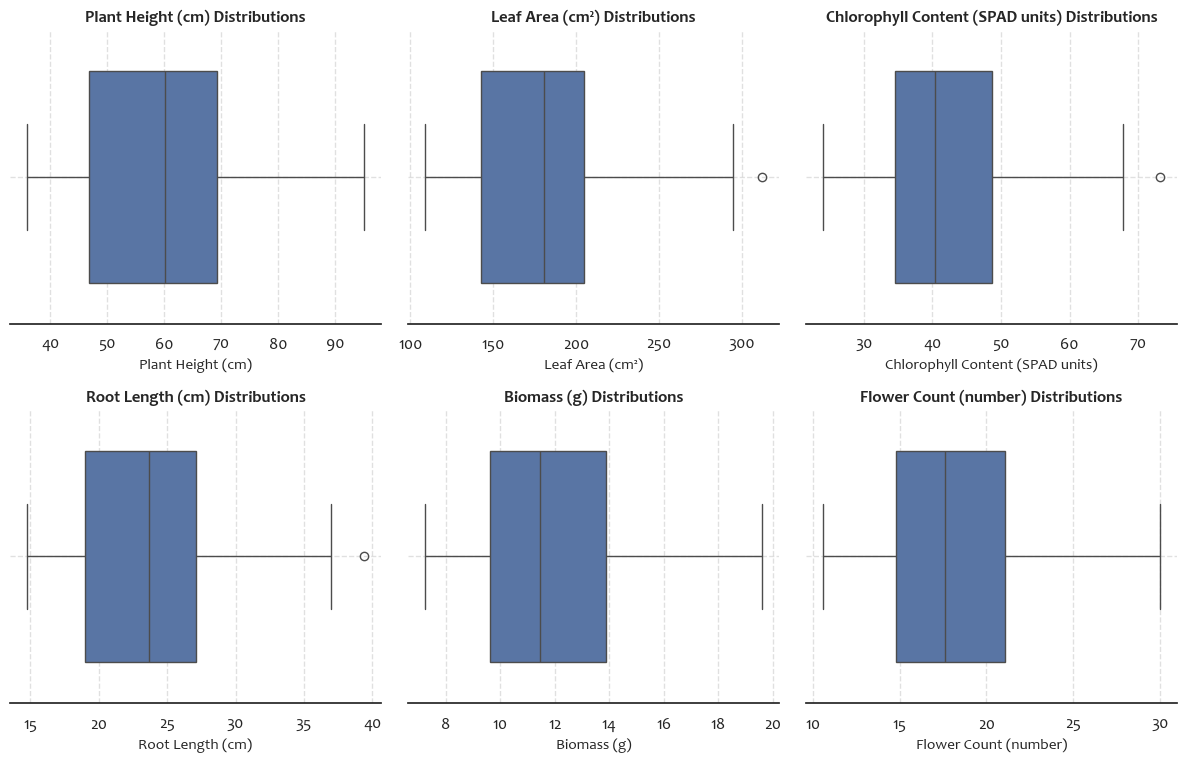

In [327]:
def visualize_boxplots(df: pd.DataFrame, group: str = None, num_cols: list=None):
    if num_cols is None:
        num_cols = df.select_dtypes(include=['number']).columns.tolist()[:6]
        if group in num_cols:
            num_cols.remove(group)
        
    num_variables = len(num_cols)
    rows = math.ceil(num_variables / 3)
    cols = min(num_variables, 3)
    
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
    plt.rcParams.update({'font.family': 'Calibri', 'font.style': 'normal', 'font.size': 11 })
    axes = axes.flatten() if num_variables > 1 else [axes]
    
    for idx, column in enumerate(num_cols):
        if group is not None:
            sns.boxplot(data=df, x=df[column], fill=True, gap=0.1, ax=axes[idx], hue=group, palette='RdBu_r')  
            axes[idx].set_title(f"{column} Across {group}", fontsize=12, fontweight='bold', fontfamily='Candara')
            axes[idx].legend(frameon=False)
        else :
            sns.boxplot(data=df, x=df[column], fill=True, gap=0.1, ax=axes[idx],)
            axes[idx].set_title(f"{column} Distributions", fontsize=12, fontweight='bold', fontfamily='Candara')
            
        axes[idx].spines[['right', 'left', 'top']].set_visible(False)
        axes[idx].set_xlabel(column, fontsize=11)
        axes[idx].grid(linestyle='--', alpha=0.6)
    
    for idx in range(num_variables, len(axes)): fig.delaxes(axes[idx])
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()
    
    return fig


fig = visualize_boxplots(df)

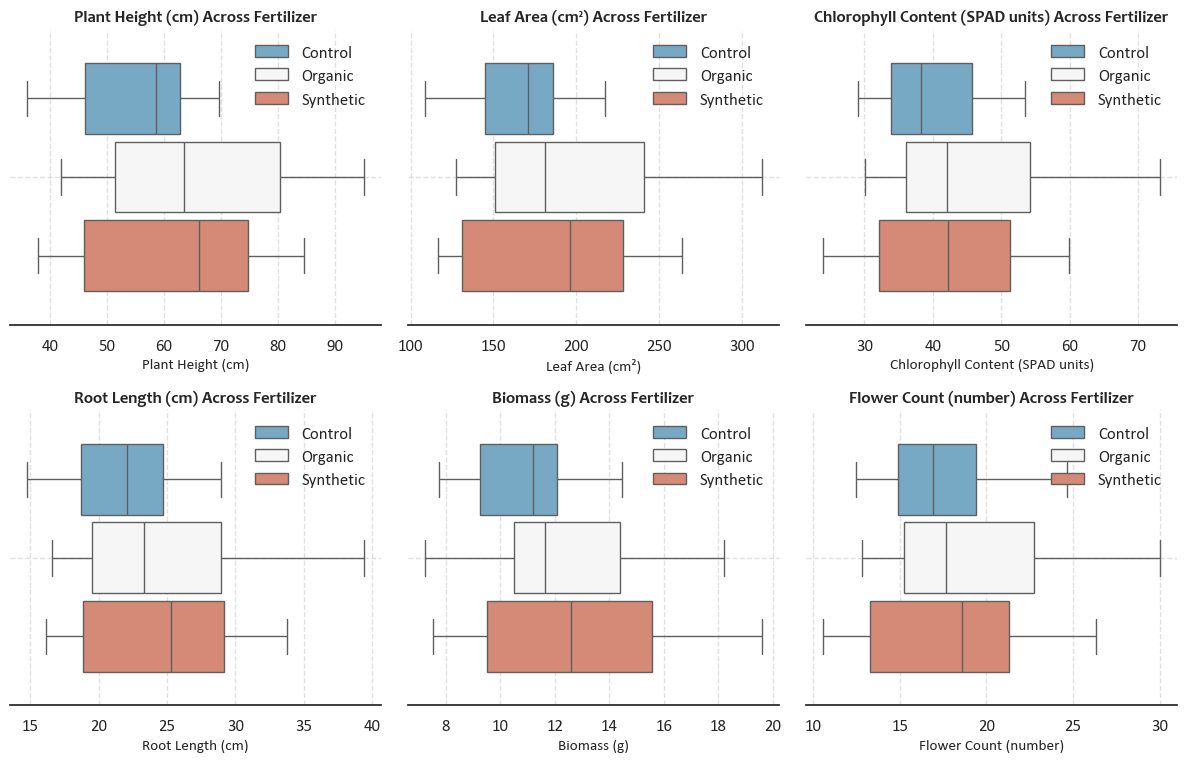

In [328]:
fig = visualize_boxplots(df, group='Fertilizer')

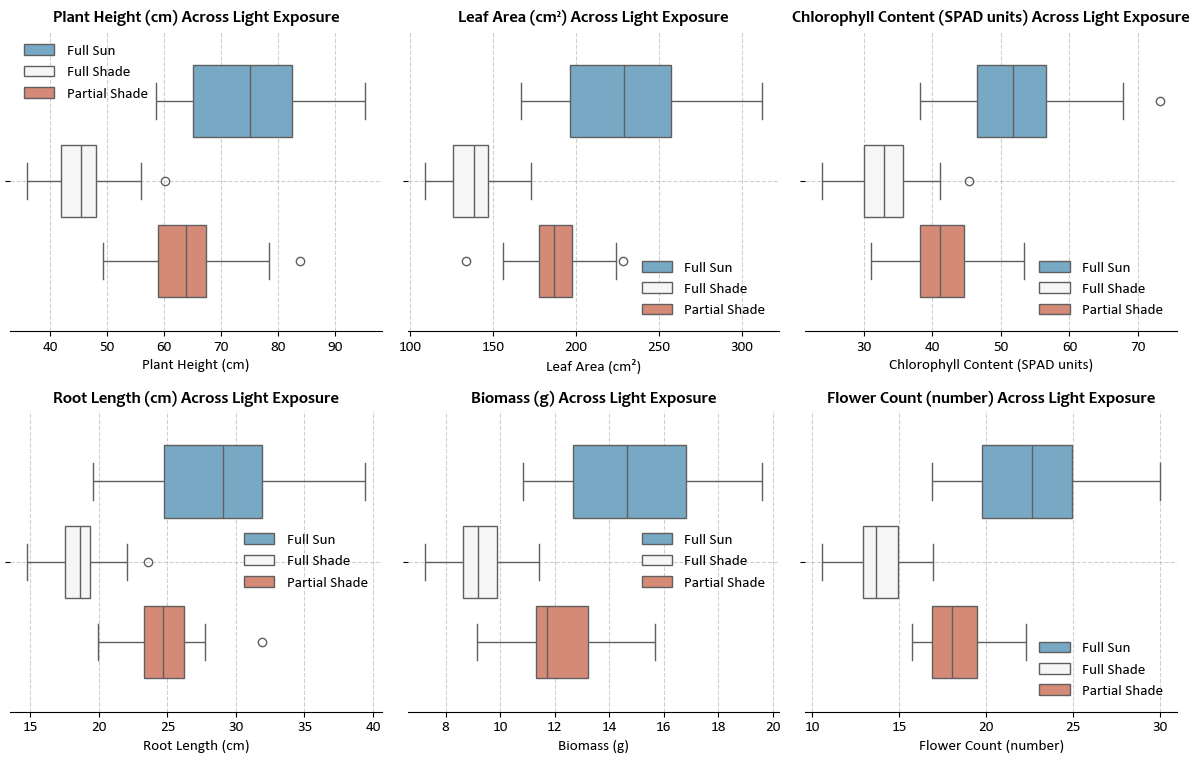

In [46]:
fig = visualize_boxplots(df, group='Light Exposure')

<h4 style='font-family: Manilla Script; font-size: 20px;  font-weight: 600'>4.3: Normalizing Outliers</h4>

In [330]:
import pandas as pd

def capping_outlier_iqr(df: pd.DataFrame, group_col: str = None, num_cols: list = None, k: float = 1.5) -> pd.DataFrame:
    out = df.copy()
    if num_cols is None:
        num_cols = out.select_dtypes(include='number').columns.tolist()
        if group_col and group_col in num_cols:
            num_cols.remove(group_col)
    
    if group_col: grouped = out.groupby(group_col)
    else: grouped = [(None, out)]
    
    for grp_name, grp_df in grouped:
        for col in num_cols:
            if col not in grp_df.columns:
                continue
            q1, q3 = grp_df[col].quantile([0.25, 0.75])
            iqr = q3 - q1
            if iqr == 0 or pd.isna(iqr):
                continue
            lo, hi = q1 - k * iqr, q3 + k * iqr
            mask = (out[group_col] == grp_name) if group_col else slice(None)
            out.loc[mask, col] = out.loc[mask, col].clip(lower=lo, upper=hi)
    
    return out

cleaned_df = df.copy()
cleaned_df = capping_outlier_iqr(cleaned_df)
results = interquartile_range_outlier(cleaned_df)
display(results)

Variable  Counts  Total Observations  \
0                 Plant Height (cm)       0                 120   
1                   Leaf Area (cm²)       0                 120   
2  Chlorophyll Content (SPAD units)       0                 120   
3                  Root Length (cm)       0                 120   
4                       Biomass (g)       0                 120   
5             Flower Count (number)       0                 120   
6                    Seed Yield (g)       0                 120   
7  Stomatal Conductance (mmol/m²/s)       0                 120   

   Proportion (%)  
0            0.00  
1            0.00  
2            0.00  
3            0.00  
4            0.00  
5            0.00  
6            0.00  
7            0.00

<h1 style='font-family: Manilla Script; font-size: 25px;  font-weight: 600''>5.0: Statistic Description of The Datasets</h1>

Let's take a moment to quickly explore some essential statistics of our dataset. By using the `describe()` function in pandas, we can generate a summary of key metrics for each numerical column in the dataset. This gives us a bird's-eye view of the data, helping us understand the general distribution and characteristics of the values.

In [331]:
summary_stats = df.describe().T.reset_index(names='Index')
summary_stats

Index  count   mean   std    min    25%    50%  \
0                 Plant Height (cm) 120.00  60.58 14.93  35.89  46.82  60.18   
1                   Leaf Area (cm²) 120.00 181.90 45.93 108.65 142.32 180.71   
2  Chlorophyll Content (SPAD units) 120.00  42.03  9.86  23.99  34.58  40.37   
3                  Root Length (cm) 120.00  23.86  5.44  14.75  19.01  23.64   
4                       Biomass (g) 120.00  11.97  2.89   7.23   9.63  11.45   
5             Flower Count (number) 120.00  18.18  4.43  10.57  14.80  17.64   
6                    Seed Yield (g) 120.00   6.16  1.49   3.86   4.94   6.14   
7  Stomatal Conductance (mmol/m²/s) 120.00 241.68 55.74 148.69 192.69 240.25   

     75%    max  
0  69.33  95.14  
1 205.00 312.30  
2  48.66  73.21  
3  27.07  39.40  
4  13.87  19.61  
5  21.08  30.03  
6   7.03  10.16  
7 276.74 383.45

In [332]:
summary_stats = df.describe(include='all').T.reset_index(names='index')
summary_stats

index  count unique         top freq  ...  \
0                        Fertilizer    120      3     Control   41  ...   
1                    Light Exposure    120      3  Full Shade   44  ...   
2                 Plant Height (cm) 120.00    NaN         NaN  NaN  ...   
3                   Leaf Area (cm²) 120.00    NaN         NaN  NaN  ...   
4  Chlorophyll Content (SPAD units) 120.00    NaN         NaN  NaN  ...   
5                  Root Length (cm) 120.00    NaN         NaN  NaN  ...   
6                       Biomass (g) 120.00    NaN         NaN  NaN  ...   
7             Flower Count (number) 120.00    NaN         NaN  NaN  ...   
8                    Seed Yield (g) 120.00    NaN         NaN  NaN  ...   
9  Stomatal Conductance (mmol/m²/s) 120.00    NaN         NaN  NaN  ...   

     min    25%    50%    75%    max  
0    NaN    NaN    NaN    NaN    NaN  
1    NaN    NaN    NaN    NaN    NaN  
2  35.89  46.82  60.18  69.33  95.14  
3 108.65 142.32 180.71 205.00 312.30  
4  23.99  34.58  40.37  48.66  73.21  
5  14.75  19.01  23.64  27.07  39.40  
6   7.23   9.63  11.45  13.87  19.61  
7  10.57  14.80  17.64  21.08  30.03  
8   3.86   4.94   6.14   7.03  10.16  
9 148.69 192.69 240.25 276.74 383.45  

[10 rows x 12 columns]

<h4 style='font-family: Manilla Script; font-size: 20px;  font-weight: 600'>5.1: Continuous Variables Summary Statics</h4>

In [333]:
def summary_statistics(df: pd.DataFrame, group: str=None) -> pd.DataFrame:
    if group: grouped = df.groupby(group)
    else: grouped = [(None, df)]

    results = []
    for group_name, group_df in grouped:
        for col in group_df.select_dtypes(include=[np.number]).columns:
            counts = len(group_df[col])
            mean = group_df[col].mean()
            median = group_df[col].median()
            mode = group_df[col].mode().iloc[0] if not group_df[col].mode().empty else np.nan
            std_dev = group_df[col].std()
            variance = group_df[col].var()
            value_range = group_df[col].max() - group_df[col].min()
            skewness_val = skew(group_df[col], nan_policy='omit')  # Skewness
            kurtosis_val = kurtosis(group_df[col], nan_policy='omit')  # Kurtosis
    
    
            results.append({
                f'{group}': group_name,
                'Variables': col,
                'Sample Size': counts,
                'Mean': mean,
                'Median': median,
                'Mode': mode,
                'Standard Deviation': std_dev,
                'Variance': variance,
                'Range': value_range,
                'Skewness': skewness_val,
                'Kurtosis': kurtosis_val
            })

    
    results = pd.DataFrame(results)
    if group is None: results = results.drop(columns=[f'{group}'])
    return results

results = summary_statistics(df)
results

Variables  Sample Size   Mean  Median   Mode  \
0                 Plant Height (cm)          120  60.58   60.18  35.89   
1                   Leaf Area (cm²)          120 181.90  180.71 108.65   
2  Chlorophyll Content (SPAD units)          120  42.03   40.37  23.99   
3                  Root Length (cm)          120  23.86   23.64  14.75   
4                       Biomass (g)          120  11.97   11.45   7.23   
5             Flower Count (number)          120  18.18   17.64  10.57   
6                    Seed Yield (g)          120   6.16    6.14   3.86   
7  Stomatal Conductance (mmol/m²/s)          120 241.68  240.25 148.69   

   Standard Deviation  Variance  Range  Skewness  Kurtosis  
0               14.93    222.90  59.26      0.37     -0.73  
1               45.93   2109.99 203.66      0.56     -0.32  
2                9.86     97.29  49.22      0.59     -0.17  
3                5.44     29.55  24.65      0.62     -0.22  
4                2.89      8.33  12.38      0.60     -0.48  
5                4.43     19.60  19.45      0.62     -0.26  
6                1.49      2.21   6.30      0.50     -0.51  
7               55.74   3106.48 234.76      0.41     -0.58

<h4 style='font-family: Manilla Script; font-size: 20px;  font-weight: 600'>5.2: Grouped Summary Statics I</h4>

In [334]:
results = summary_statistics(df, group='Light Exposure')
results

Light Exposure                         Variables  Sample Size   Mean  \
0      Full Shade                 Plant Height (cm)           44  45.39   
1      Full Shade                   Leaf Area (cm²)           44 136.79   
2      Full Shade  Chlorophyll Content (SPAD units)           44  33.02   
3      Full Shade                  Root Length (cm)           44  18.52   
4      Full Shade                       Biomass (g)           44   9.29   
5      Full Shade             Flower Count (number)           44  13.86   
6      Full Shade                    Seed Yield (g)           44   4.68   
7      Full Shade  Stomatal Conductance (mmol/m²/s)           44 187.67   
8        Full Sun                 Plant Height (cm)           40  74.39   
9        Full Sun                   Leaf Area (cm²)           40 227.23   
10       Full Sun  Chlorophyll Content (SPAD units)           40  52.17   
11       Full Sun                  Root Length (cm)           40  28.84   
12       Full Sun                       Biomass (g)           40  14.77   
13       Full Sun             Flower Count (number)           40  22.76   
14       Full Sun                    Seed Yield (g)           40   7.66   
15       Full Sun  Stomatal Conductance (mmol/m²/s)           40 294.33   
16  Partial Shade                 Plant Height (cm)           36  63.78   
17  Partial Shade                   Leaf Area (cm²)           36 186.68   
18  Partial Shade  Chlorophyll Content (SPAD units)           36  41.76   
19  Partial Shade                  Root Length (cm)           36  24.84   
20  Partial Shade                       Biomass (g)           36  12.12   
21  Partial Shade             Flower Count (number)           36  18.39   
22  Partial Shade                    Seed Yield (g)           36   6.32   
23  Partial Shade  Stomatal Conductance (mmol/m²/s)           36 249.19   

    Median  ...  Standard Deviation  Variance  Range  Skewness  Kurtosis  
0    45.32  ...                5.17     26.72  24.23      0.59      0.25  
1   138.31  ...               15.40    237.19  64.09      0.29     -0.55  
2    32.93  ...                4.12     16.96  21.33      0.48      0.69  
3    18.61  ...                1.69      2.87   8.83      0.54      0.92  
4     9.20  ...                1.04      1.07   4.18      0.14     -0.49  
5    13.68  ...                1.39      1.93   6.38      0.14     -0.30  
6     4.60  ...                0.47      0.22   2.30      0.63      0.39  
7   185.18  ...               21.84    476.79  84.97      0.31     -0.56  
8    75.03  ...               11.43    130.55  36.58      0.14     -1.23  
9   229.09  ...               37.64   1416.80 145.54      0.21     -0.93  
10   51.76  ...                7.47     55.86  34.97      0.45      0.28  
11   29.07  ...                4.90     24.02  19.83      0.13     -0.73  
12   14.65  ...                2.41      5.79   8.77      0.05     -1.23  
13   22.63  ...                3.50     12.23  13.15      0.27     -0.73  
14    7.66  ...                1.13      1.27   4.66      0.25     -0.79  
15  295.61  ...               44.43   1974.05 186.47     -0.01     -0.70  
16   63.78  ...                7.82     61.12  34.61      0.25      0.14  
17  186.50  ...               19.31    372.78  94.53     -0.23      0.52  
18   41.08  ...                5.31     28.19  22.25      0.56     -0.17  
19   24.68  ...                2.25      5.05  11.97      0.53      1.21  
20   11.70  ...                1.60      2.56   6.54      0.39     -0.28  
21   18.07  ...                1.79      3.19   6.59      0.48     -0.85  
22    6.23  ...                0.69      0.47   2.99      0.26     -0.21  
23  250.51  ...               29.72    883.02 145.72     -0.09      0.77  

[24 rows x 11 columns]

In [335]:
results = summary_statistics(df, group='Fertilizer')
results

Fertilizer                         Variables  Sample Size   Mean  Median  \
0     Control                 Plant Height (cm)           41  54.55   58.56   
1     Control                   Leaf Area (cm²)           41 167.76  170.86   
2     Control  Chlorophyll Content (SPAD units)           41  39.76   38.28   
3     Control                  Root Length (cm)           41  21.97   22.09   
4     Control                       Biomass (g)           41  10.91   11.20   
5     Control             Flower Count (number)           41  17.13   16.90   
6     Control                    Seed Yield (g)           41   5.68    5.98   
7     Control  Stomatal Conductance (mmol/m²/s)           41 221.38  228.13   
8     Organic                 Plant Height (cm)           39  65.61   63.56   
9     Organic                   Leaf Area (cm²)           39 194.26  181.28   
10    Organic  Chlorophyll Content (SPAD units)           39  44.85   42.08   
11    Organic                  Root Length (cm)           39  25.15   23.35   
12    Organic                       Biomass (g)           39  12.56   11.65   
13    Organic             Flower Count (number)           39  19.36   17.64   
14    Organic                    Seed Yield (g)           39   6.41    6.17   
15    Organic  Stomatal Conductance (mmol/m²/s)           39 256.74  234.22   
16  Synthetic                 Plant Height (cm)           40  61.84   66.14   
17  Synthetic                   Leaf Area (cm²)           40 184.36  196.22   
18  Synthetic  Chlorophyll Content (SPAD units)           40  41.60   42.26   
19  Synthetic                  Root Length (cm)           40  24.53   25.31   
20  Synthetic                       Biomass (g)           40  12.48   12.61   
21  Synthetic             Flower Count (number)           40  18.12   18.58   
22  Synthetic                    Seed Yield (g)           40   6.43    6.67   
23  Synthetic  Stomatal Conductance (mmol/m²/s)           40 247.81  253.33   

    ...  Standard Deviation  Variance  Range  Skewness  Kurtosis  
0   ...               10.09    101.89  33.75     -0.35     -1.21  
1   ...               27.69    766.72 108.94     -0.33     -0.72  
2   ...                7.17     51.34  24.42      0.35     -1.00  
3   ...                3.74     13.98  14.22     -0.12     -1.06  
4   ...                1.68      2.81   6.73      0.10     -0.95  
5   ...                3.09      9.54  12.18      0.26     -0.62  
6   ...                1.08      1.18   4.02      0.09     -0.92  
7   ...               42.70   1823.25 156.23     -0.03     -1.06  
8   ...               16.83    283.18  53.32      0.32     -1.24  
9   ...               52.27   2731.82 185.13      0.69     -0.70  
10  ...               11.04    121.86  43.14      0.79     -0.35  
11  ...                6.45     41.66  22.82      0.69     -0.68  
12  ...                2.93      8.59  10.97      0.49     -0.76  
13  ...                5.09     25.92  17.18      0.73     -0.70  
14  ...                1.65      2.71   6.30      0.63     -0.60  
15  ...               56.56   3198.87 225.87      0.52     -0.69  
16  ...               15.32    234.56  46.86     -0.11     -1.47  
17  ...               51.19   2620.91 147.57     -0.05     -1.52  
18  ...               10.58    111.89  35.85      0.04     -1.31  
19  ...                5.42     29.34  17.63     -0.02     -1.38  
20  ...                3.52     12.38  12.09      0.18     -1.28  
21  ...                4.71     22.21  15.76      0.08     -1.29  
22  ...                1.59      2.52   5.43      0.04     -1.23  
23  ...               61.59   3793.21 203.23      0.16     -1.20  

[24 rows x 11 columns]

<h4 style='font-family: Manilla Script; font-size: 20px;  font-weight: 600'>5.3: Grouped Summary Statics II</h4>

In [336]:
def grouped_statistics(df: pd.DataFrame, group: str, variables: list=None) -> pd.DataFrame:
    if variables is None:
        variables = df.select_dtypes(include=np.number).columns.tolist()
        if group in variables:
            variables.remove(group)
    
    new_df = df.drop(columns=[group])
    grand_mean = new_df[variables].mean()
    sem = new_df[variables].sem()
    cv = new_df[variables].std() / new_df[variables].mean() * 100
    grouped = df.groupby(group)[variables].agg(['mean', 'sem']).reset_index()
    
    summary_df = pd.DataFrame()
    for variable in variables:
        summary_df[variable] = grouped.apply(
            lambda x: f"{x[(variable, 'mean')]:.2f} ± {x[(variable, 'sem')]:.2f}", axis=1
        )
    
    summary_df.insert(0, group, grouped[group])
    grand_mean_row = ['Grand Mean'] + grand_mean.tolist()
    sem_row = ['SEM'] + sem.tolist()
    cv_row = ['%CV'] + cv.tolist()
    
    summary_df.loc[len(summary_df)] = grand_mean_row
    summary_df.loc[len(summary_df)] = sem_row
    summary_df.loc[len(summary_df)] = cv_row
    
    return summary_df

results = grouped_statistics(df, group='Fertilizer')
results.T

0              1              2  \
Fertilizer                              Control        Organic      Synthetic   
Plant Height (cm)                  54.55 ± 1.58   65.61 ± 2.69   61.84 ± 2.42   
Leaf Area (cm²)                   167.76 ± 4.32  194.26 ± 8.37  184.36 ± 8.09   
Chlorophyll Content (SPAD units)   39.76 ± 1.12   44.85 ± 1.77   41.60 ± 1.67   
Root Length (cm)                   21.97 ± 0.58   25.15 ± 1.03   24.53 ± 0.86   
Biomass (g)                        10.91 ± 0.26   12.56 ± 0.47   12.48 ± 0.56   
Flower Count (number)              17.13 ± 0.48   19.36 ± 0.82   18.12 ± 0.75   
Seed Yield (g)                      5.68 ± 0.17    6.41 ± 0.26    6.43 ± 0.25   
Stomatal Conductance (mmol/m²/s)  221.38 ± 6.67  256.74 ± 9.06  247.81 ± 9.74   

                                           3    4     5  
Fertilizer                        Grand Mean  SEM   %CV  
Plant Height (cm)                      60.58 1.36 24.65  
Leaf Area (cm²)                       181.90 4.19 25.25  
Chlorophyll Content (SPAD units)       42.03 0.90 23.47  
Root Length (cm)                       23.86 0.50 22.78  
Biomass (g)                            11.97 0.26 24.12  
Flower Count (number)                  18.18 0.40 24.35  
Seed Yield (g)                          6.16 0.14 24.13  
Stomatal Conductance (mmol/m²/s)      241.68 5.09 23.06

In [337]:
results = grouped_statistics(df, group='Light Exposure')
results.T

0              1              2  \
Light Exposure                       Full Shade       Full Sun  Partial Shade   
Plant Height (cm)                  45.39 ± 0.78   74.39 ± 1.81   63.78 ± 1.30   
Leaf Area (cm²)                   136.79 ± 2.32  227.23 ± 5.95  186.68 ± 3.22   
Chlorophyll Content (SPAD units)   33.02 ± 0.62   52.17 ± 1.18   41.76 ± 0.88   
Root Length (cm)                   18.52 ± 0.26   28.84 ± 0.77   24.84 ± 0.37   
Biomass (g)                         9.29 ± 0.16   14.77 ± 0.38   12.12 ± 0.27   
Flower Count (number)              13.86 ± 0.21   22.76 ± 0.55   18.39 ± 0.30   
Seed Yield (g)                      4.68 ± 0.07    7.66 ± 0.18    6.32 ± 0.11   
Stomatal Conductance (mmol/m²/s)  187.67 ± 3.29  294.33 ± 7.03  249.19 ± 4.95   

                                           3    4     5  
Light Exposure                    Grand Mean  SEM   %CV  
Plant Height (cm)                      60.58 1.36 24.65  
Leaf Area (cm²)                       181.90 4.19 25.25  
Chlorophyll Content (SPAD units)       42.03 0.90 23.47  
Root Length (cm)                       23.86 0.50 22.78  
Biomass (g)                            11.97 0.26 24.12  
Flower Count (number)                  18.18 0.40 24.35  
Seed Yield (g)                          6.16 0.14 24.13  
Stomatal Conductance (mmol/m²/s)      241.68 5.09 23.06

<h4 style='font-family: Manilla Script; font-size: 20px;  font-weight: 600'>5.4: Distributions of Categorical Variables</h4>

In [338]:
def cats_summary_stats(df: pd.DataFrame, cat_variables: list=None) -> pd.DataFrame:
    if cat_variables is None: cat_variables = df.select_dtypes(include=['object']).columns
   
    results = []
    for category in cat_variables:
        counts = df[category].value_counts()
        proportions = df[category].value_counts(normalize=True)
        for value, count in counts.items():
            proportion = proportions[value]
            results.append({
                'category': category,
                'group': value,
                'counts': count,
                'proportion (%)': f"{proportion:.2%}" 
            })
    
    result_df = pd.DataFrame(results)
    return result_df

results = cats_summary_stats(df)
results

category          group  counts proportion (%)
0      Fertilizer        Control      41         34.17%
1      Fertilizer      Synthetic      40         33.33%
2      Fertilizer        Organic      39         32.50%
3  Light Exposure     Full Shade      44         36.67%
4  Light Exposure       Full Sun      40         33.33%
5  Light Exposure  Partial Shade      36         30.00%

<h1 style='font-family: Manilla Script; font-size: 25px; font-weight: 600'>6.0: Visualize Distribution and Site Difference Views</h1>

To gain more intuitive insights, let's explore the data distribution through visualizations. Visual tools like histograms, box plots, and scatter plots help us easily identify patterns, trends, and outliers in the data. These visuals provide a clear representation of how data is spread across variables, allowing for quicker interpretation and a deeper understanding of the dataset’s structure and relationships.

<h4 style='font-family: Manilla Script; font-size: 20px; font-weight: 600'>6.1:  Histograms | Frequency Distribution</h4>

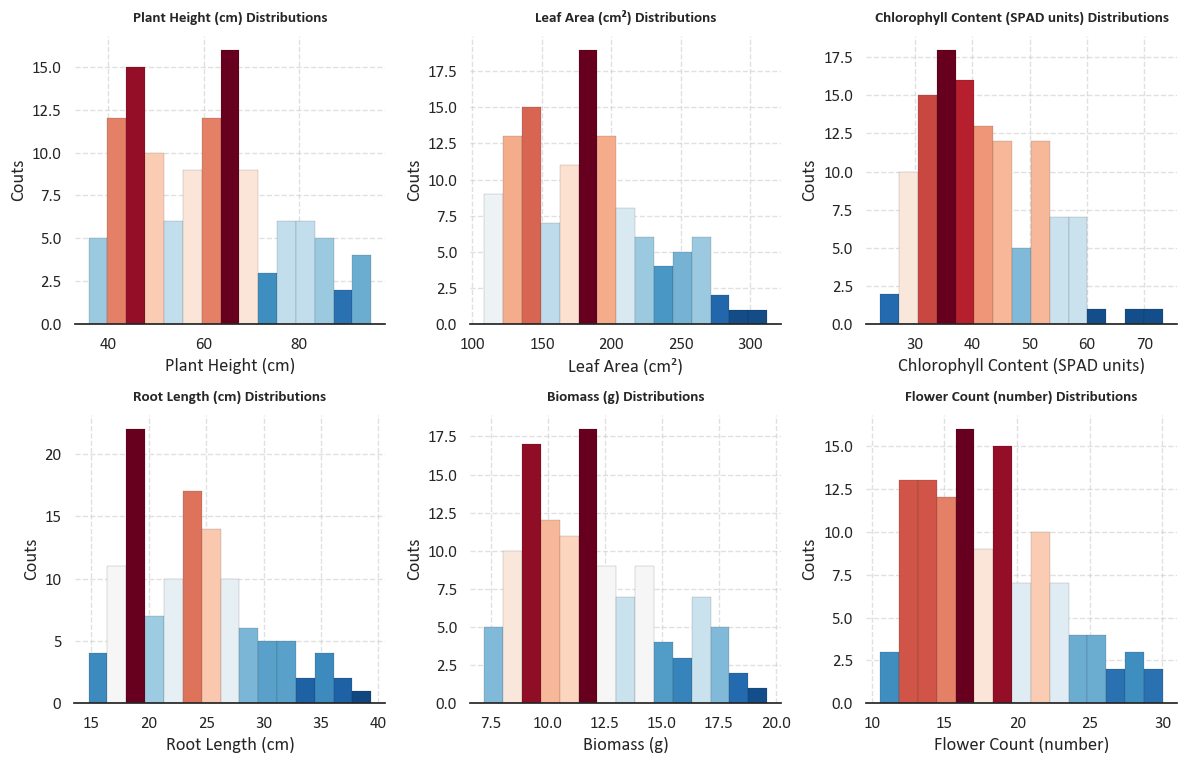

In [339]:
def visualize_histogram(df, Variables):
    num_variables = len(Variables)
    rows = math.ceil(num_variables / 3)
    cols = min(num_variables, 3)
    
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4* rows))
    plt.rcParams.update({'font.family': 'Dubai', 'font.style': 'normal', 'font.size': 11 })
    axes = axes.flatten() if num_variables > 1 else [axes]
    
    for idx, column in enumerate(Variables):
        n, bins, patches = axes[idx].hist(df[column], bins=15, edgecolor='k', linewidth=0.1, alpha=1)
        for i in range(len(patches)): patches[i].set_facecolor(plt.cm.RdBu_r(n[i] / max(n)))
        axes[idx].set_title(f"{column} Distributions", fontsize=11, pad=10, fontweight='bold')
        axes[idx].spines[['right', 'left', 'top']].set_visible(False)
        axes[idx].grid(linestyle='--', alpha=0.6)
        axes[idx].set_xlabel(column)
        axes[idx].set_ylabel('Couts')
    
    for idx in range(num_variables, len(axes)): fig.delaxes(axes[idx])
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

Variables = numerical_columns = df.select_dtypes(include=[np.number]).columns.tolist()[:6]
visualize_histogram(df, Variables)

<h4 style='font-family: Viner Hand ITC; font-size: 20px; font-weight: 600'>6.2:  Barplot | Visual Comparisons</h4> 

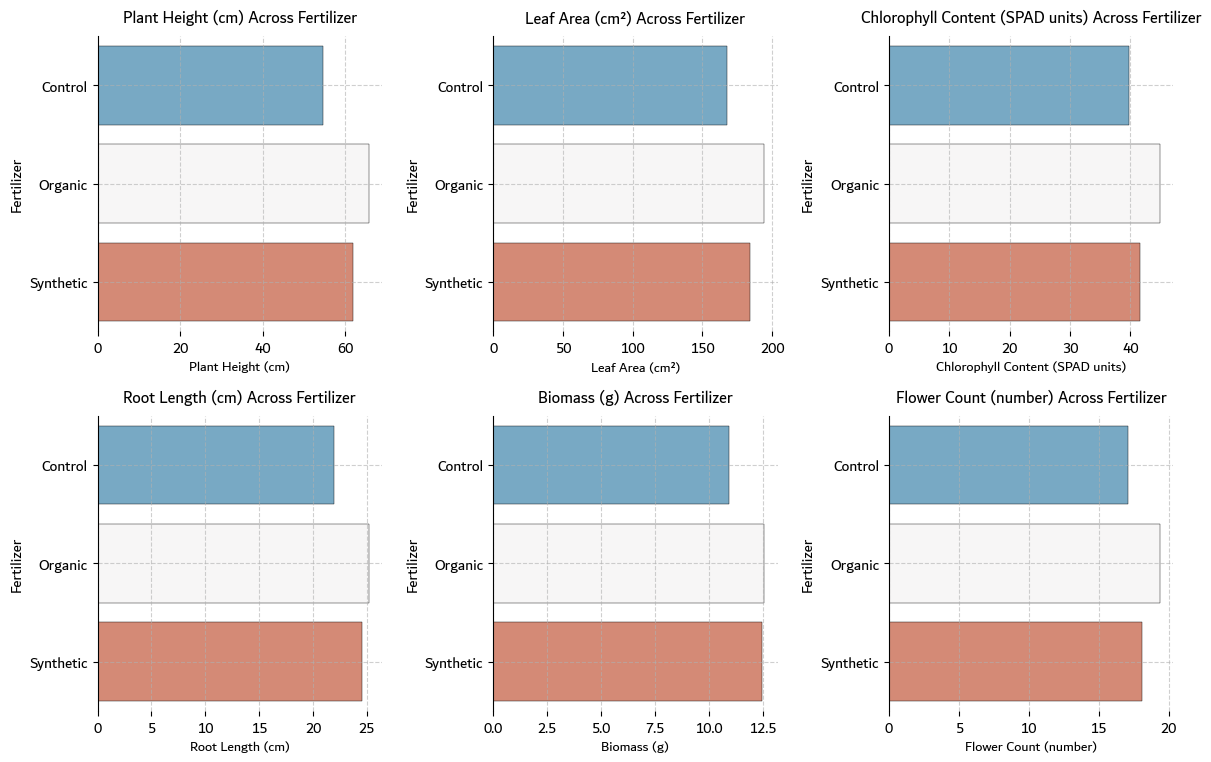

In [87]:
def visualize_barplot(df, Variables, group_col):
    num_variables = len(Variables)
    rows = math.ceil(num_variables / 3)
    cols = min(num_variables, 3)
    
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
    plt.rcParams.update({'font.family': 'Dubai', 'font.style': 'normal', 'font.size': 11 })
    axes = axes.flatten() if num_variables > 1 else [axes]
    
    for idx, column in enumerate(Variables):
        params = dict(errorbar=None, edgecolor='k', linewidth=0.3, palette='RdBu_r')
        sns.barplot(data=df, x=df[column], y=df[group_col], ax=axes[idx], hue =group_col, **params)   
        sns.despine(ax=axes[idx], right=True, bottom=True)
        axes[idx].set_title(f"{column} Across {group_col}", fontsize=12, pad=10)
        axes[idx].set_xlabel(column, fontsize=10)
        axes[idx].grid(linestyle='--', alpha=0.6)
        
    
    for idx in range(num_variables, len(axes)):
        fig.delaxes(axes[idx])
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

Variables = df.select_dtypes(include=[np.number]).columns[:6]
visualize_barplot(df, Variables, group_col='Fertilizer')

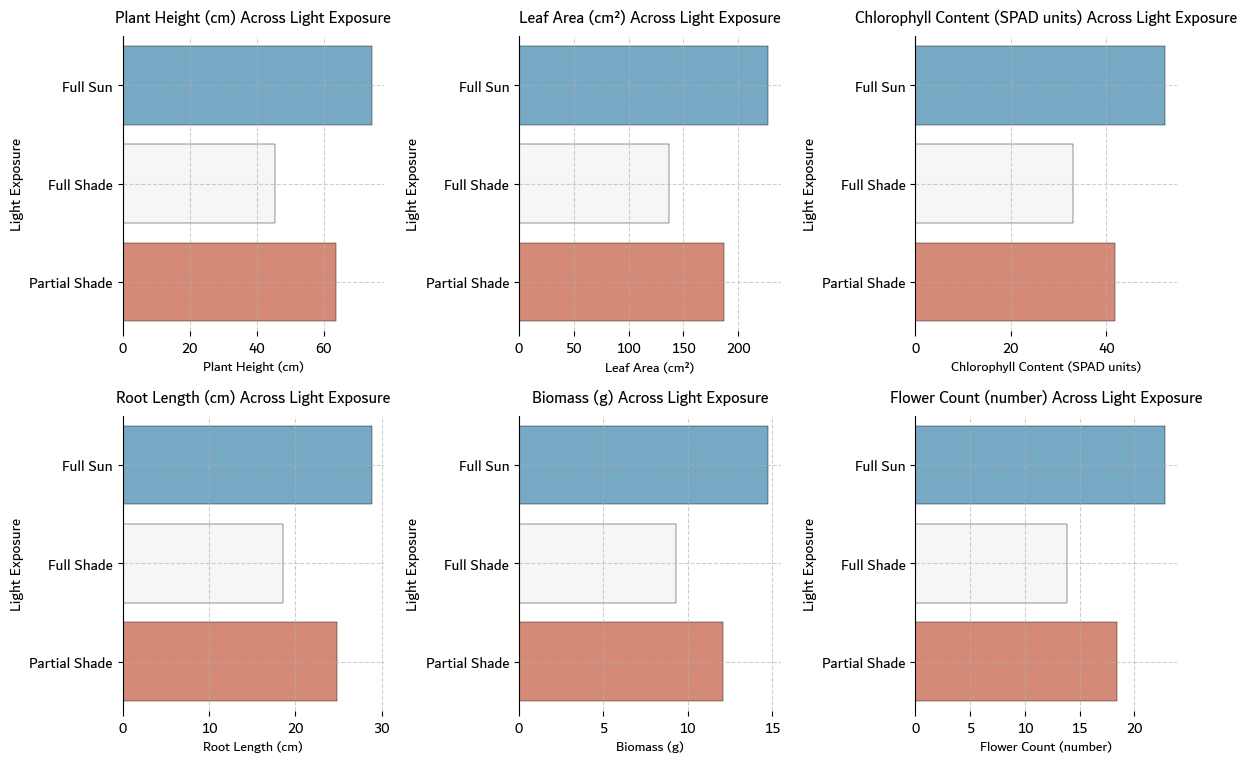

In [88]:
Variables = df.select_dtypes(include=[np.number]).columns[:6]
visualize_barplot(df, Variables, group_col='Light Exposure')

<h4 style='font-family: Viner Hand ITC; font-size: 20px; font-weight: 600'>6.3:  Boxplot | Visual Comparisons</h4> 

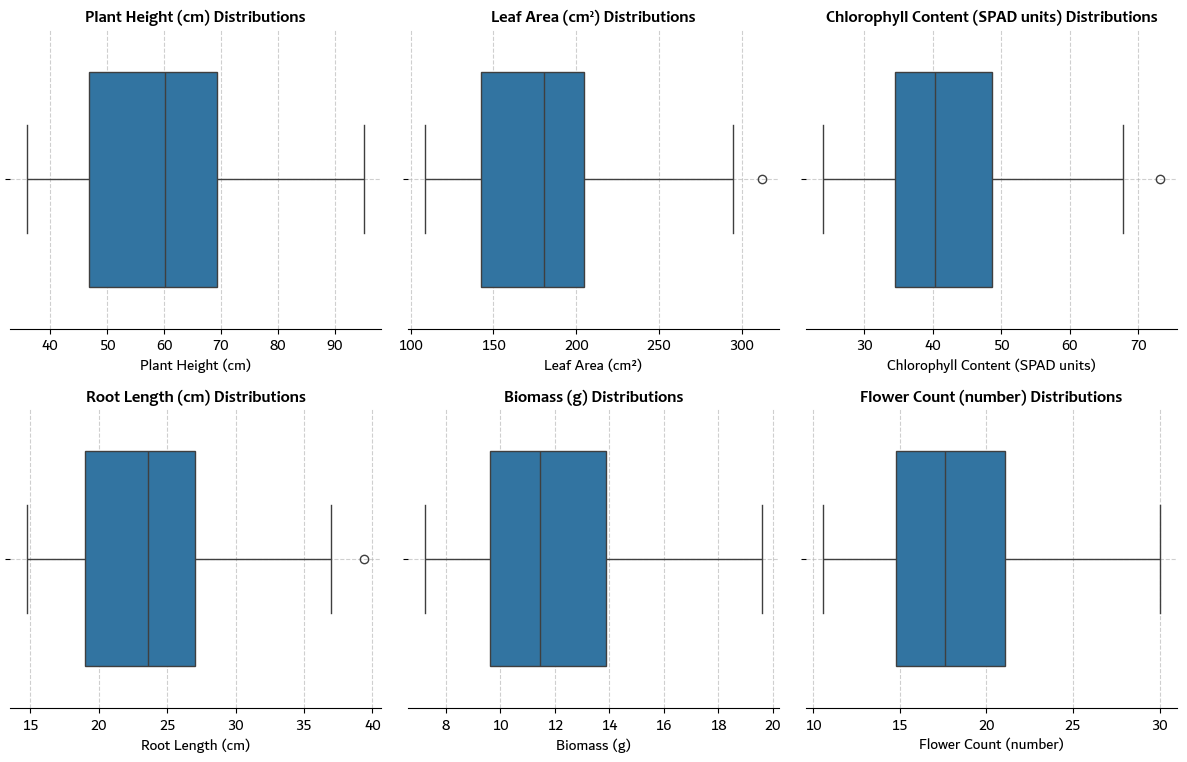

In [89]:
def visualize_boxplots(df: pd.DataFrame, group: str = None, num_cols: list=None):
    if num_cols is None:
        num_cols = df.select_dtypes(include=['number']).columns.tolist()[:6]
        if group in num_cols:
            num_cols.remove(group)
        
    num_variables = len(num_cols)
    rows = math.ceil(num_variables / 3)
    cols = min(num_variables, 3)
    
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
    plt.rcParams.update({'font.family': 'Calibri', 'font.style': 'normal', 'font.size': 11 })
    axes = axes.flatten() if num_variables > 1 else [axes]
    
    for idx, column in enumerate(num_cols):
        if group is not None:
            sns.boxplot(data=df, x=df[column], fill=True, gap=0.1, ax=axes[idx], hue=group, palette='RdBu_r')  
            axes[idx].set_title(f"{column} Across {group}", fontsize=12, fontweight='bold', fontfamily='Candara')
            axes[idx].legend(frameon=False)
        else :
            sns.boxplot(data=df, x=df[column], fill=True, gap=0.1, ax=axes[idx],)
            axes[idx].set_title(f"{column} Distributions", fontsize=12, fontweight='bold', fontfamily='Candara')
            
        axes[idx].spines[['right', 'left', 'top']].set_visible(False)
        axes[idx].set_xlabel(column, fontsize=11)
        axes[idx].grid(linestyle='--', alpha=0.6)
    
    for idx in range(num_variables, len(axes)): fig.delaxes(axes[idx])
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()
    
    return fig


fig = visualize_boxplots(df)

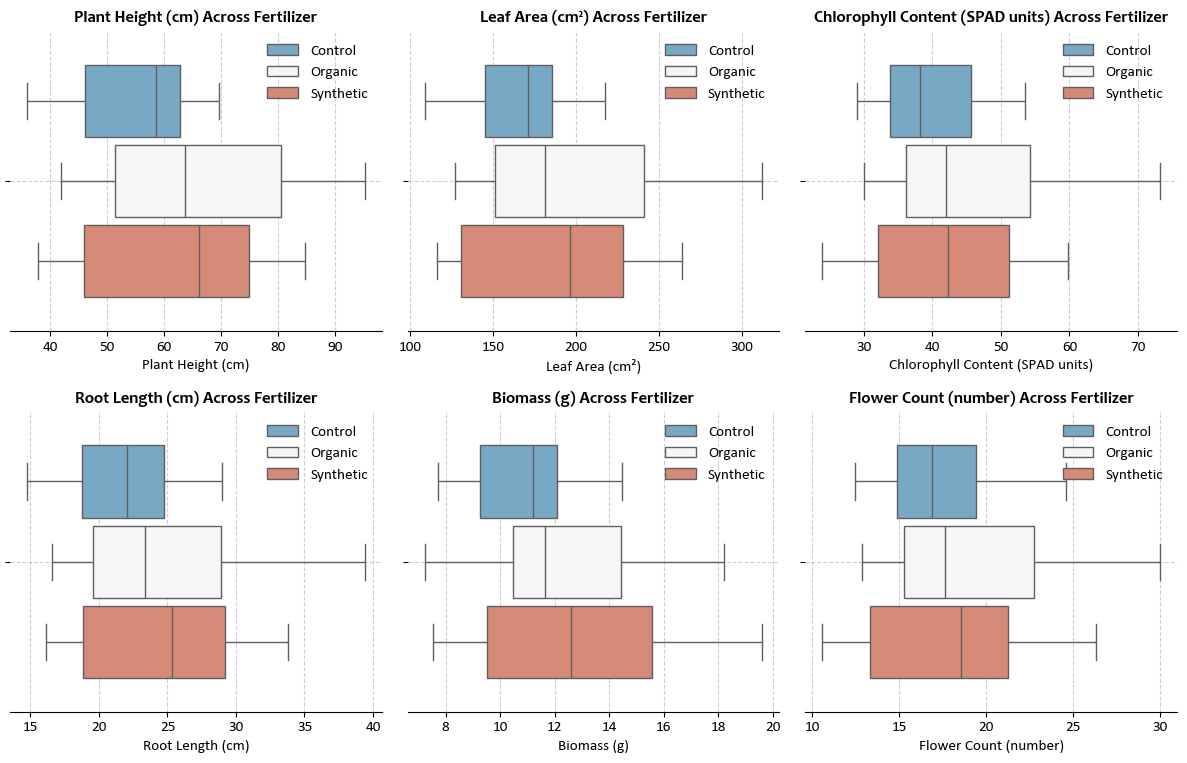

In [90]:
fig = visualize_boxplots(df, group='Fertilizer')

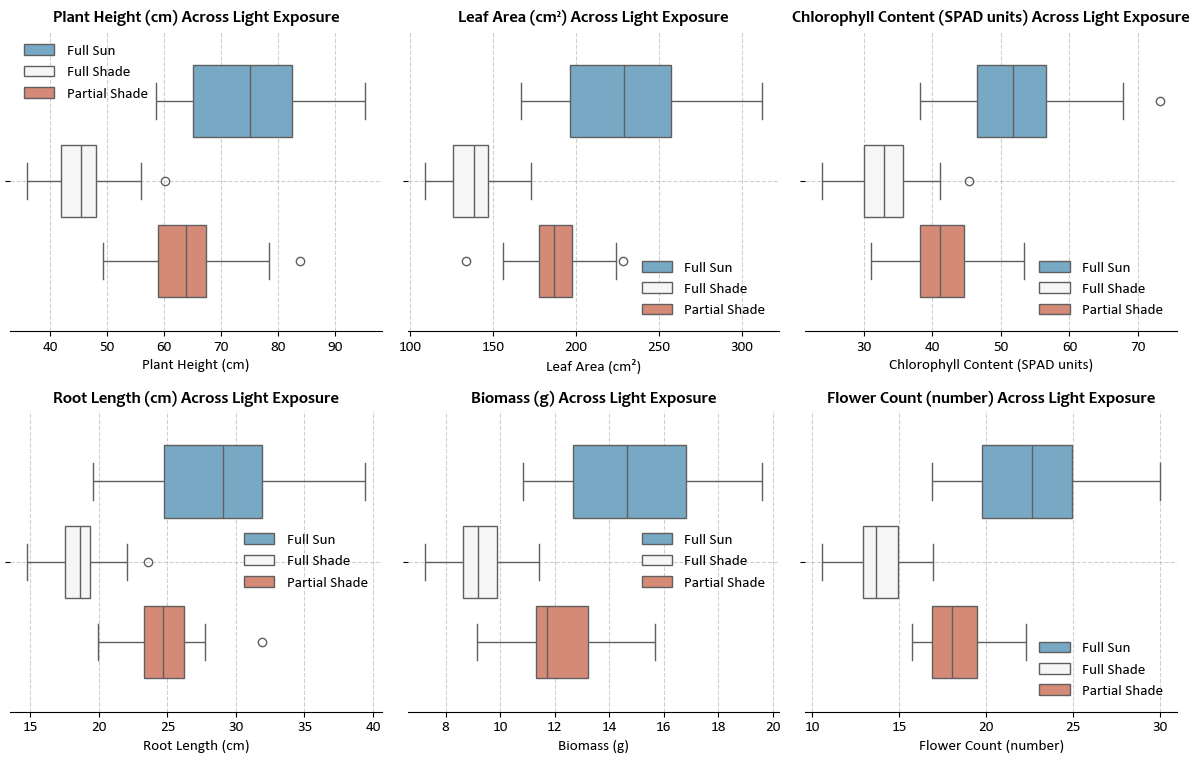

In [91]:
fig = visualize_boxplots(df, group='Light Exposure')

<h4 style='font-family: Viner Hand ITC; font-size: 20px; font-weight: 600'>6.4:  Swarmplot | Visualize Datapoints</h4> 

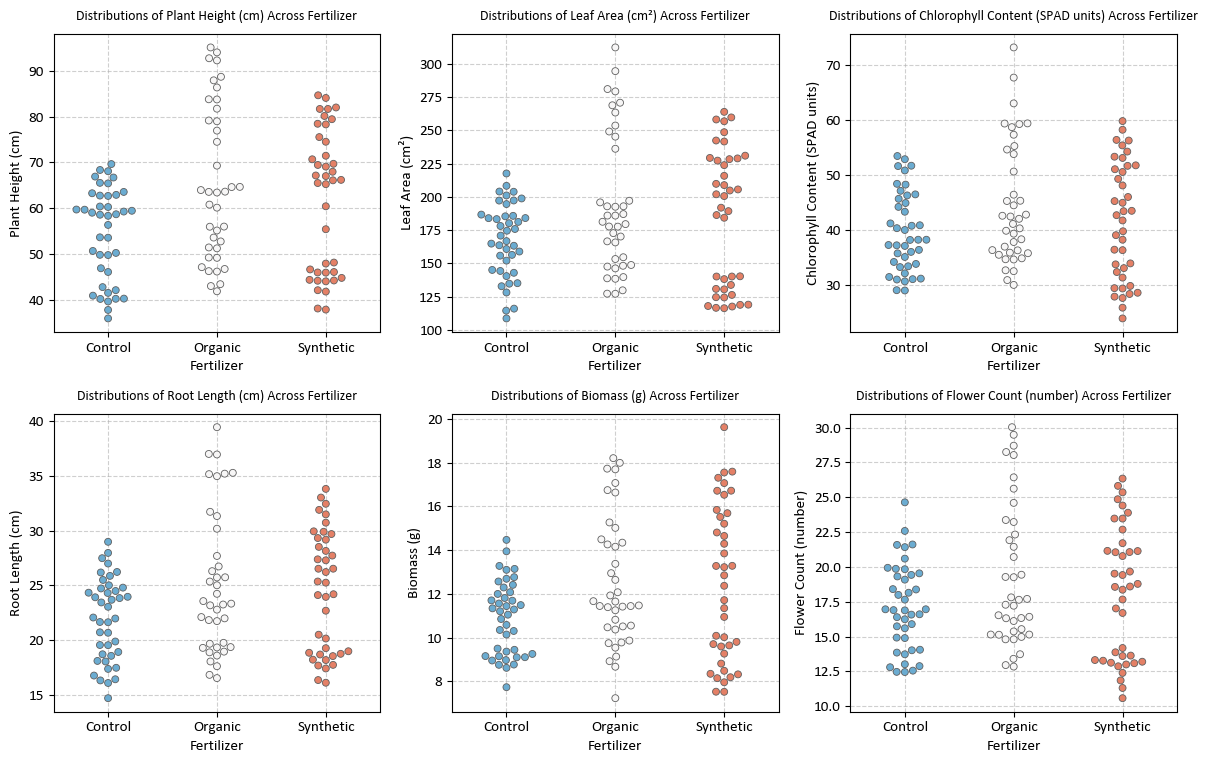

In [93]:
def visualize_swarmplots(df, variables, group):
    num_variables = len(variables)
    rows = math.ceil(num_variables / 3)
    cols = min(num_variables, 3)
    
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
    axes = axes.flatten() if num_variables > 1 else [axes]
    
    for idx, column in enumerate(variables):
        sns.swarmplot(data=df, x=df[group], y=df[column], ax=axes[idx], hue=group, linewidth=0.6, palette='RdBu_r')   
        axes[idx].set_title(f"Distributions of {column} Across {group}", fontsize=10, pad=10)
        axes[idx].set_xlabel(group, fontsize=11)
        axes[idx].grid(linestyle='--', alpha=0.6)
    
    for idx in range(num_variables, len(axes)):
        fig.delaxes(axes[idx])
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

variables = df.select_dtypes(include=[np.number]).columns[:6]
visualize_swarmplots(df, variables=variables, group='Fertilizer')

<h1 style='font-family: Viner Hand ITC; font-size: 25px; font-weight: 600'>8.4:   Correllation Analysis: Exploring Relation Ship Between Variables</h1>

In [99]:
def compute_correlation_matrix(df, method="pearson", visualize=True):
    if method not in ['pearson', 'spearman', 'kendall']: 
        raise ValueError("Invalid method. Choose from 'pearson', 'spearman', or 'kendall'.")
    numeric_df = df.select_dtypes(include=['number'])
    corr_matrix = numeric_df.corr(method=method)
    return corr_matrix

correlation_matrix = compute_correlation_matrix(df, method="pearson")
correlation_matrix

Plant Height (cm)  Leaf Area (cm²)  \
Plant Height (cm)                              1.00             0.89   
Leaf Area (cm²)                                0.89             1.00   
Chlorophyll Content (SPAD units)               0.82             0.82   
Root Length (cm)                               0.84             0.86   
Biomass (g)                                    0.81             0.80   
Flower Count (number)                          0.85             0.87   
Seed Yield (g)                                 0.80             0.85   
Stomatal Conductance (mmol/m²/s)               0.85             0.86   

                                  Chlorophyll Content (SPAD units)  \
Plant Height (cm)                                             0.82   
Leaf Area (cm²)                                               0.82   
Chlorophyll Content (SPAD units)                              1.00   
Root Length (cm)                                              0.79   
Biomass (g)                                                   0.78   
Flower Count (number)                                         0.83   
Seed Yield (g)                                                0.80   
Stomatal Conductance (mmol/m²/s)                              0.78   

                                  Root Length (cm)  Biomass (g)  \
Plant Height (cm)                             0.84         0.81   
Leaf Area (cm²)                               0.86         0.80   
Chlorophyll Content (SPAD units)              0.79         0.78   
Root Length (cm)                              1.00         0.78   
Biomass (g)                                   0.78         1.00   
Flower Count (number)                         0.83         0.83   
Seed Yield (g)                                0.81         0.82   
Stomatal Conductance (mmol/m²/s)              0.81         0.81   

                                  Flower Count (number)  Seed Yield (g)  \
Plant Height (cm)                                  0.85            0.80   
Leaf Area (cm²)                                    0.87            0.85   
Chlorophyll Content (SPAD units)                   0.83            0.80   
Root Length (cm)                                   0.83            0.81   
Biomass (g)                                        0.83            0.82   
Flower Count (number)                              1.00            0.84   
Seed Yield (g)                                     0.84            1.00   
Stomatal Conductance (mmol/m²/s)                   0.84            0.85   

                                  Stomatal Conductance (mmol/m²/s)  
Plant Height (cm)                                             0.85  
Leaf Area (cm²)                                               0.86  
Chlorophyll Content (SPAD units)                              0.78  
Root Length (cm)                                              0.81  
Biomass (g)                                                   0.81  
Flower Count (number)                                         0.84  
Seed Yield (g)                                                0.85  
Stomatal Conductance (mmol/m²/s)                              1.00

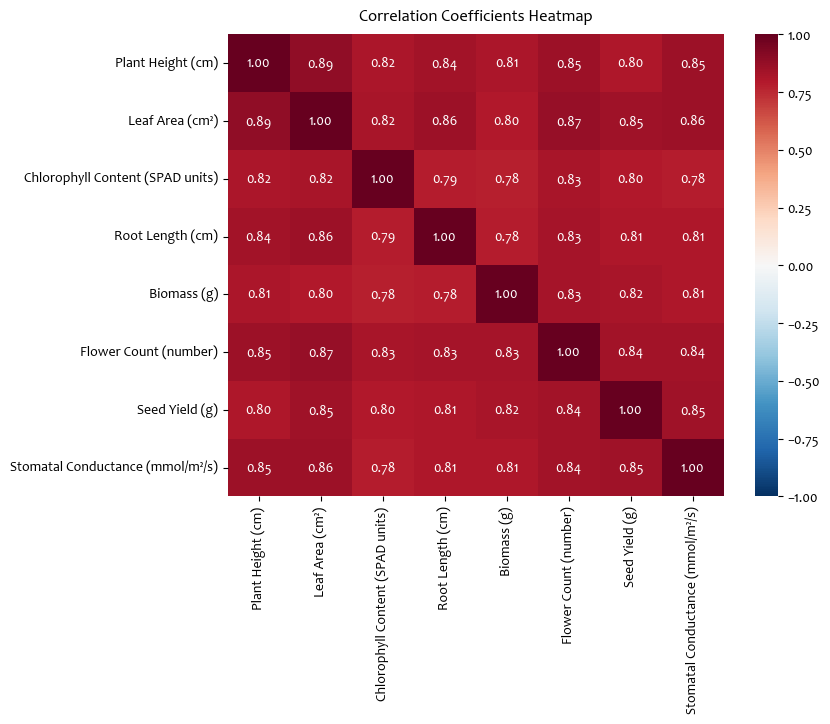

In [102]:
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Coefficients Heatmap', fontsize=12, pad=10)
plt.grid(False)
plt.show()

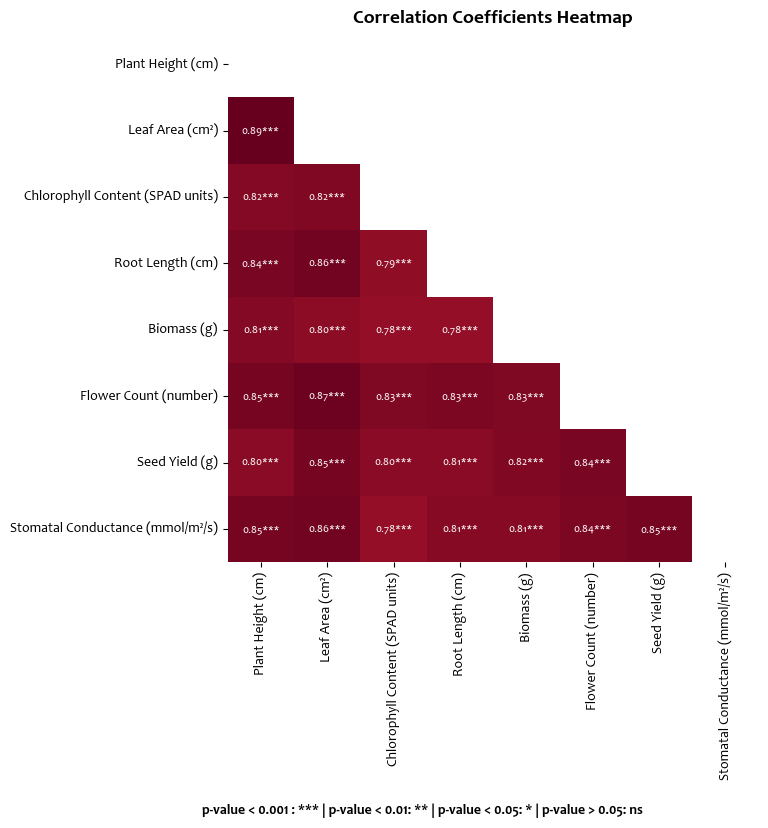

In [108]:
from scipy.stats import pearsonr

def calculate_correlations_and_pvalues(data):
    cols = data.columns
    n = len(cols)
    corr_matrix = np.zeros((n, n))
    p_value_matrix = np.ones((n, n))
    
    for i in range(n):
        for j in range(n):
            if i <= j:  # Calculate only once for each pair
                mask = ~(data.iloc[:, i].isna() | data.iloc[:, j].isna())
                if mask.sum() > 1:  # Need at least 2 observations
                    corr, p_value = pearsonr(data.iloc[:, i][mask], data.iloc[:, j][mask])
                    corr_matrix[i, j] = corr
                    corr_matrix[j, i] = corr
                    p_value_matrix[i, j] = p_value
                    p_value_matrix[j, i] = p_value
    
    return pd.DataFrame(corr_matrix, index=cols, columns=cols), \
           pd.DataFrame(p_value_matrix, index=cols, columns=cols)

def create_annotations(corr_matrix, p_value_matrix, decimal_places=2):
    annot_matrix = np.empty_like(corr_matrix, dtype=object)
    
    for i in range(corr_matrix.shape[0]):
        for j in range(corr_matrix.shape[1]):
            corr = corr_matrix.iloc[i, j]
            p_val = p_value_matrix.iloc[i, j]
            
            corr_str = f"{corr:.{decimal_places}f}"
            if p_val < 0.001: stars = "***"
            elif p_val < 0.01: stars = "**"
            elif p_val < 0.05: stars = "*"
            else: stars = "ns"
                
            annot_matrix[i, j] = f"{corr_str}{stars}"
    
    return pd.DataFrame(annot_matrix, index=corr_matrix.index, columns=corr_matrix.columns)

def plot_correlation_heatmap(data, figsize=(10, 8), cmap="RdBu_r", annot_fontsize=8, title="Correlation Heatmap"):
    corr_matrix, p_value_matrix = calculate_correlations_and_pvalues(data)
    annotations = create_annotations(corr_matrix, p_value_matrix)
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    plt.rcParams.update({'font.family': 'Candara', 'font.style': 'normal', 'font.size': 10})
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(
        corr_matrix, mask=mask, cmap=cmap, center=0, square=True, 
        annot=annotations, fmt="",annot_kws={"size": annot_fontsize}, cbar=False,ax=ax)
    
    ax.set_title(title, fontsize=14, color='black', fontfamily='candara', weight='bold')
    p_value = "p-value < 0.001 : *** | p-value < 0.01: ** | p-value < 0.05: * | p-value > 0.05: ns "
    fig.text(0.5, -0.02, p_value, ha='center', va='center', fontsize=10, color='black', fontfamily='candara', weight='bold')
    plt.tight_layout()
    plt.show()
    
    return fig
    
if __name__ == "__main__":
    numeric_df = df.select_dtypes(include=['number'])
    fig = plot_correlation_heatmap(numeric_df, title="Correlation Coefficients Heatmap")
    plt.show()

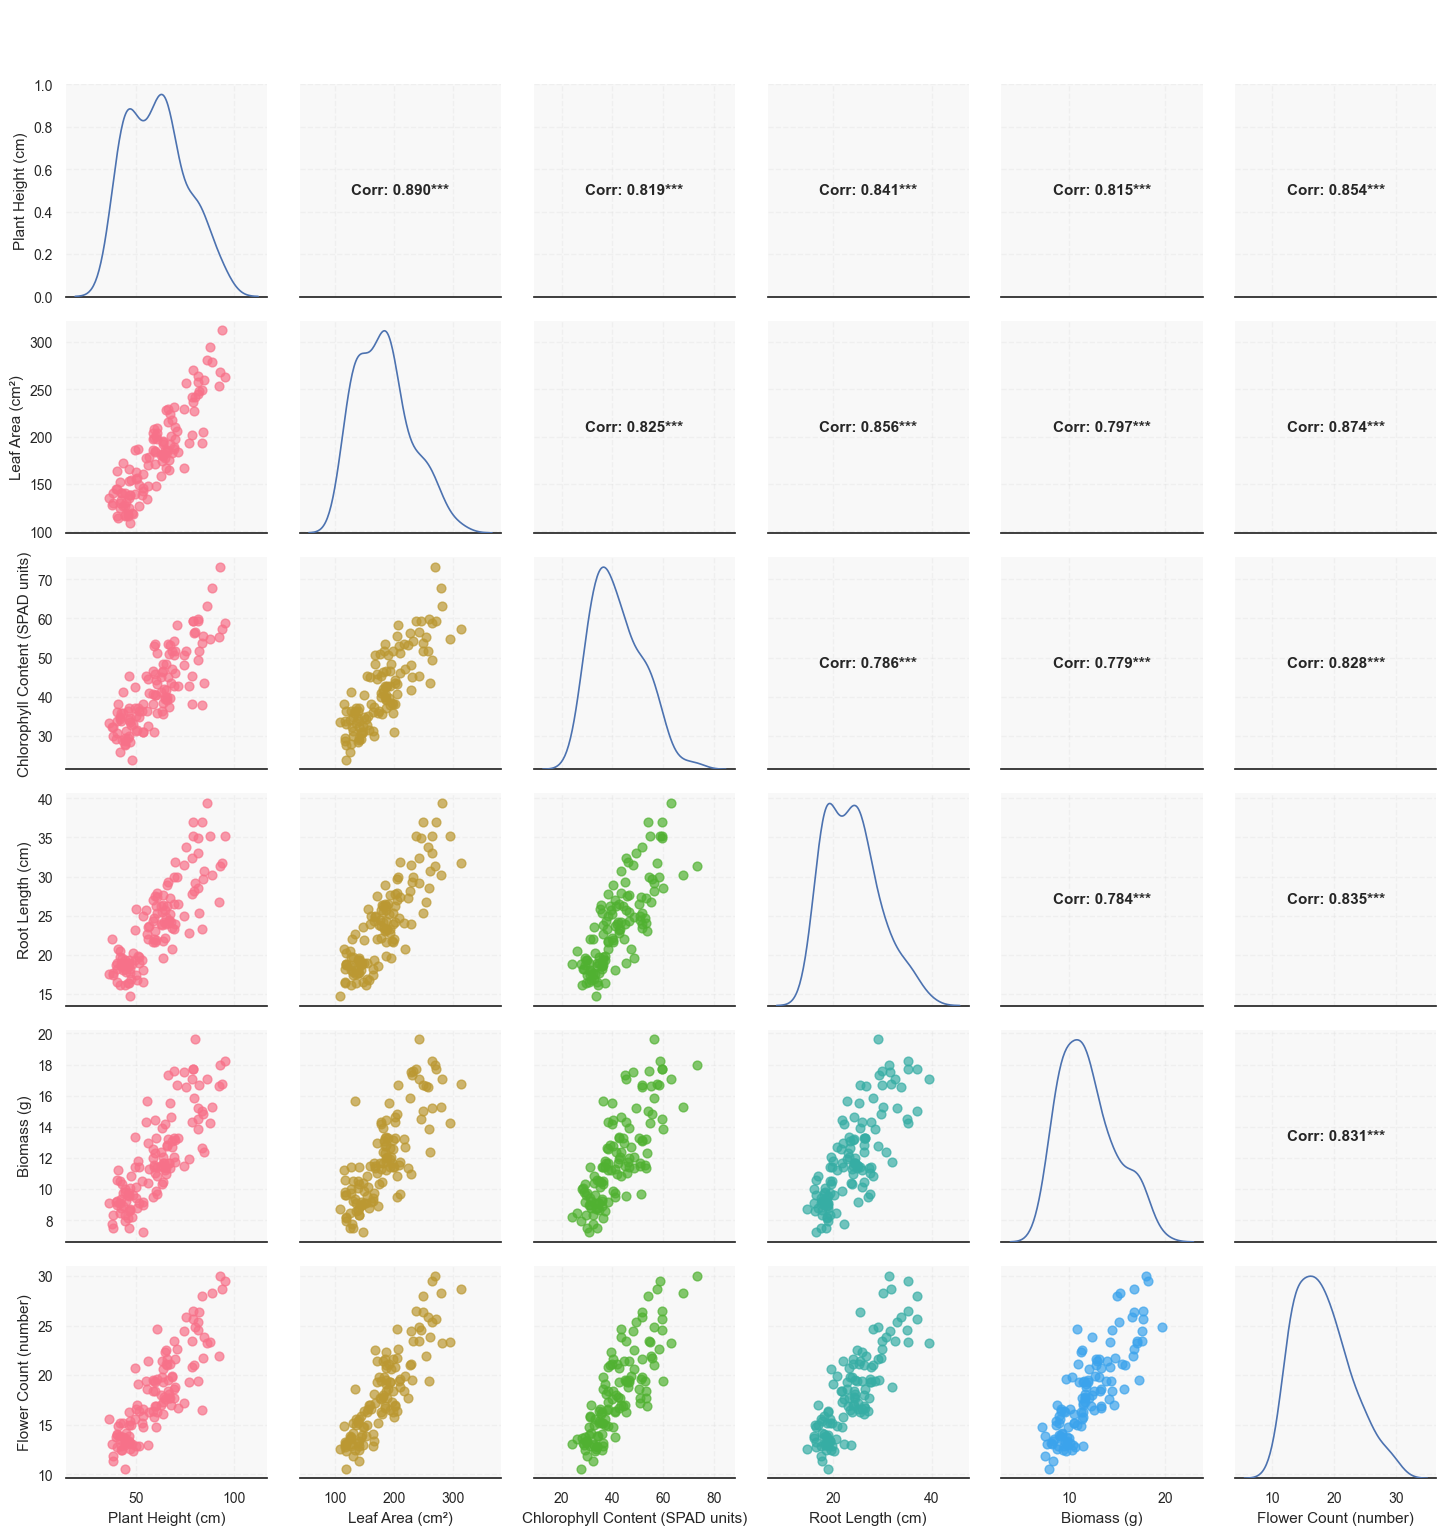

In [112]:
def corrfunc(x, y, **kws):
    r, p = stats.pearsonr(x, y)
    stars = 'ns'
    if p <= 0.001: stars = '***'
    elif p <= 0.01: stars = '**'
    elif p <= 0.05: stars = '*'
    ax = plt.gca()
    
    ax.annotate(
        f"Corr: {r:.3f}{stars}", 
        xy=(0.5, 0.5), 
        xycoords=ax.transAxes,
        ha='center', 
        va='center', 
        fontsize=11, 
        fontweight='bold'
    )

def scatter_with_labels(x, y, **kwargs):
    ax = plt.gca()
    sns.scatterplot(
        x=x, 
        y=y, 
        s=kwargs.pop("s", 35), 
        color=kwargs.pop("marker_color", "black"), 
        alpha=0.7, 
        ax=ax)


def plot_pairplot(df, title=" ", label_fontsize=10, marker_size=35):
    plt.rcParams.update({'font.family': 'Dubai', 'font.style': 'normal', 'font.size': 9})
    sns.set_theme(style="white", font_scale=1.1)
    palette = sns.color_palette("husl", len(df.columns))
    
    g = sns.PairGrid(df, diag_sharey=False, layout_pad=0.5)
    for i, row_var in enumerate(df.columns):
        for j, col_var in enumerate(df.columns):
            if i > j: g.axes[i, j].scatter(
                df[col_var], 
                df[row_var], 
                s=marker_size, 
                color=palette[j], 
                alpha=0.7
            )

    g.map_upper(corrfunc)
    g.map_diag(sns.kdeplot, fill=False, lw=1.2)

    for i, row_vars in enumerate(df.columns):
        for j, col_vars in enumerate(df.columns):
            ax = g.axes[i, j]
            #if i != j: ax.set_title(f"{row_vars} vs {col_vars}", fontsize=label_fontsize, pad=5)
            if i == len(df.columns) - 1: ax.set_xlabel(col_vars, fontsize=label_fontsize)
            if j == 0: ax.set_ylabel(row_vars, fontsize=label_fontsize)

    g.fig.suptitle(title, fontsize=16, fontweight='bold', fontfamily = 'Agency FB', y=1.03)
    for ax in g.axes.flatten():
        ax.set_facecolor("#f8f8f8")
        ax.tick_params(axis='both', labelsize=label_fontsize-1)
        ax.grid(linestyle='--', alpha=0.2)
        sns.despine(ax=ax, left=True)

    plt.show()

data = df[df.select_dtypes(include=['number']).columns[:6]]
plot_pairplot(data, label_fontsize=11, marker_size=40)

In [113]:
from scipy.stats import pearsonr

def compute_pearson_r(df: pd.DataFrame, numerical_columns: list) -> pd.DataFrame:
    results = []

    for i, col1 in enumerate(numerical_columns):
        for col2 in numerical_columns[i+1:]:
            r_value, p_value = pearsonr(df[col1], df[col2])
            direction = ("Positive" if r_value > 0 else  "Negative" if r_value < 0 else "No correlation")
            strength = ("Strong" if abs(r_value) >= 0.7 else "Moderate" if abs(r_value) >= 0.3 else "Weak")

            results.append({
                'Variable 1': col1, 'Variable 2': col2,
                'Pearson\'s r': r_value, 'P-value': p_value,
                'Direction': direction, 'Strength': strength
            })
    
    return pd.DataFrame(results)

Variables = df.select_dtypes(include=[np.number]).columns
pearson_results_df = compute_pearson_r(df, numerical_columns=Variables)
pearson_results_df

Variable 1                        Variable 2  \
0                  Plant Height (cm)                   Leaf Area (cm²)   
1                  Plant Height (cm)  Chlorophyll Content (SPAD units)   
2                  Plant Height (cm)                  Root Length (cm)   
3                  Plant Height (cm)                       Biomass (g)   
4                  Plant Height (cm)             Flower Count (number)   
5                  Plant Height (cm)                    Seed Yield (g)   
6                  Plant Height (cm)  Stomatal Conductance (mmol/m²/s)   
7                    Leaf Area (cm²)  Chlorophyll Content (SPAD units)   
8                    Leaf Area (cm²)                  Root Length (cm)   
9                    Leaf Area (cm²)                       Biomass (g)   
10                   Leaf Area (cm²)             Flower Count (number)   
11                   Leaf Area (cm²)                    Seed Yield (g)   
12                   Leaf Area (cm²)  Stomatal Conductance (mmol/m²/s)   
13  Chlorophyll Content (SPAD units)                  Root Length (cm)   
14  Chlorophyll Content (SPAD units)                       Biomass (g)   
15  Chlorophyll Content (SPAD units)             Flower Count (number)   
16  Chlorophyll Content (SPAD units)                    Seed Yield (g)   
17  Chlorophyll Content (SPAD units)  Stomatal Conductance (mmol/m²/s)   
18                  Root Length (cm)                       Biomass (g)   
19                  Root Length (cm)             Flower Count (number)   
20                  Root Length (cm)                    Seed Yield (g)   
21                  Root Length (cm)  Stomatal Conductance (mmol/m²/s)   
22                       Biomass (g)             Flower Count (number)   
23                       Biomass (g)                    Seed Yield (g)   
24                       Biomass (g)  Stomatal Conductance (mmol/m²/s)   
25             Flower Count (number)                    Seed Yield (g)   
26             Flower Count (number)  Stomatal Conductance (mmol/m²/s)   
27                    Seed Yield (g)  Stomatal Conductance (mmol/m²/s)   

    Pearson's r  P-value Direction Strength  
0          0.89     0.00  Positive   Strong  
1          0.82     0.00  Positive   Strong  
2          0.84     0.00  Positive   Strong  
3          0.81     0.00  Positive   Strong  
4          0.85     0.00  Positive   Strong  
5          0.80     0.00  Positive   Strong  
6          0.85     0.00  Positive   Strong  
7          0.82     0.00  Positive   Strong  
8          0.86     0.00  Positive   Strong  
9          0.80     0.00  Positive   Strong  
10         0.87     0.00  Positive   Strong  
11         0.85     0.00  Positive   Strong  
12         0.86     0.00  Positive   Strong  
13         0.79     0.00  Positive   Strong  
14         0.78     0.00  Positive   Strong  
15         0.83     0.00  Positive   Strong  
16         0.80     0.00  Positive   Strong  
17         0.78     0.00  Positive   Strong  
18         0.78     0.00  Positive   Strong  
19         0.83     0.00  Positive   Strong  
20         0.81     0.00  Positive   Strong  
21         0.81     0.00  Positive   Strong  
22         0.83     0.00  Positive   Strong  
23         0.82     0.00  Positive   Strong  
24         0.81     0.00  Positive   Strong  
25         0.84     0.00  Positive   Strong  
26         0.84     0.00  Positive   Strong  
27         0.85     0.00  Positive   Strong

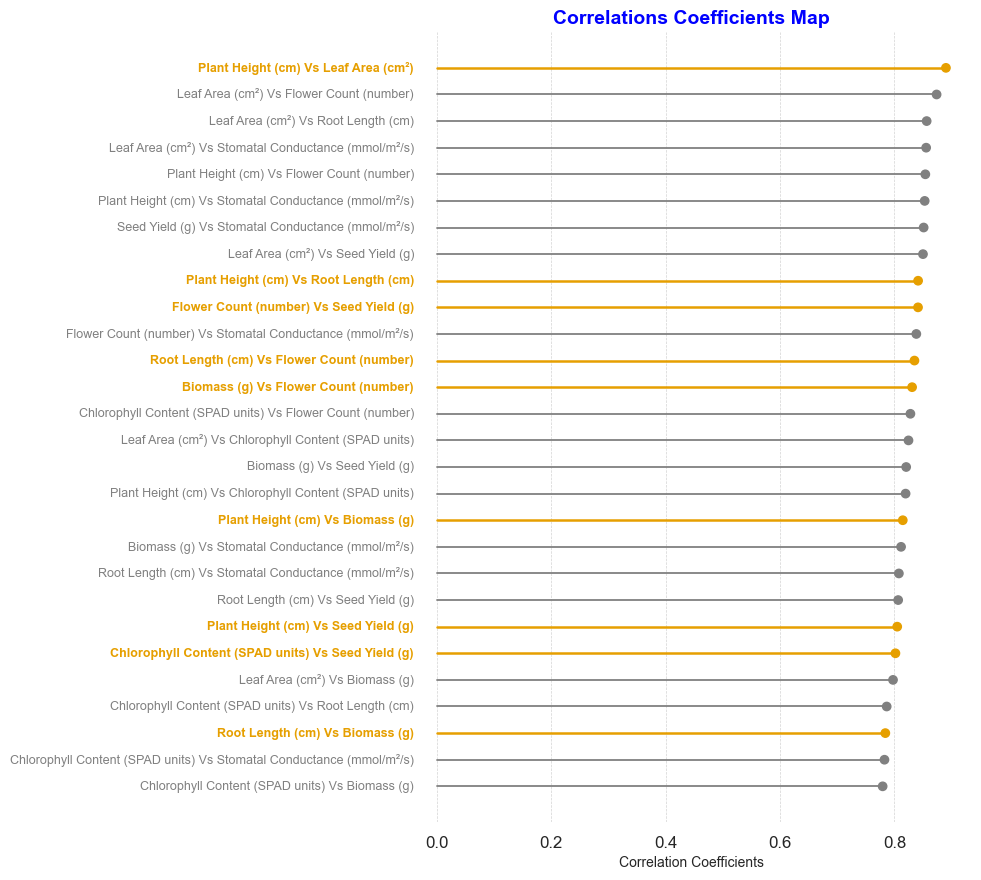

In [115]:
def compute_correlation_pairs(df, method="pearson"):
    numeric_df = df.select_dtypes(include=np.number)
    corr_matrix = numeric_df.corr(method=method)
    corr_pairs = corr_matrix.stack().reset_index()
    corr_pairs.columns = ["var1", "var2", "correlation"]
    corr_pairs = corr_pairs[corr_pairs["var1"] != corr_pairs["var2"]]
    corr_pairs["pair"] = corr_pairs["var1"] + " Vs " + corr_pairs["var2"]
    corr_pairs = corr_pairs.drop_duplicates(subset=["correlation"])
    return corr_pairs.sort_values(by="correlation", ascending=False)
    
def sample_highlight_pairs(df, n=5):
    return df["pair"].sample(n=n, random_state=42).tolist()

def get_color_mappings(df, highlights, highlight_color="tab:red", default_color="grey"):
    return [highlight_color if pair in highlights else default_color for pair in df["pair"]]

def plot_correlation_highlight(
    df, 
    highlights, 
    figsize=(10, 9),
    highlight_color="tab:red", 
    default_color="grey", 
    segment_width=1.5, 
    text_size=10, 
    nudge_x=0.03):
    
    df = df.copy()
    df["highlight"] = df["pair"].isin(highlights)
    df["color"] = get_color_mappings(df, highlights, highlight_color, default_color)
    fig, ax = plt.subplots(figsize=figsize)
    df = df.sort_values("correlation")

    for _, row in df.iterrows():
        ax.plot([0, row["correlation"]], [row["pair"], row["pair"]],
                color=row["color"], linewidth=segment_width + (0.5 if row["highlight"] else 0))

    ax.scatter(df["correlation"], df["pair"], color=df["color"], zorder=3)
    for _, row in df.iterrows():
        align = 'right' if row["correlation"] > 0 else 'left'
        x_offset = -nudge_x if row["correlation"] > 0 else nudge_x
        ax.text(0 + x_offset, row["pair"], row["pair"],
                ha=align, va='center', color=row["color"],
                fontweight='bold' if row["highlight"] else 'normal',
                fontsize=text_size)

    ax.set_xlabel("Correlation Coefficients", size=10)
    ax.set_ylabel("")
    ax.set_yticks([])
    ax.grid(True, linestyle='--', linewidth=0.5, color='lightgray')
    sns.despine(left=True, bottom=True)
    plt.title("Correlations Coefficients Map", fontsize=14, weight='bold', color = 'blue')
    plt.tight_layout()
    plt.show()

correlations = compute_correlation_pairs(df)
highlighted_pairs = sample_highlight_pairs(correlations, n=9)

plot_correlation_highlight(
    correlations,
    highlights=highlighted_pairs,
    highlight_color="#E69F00",
    default_color="gray",
    segment_width=1.3,
    text_size=9,
    nudge_x=0.04
)

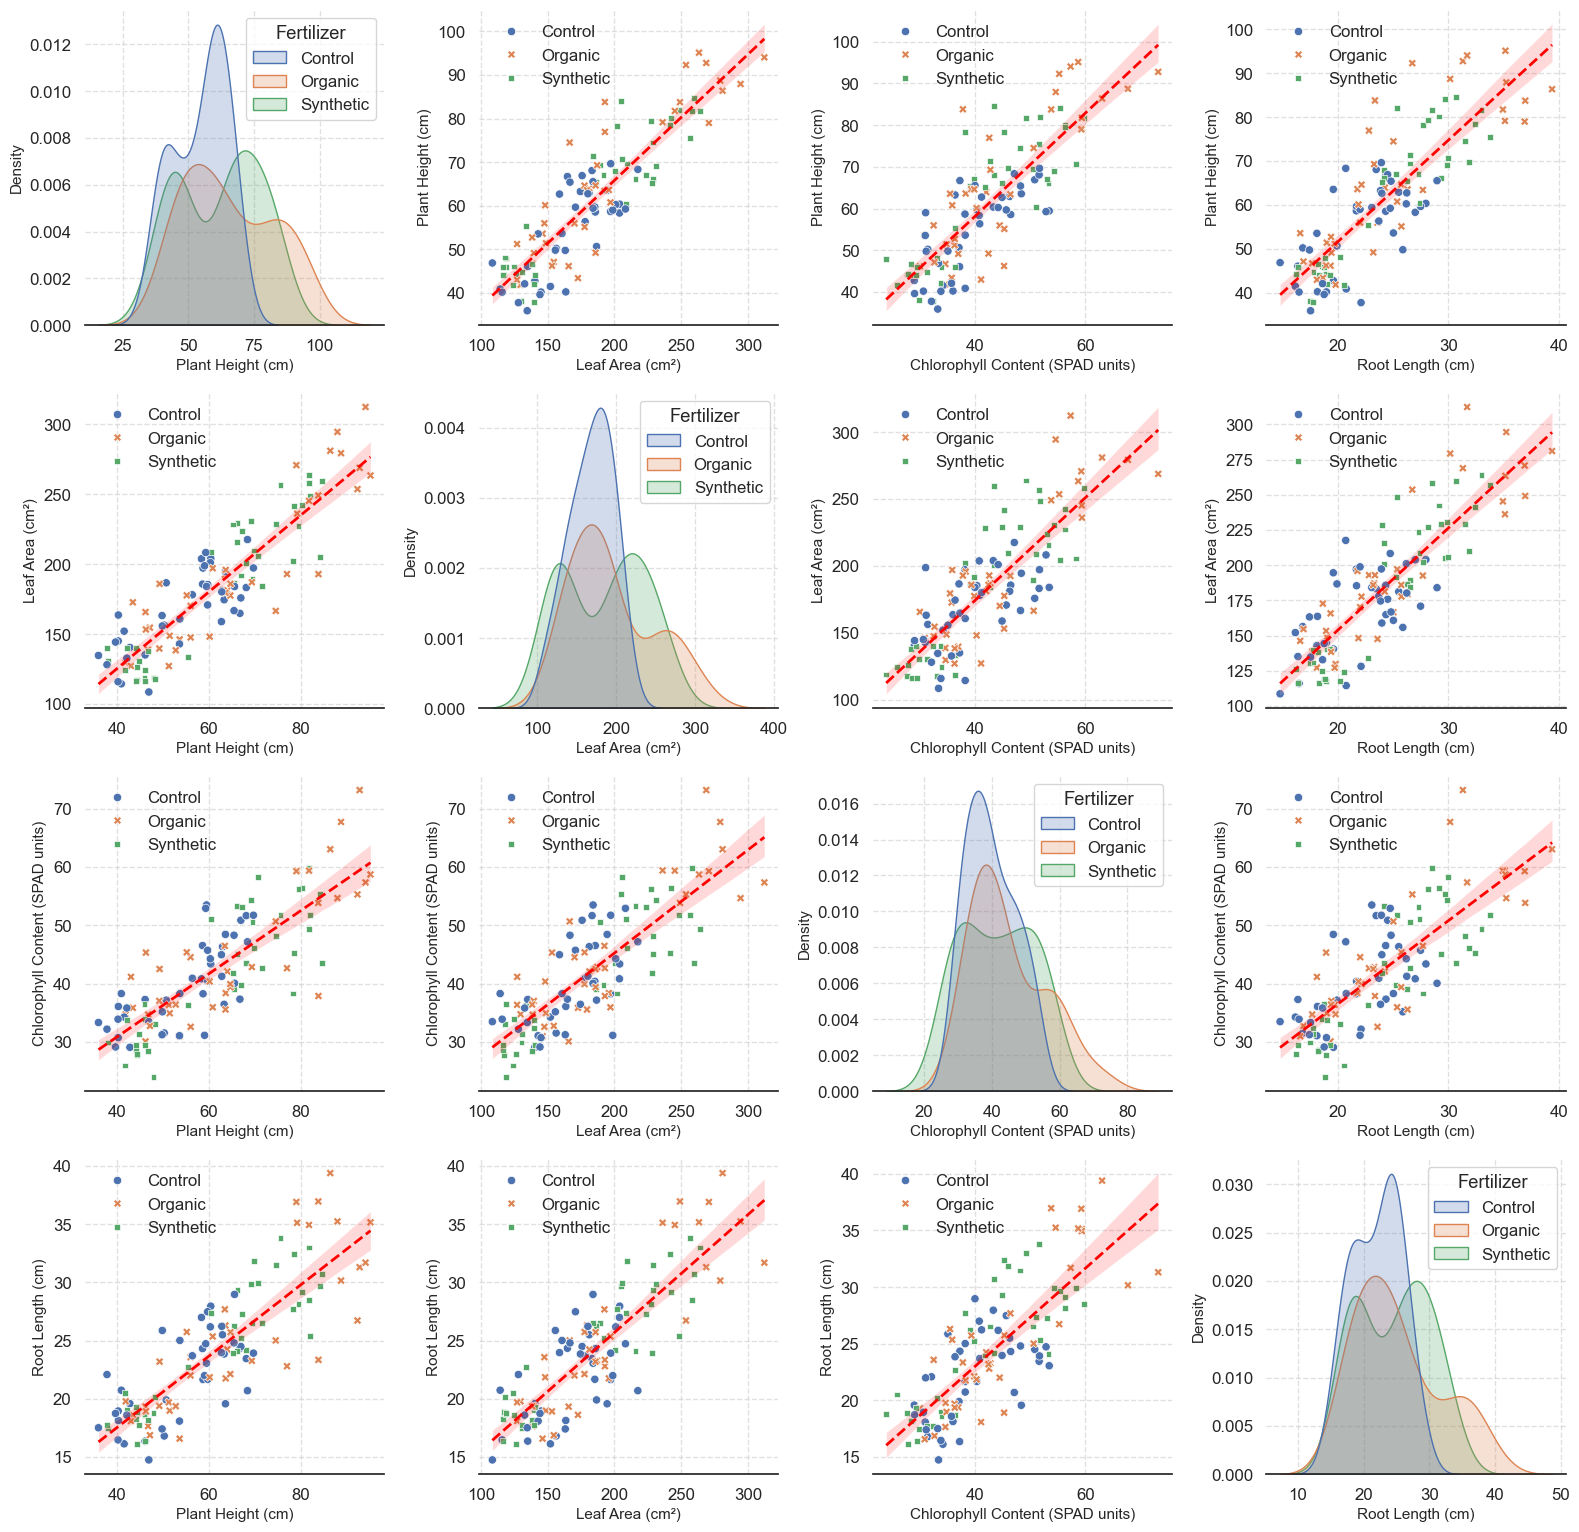

In [122]:
def visualize_pairplot(df, Variables, group):
    num_variables = len(Variables)
    rows = num_variables 
    cols = num_variables
    
    fig, axes = plt.subplots(rows, cols, figsize=(4* cols, 4*rows))
    for i in range(num_variables):
        for j in range(num_variables):
            ax = axes[i, j]
            if i == j:
                sns.kdeplot(data=df, x=df[Variables[j]], fill=True, hue=group, ax=ax)
                sns.despine(left=True, bottom=False)
                ax.set_xlabel(Variables[j], fontsize=11)
                ax.set_ylabel('Density', fontsize=11)
                ax.grid(linestyle='--', alpha=0.6)
                #ax.legend(frameon=False)
            else:
                sns.scatterplot(data=df, x=df[Variables[j]], y=df[Variables[i]], ax=ax, hue=group, style=group, alpha=1)
                sns.regplot(data=df, x=df[Variables[j]], y=df[Variables[i]], ax=ax,  scatter=False, line_kws={'color': 'red', 'linestyle': '--', 'lw': 2})
                sns.despine(left=True, bottom=False)
                ax.set_xlabel(Variables[j], fontsize=11)
                ax.set_ylabel(Variables[i], fontsize=11)
                ax.grid(linestyle='--', alpha=0.6)
                ax.legend(frameon=False)
        
    for i in range(num_variables):
        for j in range(num_variables):
            if i == j:
                axes[i, j].axis('on') 
    
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

if __name__ == "__main__":
    variables = df.select_dtypes(include=['number']).columns[:4]
    visualize_pairplot(df, variables, group='Fertilizer')

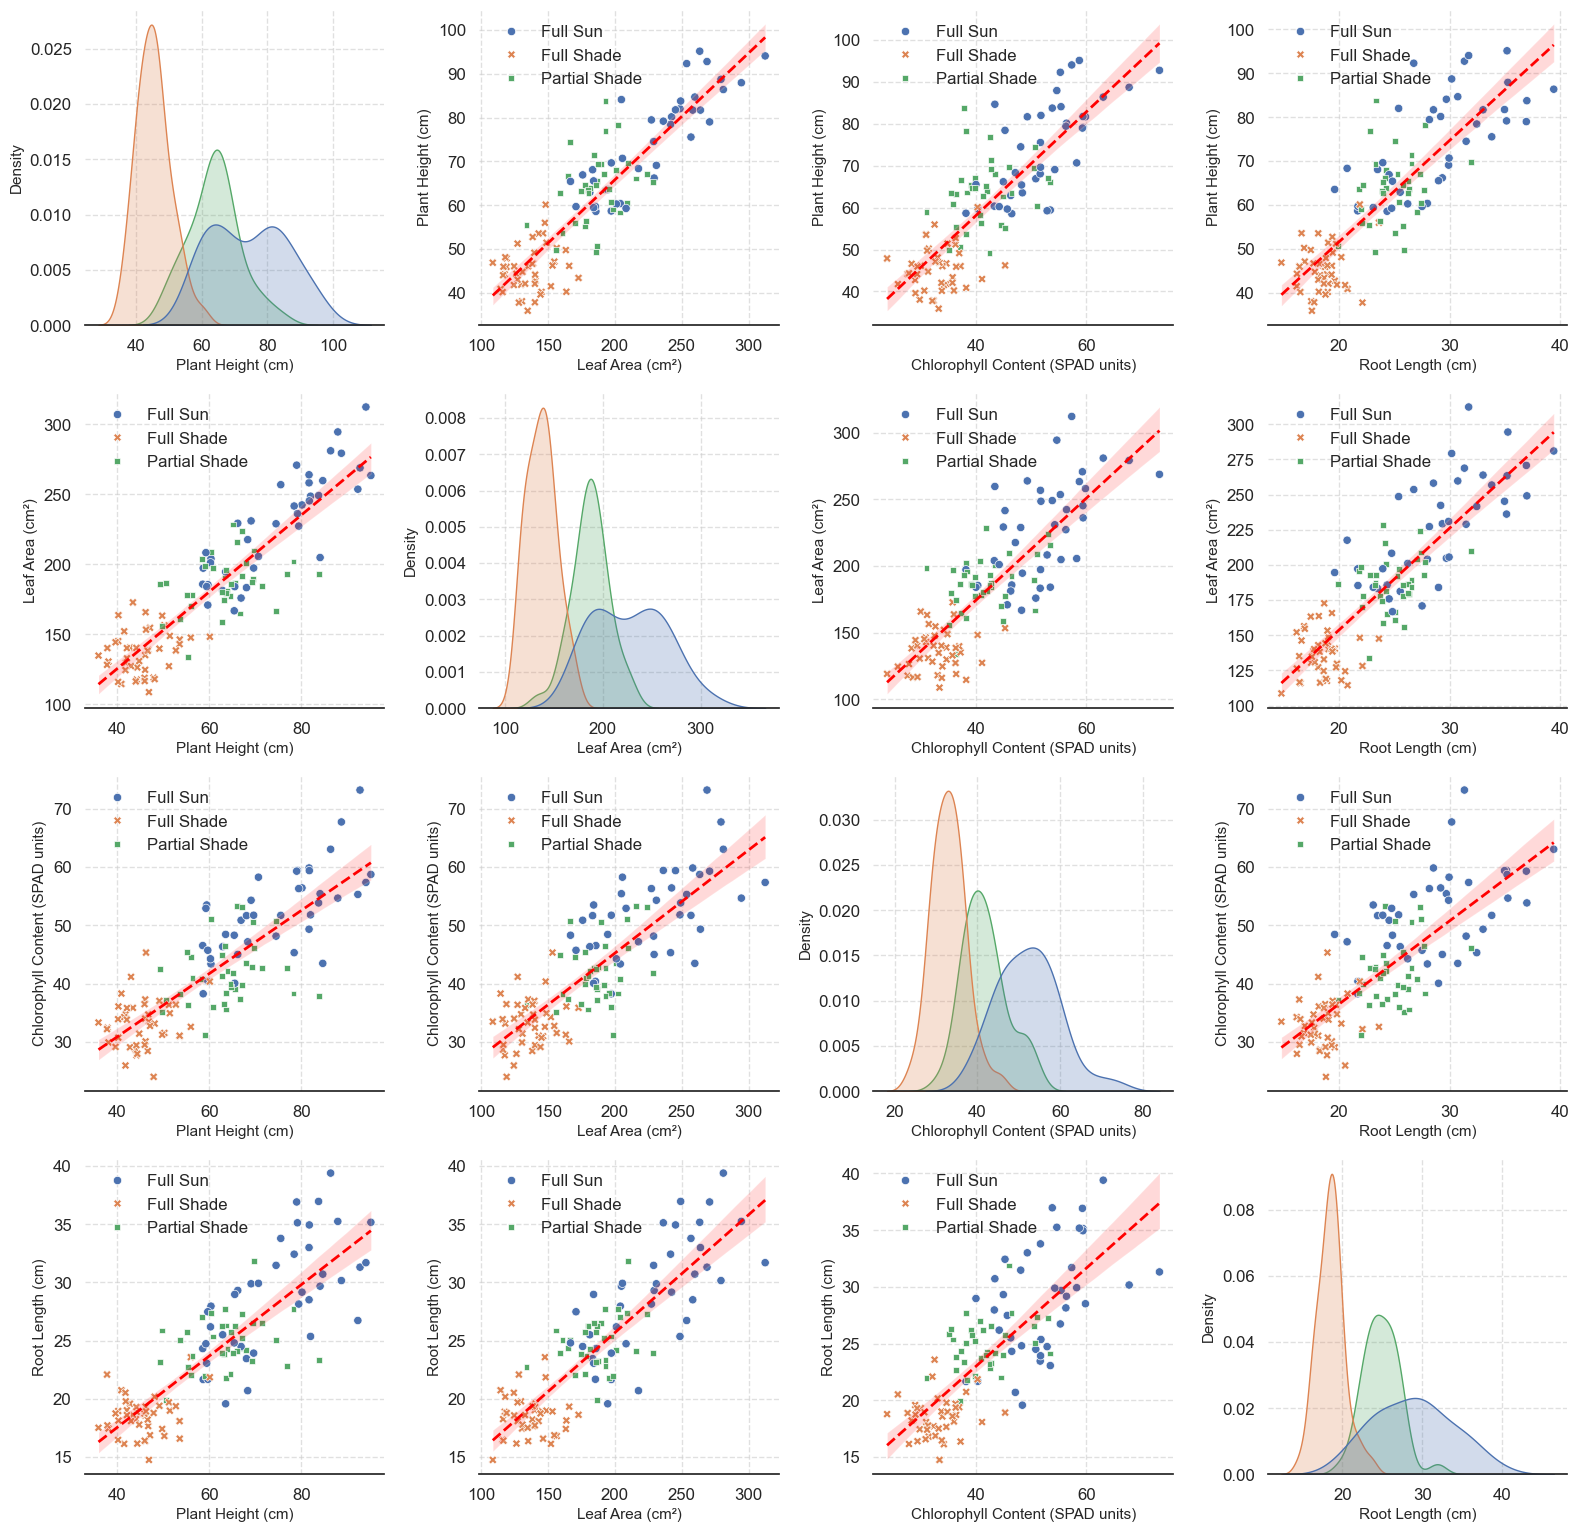

In [121]:
if __name__ == "__main__":
    variables = df.select_dtypes(include=['number']).columns[:4]
    visualize_pairplot(df, variables, group='Light Exposure')

<h1 style='font-family: Viner Hand ITC; font-size: 25px;  font-weight: 600'>8.0: Hypothesis Testing: Inferential Statistics</h1>

<H3 style='font-family: Viner Hand ITC; font-size: 20px;  font-weight: 600'>8.1: Parametric Tests Assumptions Validations</H3>

<h4 style='font-family: Viner Hand ITC; font-size: 18px; font-weight: 600'>8.1.1: Homogeneity of Variance (Levene's Test)</h4>

In [132]:
def Levene_test(df: pd.DataFrame, group_cols: list, numeric_cols: list = None) -> pd.DataFrame: 
    if numeric_cols is None:
        numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
        for g in group_cols:
            if g in numeric_cols:
                numeric_cols.remove(g)
    
    results = []
    for group_col in group_cols:
        for col in numeric_cols:
            grouped_data = [g[col].dropna().values for _, g in df.groupby(group_col)]
            if all(len(g) > 1 for g in grouped_data):  # Ensure each group has enough data
                levene_stat, levene_p = levene(*grouped_data)
                interpretation = 'Homogeneous' if levene_p > 0.05 else 'Not Homogeneous'
                
            else:
                levene_stat, levene_p, interpretation = None, None, 'Insufficient data'
            
            results.append({
                'Factors': group_col,
                'Variable': col,
                'Test Statistic': levene_stat,
                'P-Value': levene_p,
                'Interpretation': interpretation
            })
    
    return pd.DataFrame(results)

if __name__ == "__main__":
    results = Levene_test(df, group_cols=['Fertilizer', 'Light Exposure'])
    results

Factors                          Variable  Test Statistic  P-Value  \
0       Fertilizer                 Plant Height (cm)            5.40     0.01   
1       Fertilizer                   Leaf Area (cm²)            7.77     0.00   
2       Fertilizer  Chlorophyll Content (SPAD units)            3.92     0.02   
3       Fertilizer                  Root Length (cm)            4.07     0.02   
4       Fertilizer                       Biomass (g)           11.78     0.00   
5       Fertilizer             Flower Count (number)            4.62     0.01   
6       Fertilizer                    Seed Yield (g)            3.21     0.04   
7       Fertilizer  Stomatal Conductance (mmol/m²/s)            2.58     0.08   
8   Light Exposure                 Plant Height (cm)           19.05     0.00   
9   Light Exposure                   Leaf Area (cm²)           23.56     0.00   
10  Light Exposure  Chlorophyll Content (SPAD units)            6.07     0.00   
11  Light Exposure                  Root Length (cm)           23.43     0.00   
12  Light Exposure                       Biomass (g)           18.18     0.00   
13  Light Exposure             Flower Count (number)           19.31     0.00   
14  Light Exposure                    Seed Yield (g)           15.35     0.00   
15  Light Exposure  Stomatal Conductance (mmol/m²/s)           10.44     0.00   

     Interpretation  
0   Not Homogeneous  
1   Not Homogeneous  
2   Not Homogeneous  
3   Not Homogeneous  
4   Not Homogeneous  
5   Not Homogeneous  
6   Not Homogeneous  
7       Homogeneous  
8   Not Homogeneous  
9   Not Homogeneous  
10  Not Homogeneous  
11  Not Homogeneous  
12  Not Homogeneous  
13  Not Homogeneous  
14  Not Homogeneous  
15  Not Homogeneous

<h4 style='font-family: Viner Hand ITC; font-size: 20px; font-weight: 600'>8.1.2: Normality Test for Variables Samples (Shapiro Wilk Test)</h4>

In [135]:
def bootstrapping(df, column, num_samples=1000, sample_size=30):
    sample_means = []
    for _ in range(num_samples):
        sample = df[column].dropna().sample(n=sample_size, replace=True)
        sample_means.append(sample.mean())
    return sample_means

def shapiro_wilk_test(df, group_col, numeric_cols=None, use_bootstrap=True, num_samples=1000, sample_size=30): 
    if numeric_cols is None:
        numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
        if group_col in numeric_cols:
            numeric_cols.remove(group_col)
    
    results = []
    for group, group_df in df.groupby(group_col):
        for col in numeric_cols:
            if use_bootstrap:
                data = bootstrapping(group_df, col, num_samples=num_samples, sample_size=sample_size)
            else:
                data = group_df[col].dropna()
                
            if len(data) >= 3:
                stat, p_value = shapiro(data)
                interpretation = 'Normal' if p_value > 0.05 else 'Not Normal'
            else:
                stat, p_value, interpretation = None, None, 'Insufficient data'
            
            results.append({
                'Factor': group_col,
                'Group': group,
                'Variable': col,
                'Test Statistic': stat,
                'P-Value': p_value,
                'Interpretation': interpretation,
                'Used Bootstrap': use_bootstrap
            })
        
    results_df = pd.DataFrame(results)
    return results_df

if __name__ == "__main__":
    results = shapiro_wilk_test(df, group_col='Fertilizer', use_bootstrap=True)
    display(results)

Factor      Group                          Variable  Test Statistic  \
0   Fertilizer    Control                 Plant Height (cm)            1.00   
1   Fertilizer    Control                   Leaf Area (cm²)            1.00   
2   Fertilizer    Control  Chlorophyll Content (SPAD units)            1.00   
3   Fertilizer    Control                  Root Length (cm)            1.00   
4   Fertilizer    Control                       Biomass (g)            1.00   
5   Fertilizer    Control             Flower Count (number)            1.00   
6   Fertilizer    Control                    Seed Yield (g)            1.00   
7   Fertilizer    Control  Stomatal Conductance (mmol/m²/s)            1.00   
8   Fertilizer    Organic                 Plant Height (cm)            1.00   
9   Fertilizer    Organic                   Leaf Area (cm²)            1.00   
10  Fertilizer    Organic  Chlorophyll Content (SPAD units)            1.00   
11  Fertilizer    Organic                  Root Length (cm)            1.00   
12  Fertilizer    Organic                       Biomass (g)            1.00   
13  Fertilizer    Organic             Flower Count (number)            1.00   
14  Fertilizer    Organic                    Seed Yield (g)            1.00   
15  Fertilizer    Organic  Stomatal Conductance (mmol/m²/s)            1.00   
16  Fertilizer  Synthetic                 Plant Height (cm)            1.00   
17  Fertilizer  Synthetic                   Leaf Area (cm²)            1.00   
18  Fertilizer  Synthetic  Chlorophyll Content (SPAD units)            1.00   
19  Fertilizer  Synthetic                  Root Length (cm)            1.00   
20  Fertilizer  Synthetic                       Biomass (g)            1.00   
21  Fertilizer  Synthetic             Flower Count (number)            1.00   
22  Fertilizer  Synthetic                    Seed Yield (g)            1.00   
23  Fertilizer  Synthetic  Stomatal Conductance (mmol/m²/s)            1.00   

    P-Value Interpretation  Used Bootstrap  
0      0.76         Normal            True  
1      0.99         Normal            True  
2      0.68         Normal            True  
3      0.10         Normal            True  
4      0.02     Not Normal            True  
5      0.89         Normal            True  
6      0.60         Normal            True  
7      0.58         Normal            True  
8      0.64         Normal            True  
9      0.55         Normal            True  
10     0.09         Normal            True  
11     0.00     Not Normal            True  
12     0.65         Normal            True  
13     0.00     Not Normal            True  
14     0.01     Not Normal            True  
15     0.73         Normal            True  
16     0.08         Normal            True  
17     0.34         Normal            True  
18     0.18         Normal            True  
19     0.78         Normal            True  
20     0.49         Normal            True  
21     0.30         Normal            True  
22     0.82         Normal            True  
23     0.40         Normal            True

In [138]:
if __name__ == "__main__":
    results = shapiro_wilk_test(df, group_col='Light Exposure', use_bootstrap=True)
    display(results)

Factor          Group                          Variable  \
0   Light Exposure     Full Shade                 Plant Height (cm)   
1   Light Exposure     Full Shade                   Leaf Area (cm²)   
2   Light Exposure     Full Shade  Chlorophyll Content (SPAD units)   
3   Light Exposure     Full Shade                  Root Length (cm)   
4   Light Exposure     Full Shade                       Biomass (g)   
5   Light Exposure     Full Shade             Flower Count (number)   
6   Light Exposure     Full Shade                    Seed Yield (g)   
7   Light Exposure     Full Shade  Stomatal Conductance (mmol/m²/s)   
8   Light Exposure       Full Sun                 Plant Height (cm)   
9   Light Exposure       Full Sun                   Leaf Area (cm²)   
10  Light Exposure       Full Sun  Chlorophyll Content (SPAD units)   
11  Light Exposure       Full Sun                  Root Length (cm)   
12  Light Exposure       Full Sun                       Biomass (g)   
13  Light Exposure       Full Sun             Flower Count (number)   
14  Light Exposure       Full Sun                    Seed Yield (g)   
15  Light Exposure       Full Sun  Stomatal Conductance (mmol/m²/s)   
16  Light Exposure  Partial Shade                 Plant Height (cm)   
17  Light Exposure  Partial Shade                   Leaf Area (cm²)   
18  Light Exposure  Partial Shade  Chlorophyll Content (SPAD units)   
19  Light Exposure  Partial Shade                  Root Length (cm)   
20  Light Exposure  Partial Shade                       Biomass (g)   
21  Light Exposure  Partial Shade             Flower Count (number)   
22  Light Exposure  Partial Shade                    Seed Yield (g)   
23  Light Exposure  Partial Shade  Stomatal Conductance (mmol/m²/s)   

    Test Statistic  P-Value Interpretation  Used Bootstrap  
0             1.00     0.35         Normal            True  
1             1.00     0.09         Normal            True  
2             1.00     0.91         Normal            True  
3             1.00     0.86         Normal            True  
4             1.00     0.63         Normal            True  
5             1.00     0.71         Normal            True  
6             1.00     0.02     Not Normal            True  
7             1.00     0.12         Normal            True  
8             1.00     0.84         Normal            True  
9             1.00     0.66         Normal            True  
10            1.00     0.42         Normal            True  
11            1.00     0.42         Normal            True  
12            1.00     0.96         Normal            True  
13            1.00     0.46         Normal            True  
14            1.00     0.43         Normal            True  
15            1.00     0.67         Normal            True  
16            1.00     0.16         Normal            True  
17            1.00     0.10         Normal            True  
18            1.00     0.01     Not Normal            True  
19            1.00     0.05         Normal            True  
20            1.00     0.85         Normal            True  
21            1.00     0.00     Not Normal            True  
22            1.00     0.02     Not Normal            True  
23            1.00     0.02     Not Normal            True

<H2 style='font-family: Viner Hand ITC; font-size:25px; font-weight: 600'>8.2: Analysis of Varience (ANOVA)</H2>

<h3 style='font-family: Viner Hand ITC; font-size: 20px; font-weight: 600'>8.2.1: One Way  Analysis of Varience</h3>

In [147]:
def starndardize_name(text): return re.sub(r'[^a-zA-Z]', "", text)
    
def one_way_anova(df: pd.DataFrame, num_variables: list, group_cols: list) -> pd.DataFrame:
    results = []
    original_group_cols = group_cols[:]
    group_cols = [starndardize_name(col) for col in group_cols]
    df = df.rename(columns={col: starndardize_name(col) for col in df.columns})
    
    for original_group, group in zip(original_group_cols, group_cols):
        for col in num_variables:
            column_name = starndardize_name(col)  
            formula = f"{column_name} ~ C({group})" 
            model = smf.ols(formula, data=df).fit()
            anova_table = sm.stats.anova_lm(model, typ=2)
            
            for source, row in anova_table.iterrows():
                p_value = row["PR(>F)"]
                interpretation = "Significant" if p_value < 0.05 else "No significant"
                if source == "Residual":
                    interpretation = "-"
                
                results.append({
                    "Variable": col,
                    "Source": source,
                    "Sum Sq": row["sum_sq"],
                    "df": row["df"],
                    "F-Value": row["F"],
                    "p-Value": p_value,
                    "Interpretation": interpretation
                })

    return pd.DataFrame(results)

if __name__ == "__main__":
    FACTORS = ['Fertilizer', 'Light Exposure']
    ANALYSIS_METRICS = df.select_dtypes(include=[np.number]).columns.tolist()
    results = one_way_anova(df, ANALYSIS_METRICS, FACTORS)
    display(results)

Variable            Source    Sum Sq     df  \
0                  Plant Height (cm)     C(Fertilizer)   2540.40   2.00   
1                  Plant Height (cm)          Residual  23984.47 117.00   
2                    Leaf Area (cm²)     C(Fertilizer)  14394.90   2.00   
3                    Leaf Area (cm²)          Residual 236693.54 117.00   
4   Chlorophyll Content (SPAD units)     C(Fertilizer)    529.81   2.00   
5   Chlorophyll Content (SPAD units)          Residual  11047.89 117.00   
6                   Root Length (cm)     C(Fertilizer)    229.57   2.00   
7                   Root Length (cm)          Residual   3286.71 117.00   
8                        Biomass (g)     C(Fertilizer)     70.05   2.00   
9                        Biomass (g)          Residual    921.36 117.00   
10             Flower Count (number)     C(Fertilizer)    100.21   2.00   
11             Flower Count (number)          Residual   2232.52 117.00   
12                    Seed Yield (g)     C(Fertilizer)     14.81   2.00   
13                    Seed Yield (g)          Residual    248.58 117.00   
14  Stomatal Conductance (mmol/m²/s)     C(Fertilizer)  27248.35   2.00   
15  Stomatal Conductance (mmol/m²/s)          Residual 342422.36 117.00   
16                 Plant Height (cm)  C(LightExposure)  18145.50   2.00   
17                 Plant Height (cm)          Residual   8379.37 117.00   
18                   Leaf Area (cm²)  C(LightExposure) 172586.54   2.00   
19                   Leaf Area (cm²)          Residual  78501.90 117.00   
20  Chlorophyll Content (SPAD units)  C(LightExposure)   7682.98   2.00   
21  Chlorophyll Content (SPAD units)          Residual   3894.72 117.00   
22                  Root Length (cm)  C(LightExposure)   2279.30   2.00   
23                  Root Length (cm)          Residual   1236.97 117.00   
24                       Biomass (g)  C(LightExposure)    630.13   2.00   
25                       Biomass (g)          Residual    361.28 117.00   
26             Flower Count (number)  C(LightExposure)   1660.98   2.00   
27             Flower Count (number)          Residual    671.75 117.00   
28                    Seed Yield (g)  C(LightExposure)    187.74   2.00   
29                    Seed Yield (g)          Residual     75.65 117.00   
30  Stomatal Conductance (mmol/m²/s)  C(LightExposure) 241275.13   2.00   
31  Stomatal Conductance (mmol/m²/s)          Residual 128395.58 117.00   

    F-Value  p-Value  Interpretation  
0      6.20     0.00     Significant  
1       NaN      NaN               -  
2      3.56     0.03     Significant  
3       NaN      NaN               -  
4      2.81     0.06  No significant  
5       NaN      NaN               -  
6      4.09     0.02     Significant  
7       NaN      NaN               -  
8      4.45     0.01     Significant  
9       NaN      NaN               -  
10     2.63     0.08  No significant  
11      NaN      NaN               -  
12     3.49     0.03     Significant  
13      NaN      NaN               -  
14     4.66     0.01     Significant  
15      NaN      NaN               -  
16   126.68     0.00     Significant  
17      NaN      NaN               -  
18   128.61     0.00     Significant  
19      NaN      NaN               -  
20   115.40     0.00     Significant  
21      NaN      NaN               -  
22   107.80     0.00     Significant  
23      NaN      NaN               -  
24   102.03     0.00     Significant  
25      NaN      NaN               -  
26   144.65     0.00     Significant  
27      NaN      NaN               -  
28   145.19     0.00     Significant  
29      NaN      NaN               -  
30   109.93     0.00     Significant  
31      NaN      NaN               -

<h3 style='font-family: Viner Hand ITC; font-size: 20px; font-weight: 600'>8.2.2: Two Way  Analysis of Varience</h3>

In [155]:
def starndardize_name(name): return re.sub(r'[^a-zA-Z]', '', name)

def two_way_anova(df: pd.DataFrame, num_variables: list, factor1: str, factor2: str) -> pd.DataFrame:
    if num_variables is None:
        num_variables = df.select_dtypes(include=['number']).columns.tolist()
        if factor1 and factor2 in num_variables:
            num_variables.remove(factor1 and factor2)
            
    df = df.rename(columns={col: starndardize_name(col) for col in df.columns})
    factor1_clean = starndardize_name(factor1)
    factor2_clean = starndardize_name(factor2)
    
    results = []
    for var in num_variables:
        var_clean = starndardize_name(var)
        formula = f"{var_clean} ~ C({factor1_clean}) * C({factor2_clean})"

        try:
            model = smf.ols(formula, data=df).fit()
            anova_table = anova_lm(model, typ=2)
            for source, row in anova_table.iterrows():
                p_val = row["PR(>F)"]
                interpretation = "Significant" if p_val < 0.05 else "Not Significant"
                if source == "Residual":
                    interpretation = "-"

                results.append({
                    "Variable": var,
                    "Source": source,
                    "Sum Sq": row["sum_sq"],
                    "df": row["df"],
                    "F-Value": row["F"],
                    "p-Value": p_val,
                    "Significant (α<0.05)": interpretation
                })
        
        except Exception as e:
            print(f"ANOVA failed for variable '{var}': {e}")
    results = pd.DataFrame(results)
    return results.fillna(' ')

if __name__ == "__main__":
    ANALYSIS_METRICS = df.select_dtypes(include=[np.number]).columns.tolist()
    FACTOR1 = 'Fertilizer'
    FACTOR2 = 'Light Exposure'
    results = two_way_anova(df, ANALYSIS_METRICS, FACTOR1, FACTOR2)
    display(results)

Variable                          Source  \
0                  Plant Height (cm)                   C(Fertilizer)   
1                  Plant Height (cm)                C(LightExposure)   
2                  Plant Height (cm)  C(Fertilizer):C(LightExposure)   
3                  Plant Height (cm)                        Residual   
4                    Leaf Area (cm²)                   C(Fertilizer)   
5                    Leaf Area (cm²)                C(LightExposure)   
6                    Leaf Area (cm²)  C(Fertilizer):C(LightExposure)   
7                    Leaf Area (cm²)                        Residual   
8   Chlorophyll Content (SPAD units)                   C(Fertilizer)   
9   Chlorophyll Content (SPAD units)                C(LightExposure)   
10  Chlorophyll Content (SPAD units)  C(Fertilizer):C(LightExposure)   
11  Chlorophyll Content (SPAD units)                        Residual   
12                  Root Length (cm)                   C(Fertilizer)   
13                  Root Length (cm)                C(LightExposure)   
14                  Root Length (cm)  C(Fertilizer):C(LightExposure)   
15                  Root Length (cm)                        Residual   
16                       Biomass (g)                   C(Fertilizer)   
17                       Biomass (g)                C(LightExposure)   
18                       Biomass (g)  C(Fertilizer):C(LightExposure)   
19                       Biomass (g)                        Residual   
20             Flower Count (number)                   C(Fertilizer)   
21             Flower Count (number)                C(LightExposure)   
22             Flower Count (number)  C(Fertilizer):C(LightExposure)   
23             Flower Count (number)                        Residual   
24                    Seed Yield (g)                   C(Fertilizer)   
25                    Seed Yield (g)                C(LightExposure)   
26                    Seed Yield (g)  C(Fertilizer):C(LightExposure)   
27                    Seed Yield (g)                        Residual   
28  Stomatal Conductance (mmol/m²/s)                   C(Fertilizer)   
29  Stomatal Conductance (mmol/m²/s)                C(LightExposure)   
30  Stomatal Conductance (mmol/m²/s)  C(Fertilizer):C(LightExposure)   
31  Stomatal Conductance (mmol/m²/s)                        Residual   

      Sum Sq     df F-Value p-Value Significant (α<0.05)  
0    3092.83   2.00   48.50    0.00          Significant  
1   18697.92   2.00  293.22    0.00          Significant  
2    1747.48   4.00   13.70    0.00          Significant  
3    3539.06 111.00                                    -  
4   19516.70   2.00   35.59    0.00          Significant  
5  177708.34   2.00  324.08    0.00          Significant  
6   28551.54   4.00   26.03    0.00          Significant  
7   30433.66 111.00                                    -  
8     772.91   2.00   18.86    0.00          Significant  
9    7926.07   2.00  193.36    0.00          Significant  
10    846.78   4.00   10.33    0.00          Significant  
11   2275.03 111.00                                    -  
12    293.04   2.00   29.41    0.00          Significant  
13   2342.78   2.00  235.09    0.00          Significant  
14    390.84   4.00   19.61    0.00          Significant  
15    553.09 111.00                                    -  
16     93.06   2.00   28.56    0.00          Significant  
17    653.14   2.00  200.48    0.00          Significant  
18     87.42   4.00   13.42    0.00          Significant  
19    180.81 111.00                                    -  
20    145.20   2.00   22.61    0.00          Significant  
21   1705.96   2.00  265.66    0.00          Significant  
22    170.15   4.00   13.25    0.00          Significant  
23    356.40 111.00                                    -  
24     20.10   2.00   28.92    0.00          Significant  
25    193.04   2.00  277.70    0.00          Significant  
26     16.96   4.00   12.20    0.00          Significant  

<h3 style='font-family: Viner Hand ITC; font-size: 20px; font-weight: 600'>8.2.3: Model Residual Diagonistic</h3>

**Normality of Residual Using Shapiro Wilk Test**

In [173]:
def starndardize_name(name): return re.sub(r'[^a-zA-Z]', '', name)
    
def shapiro_wilk_test(df: pd.DataFrame, variables: list, group_cols: list) -> pd.DataFrame:
    renamed_columns = {col: starndardize_name(col) for col in df.columns}
    df = df.rename(columns=renamed_columns)

    
    results = []
    for group_col in group_cols:
        for variable in variables:
            clean_group_col = starndardize_name(group_col)
            renamed_col = starndardize_name(variable)
            formula = f"{renamed_col} ~ C({clean_group_col})"
            model = smf.ols(formula, data=df).fit()
            residuals = model.resid
    
            stat, p_value = shapiro(residuals)
            results.append({
                'Factor': group_col,
                'Variable': variable,
                'Statistic': stat,
                'P-Value': p_value,
                'Normality': 'Normally Distributed' if p_value > 0.05 else 'Not Normally Distributed'
            })

    results = pd.DataFrame(results)
    return results
    
if __name__ == "__main__":
    ANALYSIS_METRICS = df.select_dtypes(include=[np.number]).columns
    FACTORS = ['Fertilizer', 'Light Exposure']
    results = shapiro_wilk_test(df, ANALYSIS_METRICS, FACTORS)
    display(results)

Factor                          Variable  Statistic  P-Value  \
0       Fertilizer                 Plant Height (cm)       0.96     0.00   
1       Fertilizer                   Leaf Area (cm²)       0.97     0.01   
2       Fertilizer  Chlorophyll Content (SPAD units)       0.96     0.00   
3       Fertilizer                  Root Length (cm)       0.97     0.00   
4       Fertilizer                       Biomass (g)       0.98     0.06   
5       Fertilizer             Flower Count (number)       0.96     0.00   
6       Fertilizer                    Seed Yield (g)       0.97     0.01   
7       Fertilizer  Stomatal Conductance (mmol/m²/s)       0.97     0.01   
8   Light Exposure                 Plant Height (cm)       0.98     0.14   
9   Light Exposure                   Leaf Area (cm²)       0.99     0.51   
10  Light Exposure  Chlorophyll Content (SPAD units)       0.98     0.10   
11  Light Exposure                  Root Length (cm)       0.97     0.01   
12  Light Exposure                       Biomass (g)       0.99     0.66   
13  Light Exposure             Flower Count (number)       0.98     0.11   
14  Light Exposure                    Seed Yield (g)       0.99     0.25   
15  Light Exposure  Stomatal Conductance (mmol/m²/s)       0.99     0.81   

                   Normality  
0   Not Normally Distributed  
1   Not Normally Distributed  
2   Not Normally Distributed  
3   Not Normally Distributed  
4       Normally Distributed  
5   Not Normally Distributed  
6   Not Normally Distributed  
7   Not Normally Distributed  
8       Normally Distributed  
9       Normally Distributed  
10      Normally Distributed  
11  Not Normally Distributed  
12      Normally Distributed  
13      Normally Distributed  
14      Normally Distributed  
15      Normally Distributed

**Normality of Residual Using Q-Q plot**

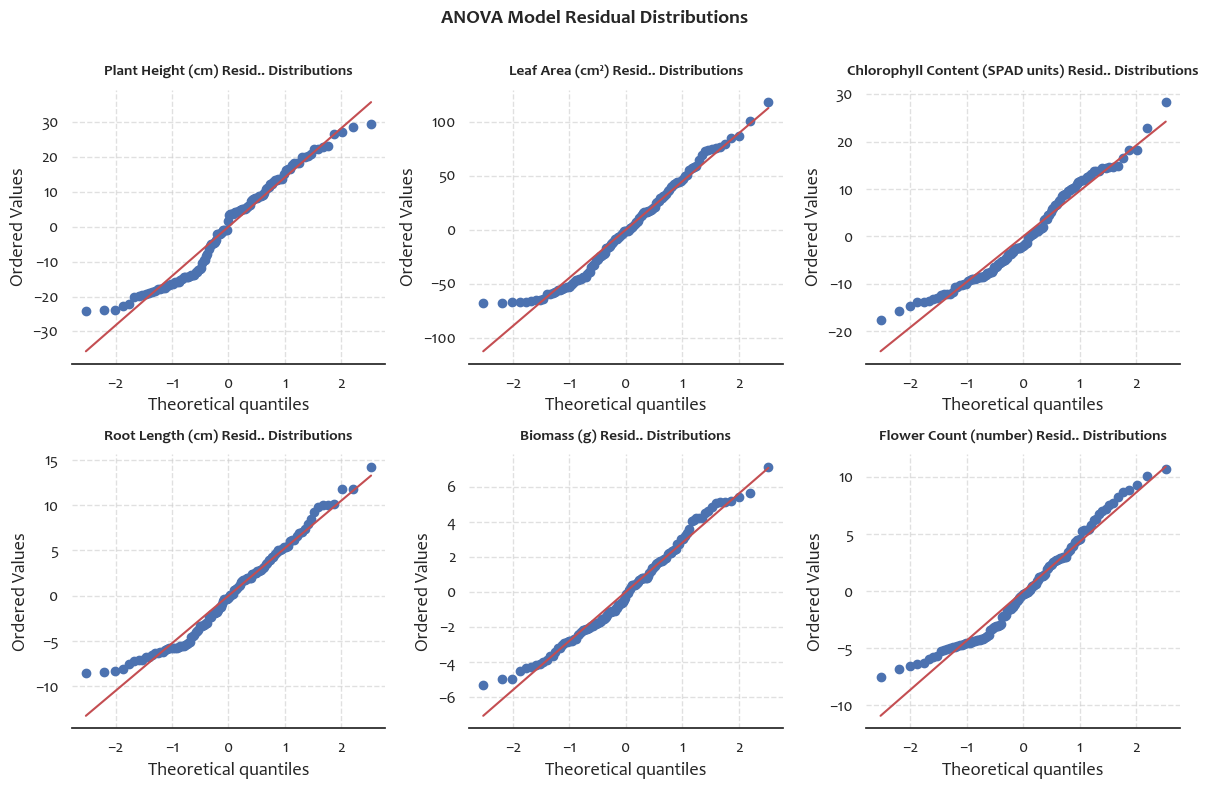

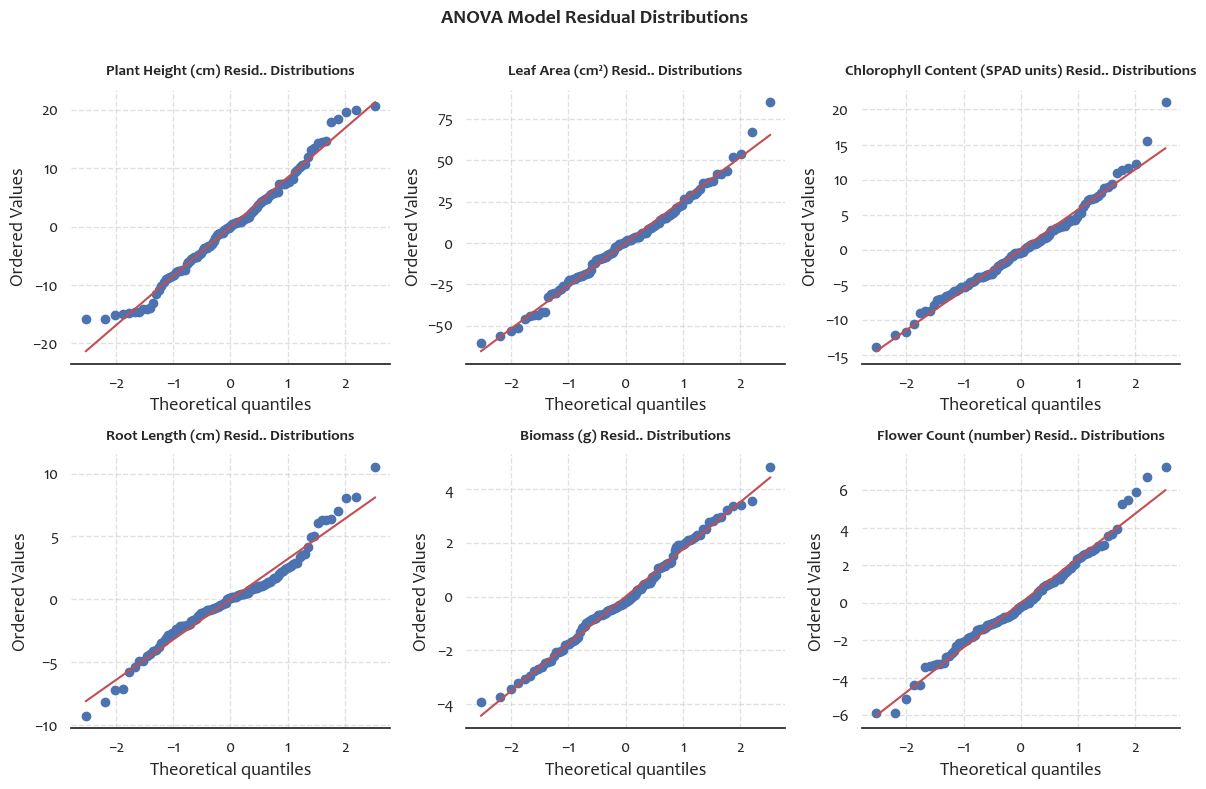

In [192]:
def starndardize_name(name): return re.sub(r'[^a-zA-Z]', '', name)

def model_residual(df, variable, group_col):
    renamed_group_col = starndardize_name(group_col)
    df = df.rename(columns={col: starndardize_name(col) for col in df.columns})
    column_name = starndardize_name(variable)  
    formula = f"{column_name} ~ C({renamed_group_col})" 
    model = smf.ols(formula, data=df).fit()
    return model.resid

def visualize_residual_qqplot(df, variables, group_col):
    num_variables = len(variables)
    rows = math.ceil(num_variables / 3)
    cols = min(num_variables, 3)
    
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4* rows))
    plt.rcParams.update({'font.family': 'Candara', 'font.style': 'normal', 'font.size': 10 })
    fig.suptitle("ANOVA Model Residual Distributions", fontsize=14, fontweight='bold')
    axes = axes.flatten() if num_variables > 1 else [axes]
    
    for idx, column in enumerate(variables):
        ax = axes[idx]
        residual = model_residual(df, column, group_col)
        stats.probplot(residual, dist="norm", plot=ax)
        axes[idx].set_title(f"{column} Resid.. Distributions", fontsize=11, pad=10, fontweight='bold')
        axes[idx].spines[['right', 'left', 'top']].set_visible(False)
        axes[idx].grid(linestyle='--', alpha=0.6)
    
    for idx in range(num_variables, len(axes)): fig.delaxes(axes[idx])
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()
    print(f"{'='*150}")

if __name__ == "__main__":
    ANALYSIS_METRICS = df.select_dtypes(include=[np.number]).columns[:6]
    FACTORS = ['Fertilizer', 'Light Exposure']
    for FACTOR in FACTORS:
        visualize_residual_qqplot(df, ANALYSIS_METRICS, FACTOR)

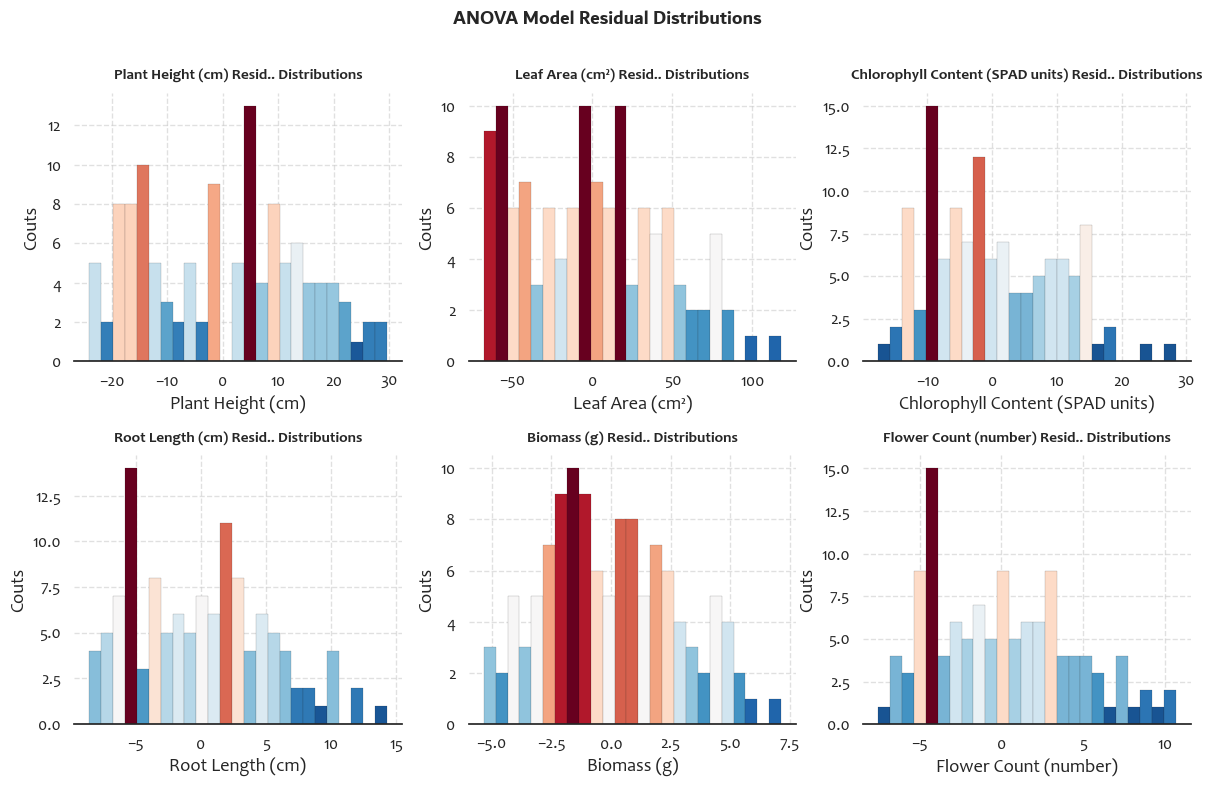

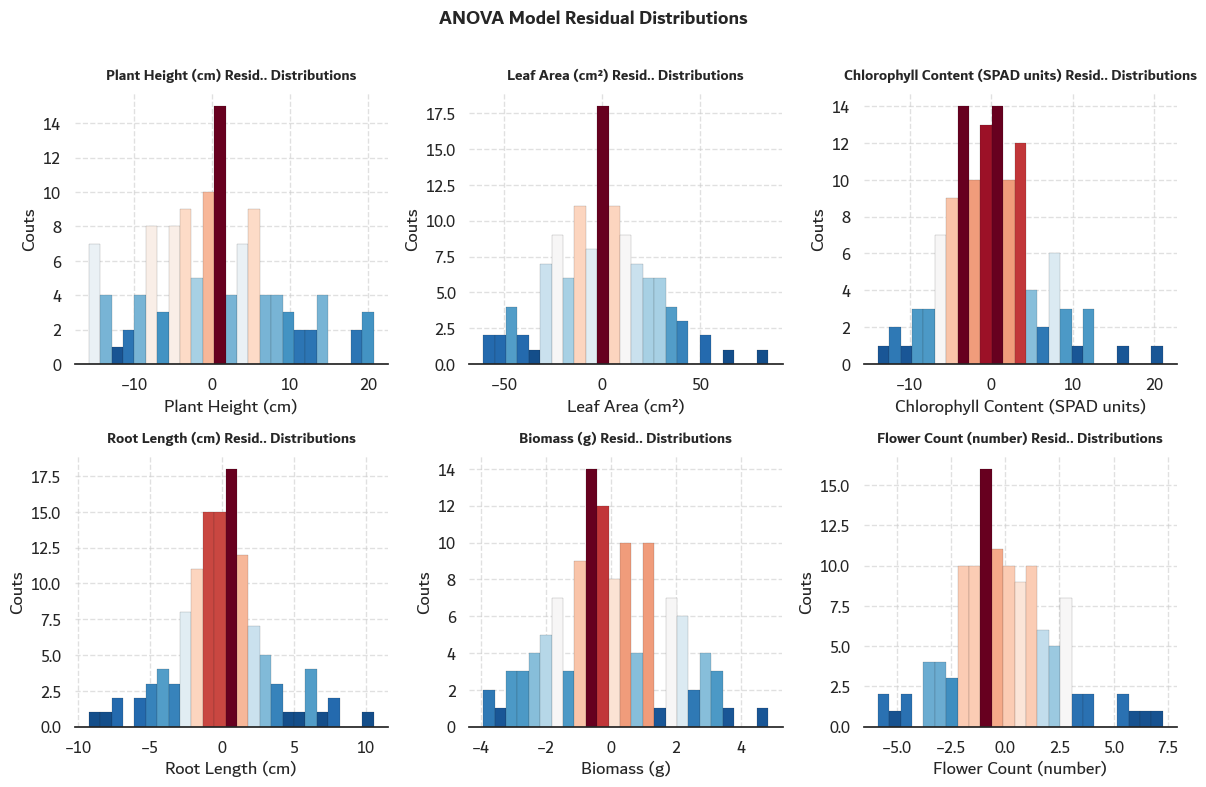

In [193]:
def visualize_histogram(df, Variables, group_col):
    num_variables = len(Variables)
    rows = math.ceil(num_variables / 3)
    cols = min(num_variables, 3)
    
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4* rows))
    plt.rcParams.update({'font.family': 'Dubai', 'font.style': 'normal', 'font.size': 11 })
    fig.suptitle("ANOVA Model Residual Distributions", fontsize=14, fontweight='bold')
    axes = axes.flatten() if num_variables > 1 else [axes]
    
    for idx, column in enumerate(Variables):
        residual = model_residual(df, column, group_col)
        n, bins, patches = axes[idx].hist(residual, bins=25, edgecolor='k', linewidth=0.1, alpha=1)
        for i in range(len(patches)): patches[i].set_facecolor(plt.cm.RdBu_r(n[i] / max(n)))
        axes[idx].set_title(f"{column} Resid.. Distributions", fontsize=11, pad=10, fontweight='bold')
        axes[idx].spines[['right', 'left', 'top']].set_visible(False)
        axes[idx].grid(linestyle='--', alpha=0.6)
        axes[idx].set_xlabel(column)
        axes[idx].set_ylabel('Couts')
    
    for idx in range(num_variables, len(axes)): fig.delaxes(axes[idx])
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()
    

if __name__ == "__main__":
    ANALYSIS_METRICS = df.select_dtypes(include=[np.number]).columns[:6]
    FACTORS = ['Fertilizer', 'Light Exposure']
    for FACTOR in FACTORS:
        visualize_histogram(df, ANALYSIS_METRICS, FACTOR)

<h2 style='font-size: 20px; font-family: Viner Hand ITC; font-weight: 600'>8.3: Welch's ANOVA (Welch's F test)</h2>


In [199]:
def starndardize_name(text): return re.sub(r'[^a-zA-Z]', "", text)
import pingouin as pg

def welchs_anova(data, variables, factors):
    results = []
    data = data.rename(columns={col: starndardize_name(col) for col in data.columns})
    
    for group in factors:
        for col in variables:
            column_name = starndardize_name(col)
            clean_factor = starndardize_name(group)
            aov = pg.welch_anova(data=data, dv=column_name, between=clean_factor)
            
            for _, row in aov.iterrows():
                p_value = row["p-unc"]
                interpretation = "Significant" if p_value < 0.05 else "Not Significant"
                results.append({
                    "Variable": col,
                    "Source of Variation": group.title(),
                    "df": row["ddof1"],
                    "F-Value": row["F"],
                    "p-Value": p_value,
                    "Significance": interpretation
                })

    return pd.DataFrame(results)


if __name__ == "__main__":
    FACTORS = ['Fertilizer', 'Light Exposure']
    ANALYSIS_METRICS = df.select_dtypes(include=[np.number]).columns.tolist()
    results = welchs_anova(df, ANALYSIS_METRICS, FACTORS)
    display(results)
    

Variable Source of Variation  df  F-Value  \
0                  Plant Height (cm)          Fertilizer   2     7.50   
1                    Leaf Area (cm²)          Fertilizer   2     4.67   
2   Chlorophyll Content (SPAD units)          Fertilizer   2     2.96   
3                   Root Length (cm)          Fertilizer   2     5.16   
4                        Biomass (g)          Fertilizer   2     6.57   
5              Flower Count (number)          Fertilizer   2     2.87   
6                     Seed Yield (g)          Fertilizer   2     4.40   
7   Stomatal Conductance (mmol/m²/s)          Fertilizer   2     5.69   
8                  Plant Height (cm)      Light Exposure   2   150.46   
9                    Leaf Area (cm²)      Light Exposure   2   146.72   
10  Chlorophyll Content (SPAD units)      Light Exposure   2   111.53   
11                  Root Length (cm)      Light Exposure   2   149.20   
12                       Biomass (g)      Light Exposure   2   110.28   
13             Flower Count (number)      Light Exposure   2   157.66   
14                    Seed Yield (g)      Light Exposure   2   162.98   
15  Stomatal Conductance (mmol/m²/s)      Light Exposure   2   120.16   

    p-Value     Significance  
0      0.00      Significant  
1      0.01      Significant  
2      0.06  Not Significant  
3      0.01      Significant  
4      0.00      Significant  
5      0.06  Not Significant  
6      0.02      Significant  
7      0.01      Significant  
8      0.00      Significant  
9      0.00      Significant  
10     0.00      Significant  
11     0.00      Significant  
12     0.00      Significant  
13     0.00      Significant  
14     0.00      Significant  
15     0.00      Significant

<h2 style='font-size: 20px; font-family: Viner Hand ITC; font-weight: 600'>8.4: Kruskal-Wallis Test</h2>

In [207]:
from scipy.stats import kruskal

def kruskall_wallis(df,  factors: list, variables: list = None):
    if variables is None:
        variables = df.select_dtypes(include=[np.number]).columns.tolist()
        for g in factors:
            if g in variables:
                variables.remove(g)
    results = []
    for group_column in factors:
        for column in variables:
            groups = [group[column].dropna().values for name, group in df.groupby(group_column)]
            stats, p_value = kruskal(*groups)
            interpretation = 'Significant' if p_value < 0.05 else 'Not Significant'
            results.append({
                'Source of Variation': group_column,
                'Variables': column,
                'Kruskal-Wallis Statistic': stats,
                'P-value': p_value,
                'Significant (α<0.05)': interpretation
            })
    return pd.DataFrame(results)

if __name__ == "__main__":
    FACTORS = ['Fertilizer', 'Light Exposure']
    ANALYSIS_METRICS = df.select_dtypes(include=[np.number]).columns.tolist()
    results = kruskall_wallis(df, FACTORS, ANALYSIS_METRICS)
    display(results)

Source of Variation                         Variables  \
0           Fertilizer                 Plant Height (cm)   
1           Fertilizer                   Leaf Area (cm²)   
2           Fertilizer  Chlorophyll Content (SPAD units)   
3           Fertilizer                  Root Length (cm)   
4           Fertilizer                       Biomass (g)   
5           Fertilizer             Flower Count (number)   
6           Fertilizer                    Seed Yield (g)   
7           Fertilizer  Stomatal Conductance (mmol/m²/s)   
8       Light Exposure                 Plant Height (cm)   
9       Light Exposure                   Leaf Area (cm²)   
10      Light Exposure  Chlorophyll Content (SPAD units)   
11      Light Exposure                  Root Length (cm)   
12      Light Exposure                       Biomass (g)   
13      Light Exposure             Flower Count (number)   
14      Light Exposure                    Seed Yield (g)   
15      Light Exposure  Stomatal Conductance (mmol/m²/s)   

    Kruskal-Wallis Statistic  P-value Significant (α<0.05)  
0                      10.12     0.01          Significant  
1                       4.22     0.12      Not Significant  
2                       3.65     0.16      Not Significant  
3                       5.81     0.05      Not Significant  
4                       6.04     0.05          Significant  
5                       2.76     0.25      Not Significant  
6                       5.47     0.06      Not Significant  
7                       7.39     0.02          Significant  
8                      85.28     0.00          Significant  
9                      88.00     0.00          Significant  
10                     85.70     0.00          Significant  
11                     84.80     0.00          Significant  
12                     83.72     0.00          Significant  
13                     93.66     0.00          Significant  
14                     90.90     0.00          Significant  
15                     82.54     0.00          Significant

<h1 style='font-family: Viner Hand ITC; font-size: 25px; font-weight: 600'>9.0: Post-Hoc Analysis</h1>

<H3 style='font-family: Viner Hand ITC; font-size: 20px; font-weight: 600'>9.1: Tukey's Honest Significant Difference (THSD)</H3>

In [215]:
def tukey_hsd_result(df: pd.DataFrame, variables, group):
    results_data = []
    for variable in variables:
        turkey_results = pairwise_tukeyhsd(endog=df[variable], groups=df[group], alpha=0.05)
        results_table = turkey_results.summary()
        
        for i in range(1, len(results_table)):
            row = results_table.data[i]
            results_data.append({
                "Factor": group,
                'Variable': variable,
                'Group1': row[0],
                'Group2': row[1],
                'Mean Diff.': row[2],
                'P-Value': row[3],
                'Lower CI': row[4],
                'Upper CI': row[5],
                'Reject Null': row[6]
            })
        
        result_df = pd.DataFrame(results_data)
    return result_df

if __name__ == "__main__":
    FACTOR = 'Fertilizer'
    ANALYSIS_METRICS = df.select_dtypes(include=[np.number]).columns.tolist()
    results = tukey_hsd_result(df, ANALYSIS_METRICS, FACTOR)
    display(results)

Factor                          Variable   Group1     Group2  \
0   Fertilizer                 Plant Height (cm)  Control    Organic   
1   Fertilizer                 Plant Height (cm)  Control  Synthetic   
2   Fertilizer                 Plant Height (cm)  Organic  Synthetic   
3   Fertilizer                   Leaf Area (cm²)  Control    Organic   
4   Fertilizer                   Leaf Area (cm²)  Control  Synthetic   
5   Fertilizer                   Leaf Area (cm²)  Organic  Synthetic   
6   Fertilizer  Chlorophyll Content (SPAD units)  Control    Organic   
7   Fertilizer  Chlorophyll Content (SPAD units)  Control  Synthetic   
8   Fertilizer  Chlorophyll Content (SPAD units)  Organic  Synthetic   
9   Fertilizer                  Root Length (cm)  Control    Organic   
10  Fertilizer                  Root Length (cm)  Control  Synthetic   
11  Fertilizer                  Root Length (cm)  Organic  Synthetic   
12  Fertilizer                       Biomass (g)  Control    Organic   
13  Fertilizer                       Biomass (g)  Control  Synthetic   
14  Fertilizer                       Biomass (g)  Organic  Synthetic   
15  Fertilizer             Flower Count (number)  Control    Organic   
16  Fertilizer             Flower Count (number)  Control  Synthetic   
17  Fertilizer             Flower Count (number)  Organic  Synthetic   
18  Fertilizer                    Seed Yield (g)  Control    Organic   
19  Fertilizer                    Seed Yield (g)  Control  Synthetic   
20  Fertilizer                    Seed Yield (g)  Organic  Synthetic   
21  Fertilizer  Stomatal Conductance (mmol/m²/s)  Control    Organic   
22  Fertilizer  Stomatal Conductance (mmol/m²/s)  Control  Synthetic   
23  Fertilizer  Stomatal Conductance (mmol/m²/s)  Organic  Synthetic   

    Mean Diff.  P-Value  Lower CI  Upper CI  Reject Null  
0       11.060    0.002     3.458    18.663         True  
1        7.283    0.061    -0.271    14.837        False  
2       -3.777    0.472   -11.426     3.872        False  
3       26.497    0.026     2.614    50.380         True  
4       16.602    0.225    -7.127    40.331        False  
5       -9.895    0.593   -33.923    14.133        False  
6        5.094    0.054    -0.065    10.254        False  
7        1.839    0.672    -3.287     6.966        False  
8       -3.255    0.300    -8.446     1.936        False  
9        3.183    0.022     0.369     5.998         True  
10       2.558    0.080    -0.238     5.354        False  
11      -0.625    0.860    -3.457     2.206        False  
12       1.649    0.026     0.159     3.139         True  
13       1.571    0.035     0.091     3.052         True  
14      -0.077    0.992    -1.577     1.422        False  
15       2.236    0.061    -0.083     4.556        False  
16       0.987    0.568    -1.317     3.292        False  
17      -1.249    0.415    -3.582     1.085        False  
18       0.730    0.069    -0.044     1.504        False  
19       0.751    0.057    -0.018     1.520        False  
20       0.021    0.998    -0.758     0.800        False  
21      35.363    0.011     6.637    64.089         True  
22      26.432    0.076    -2.109    54.973        False  
23      -8.931    0.744   -37.831    19.970        False

In [216]:
if __name__ == "__main__":
    FACTOR = 'Light Exposure'
    ANALYSIS_METRICS = df.select_dtypes(include=[np.number]).columns.tolist()
    results = tukey_hsd_result(df, ANALYSIS_METRICS, FACTOR)
    display(results)

Factor                          Variable      Group1  \
0   Light Exposure                 Plant Height (cm)  Full Shade   
1   Light Exposure                 Plant Height (cm)  Full Shade   
2   Light Exposure                 Plant Height (cm)    Full Sun   
3   Light Exposure                   Leaf Area (cm²)  Full Shade   
4   Light Exposure                   Leaf Area (cm²)  Full Shade   
5   Light Exposure                   Leaf Area (cm²)    Full Sun   
6   Light Exposure  Chlorophyll Content (SPAD units)  Full Shade   
7   Light Exposure  Chlorophyll Content (SPAD units)  Full Shade   
8   Light Exposure  Chlorophyll Content (SPAD units)    Full Sun   
9   Light Exposure                  Root Length (cm)  Full Shade   
10  Light Exposure                  Root Length (cm)  Full Shade   
11  Light Exposure                  Root Length (cm)    Full Sun   
12  Light Exposure                       Biomass (g)  Full Shade   
13  Light Exposure                       Biomass (g)  Full Shade   
14  Light Exposure                       Biomass (g)    Full Sun   
15  Light Exposure             Flower Count (number)  Full Shade   
16  Light Exposure             Flower Count (number)  Full Shade   
17  Light Exposure             Flower Count (number)    Full Sun   
18  Light Exposure                    Seed Yield (g)  Full Shade   
19  Light Exposure                    Seed Yield (g)  Full Shade   
20  Light Exposure                    Seed Yield (g)    Full Sun   
21  Light Exposure  Stomatal Conductance (mmol/m²/s)  Full Shade   
22  Light Exposure  Stomatal Conductance (mmol/m²/s)  Full Shade   
23  Light Exposure  Stomatal Conductance (mmol/m²/s)    Full Sun   

           Group2  Mean Diff.  P-Value  Lower CI  Upper CI  Reject Null  
0        Full Sun      28.996    0.000    24.607    33.385         True  
1   Partial Shade      18.389    0.000    13.874    22.904         True  
2   Partial Shade     -10.607    0.000   -15.223    -5.992         True  
3        Full Sun      90.449    0.000    77.015   103.883         True  
4   Partial Shade      49.897    0.000    36.078    63.716         True  
5   Partial Shade     -40.552    0.000   -54.678   -26.425         True  
6        Full Sun      19.145    0.000    16.152    22.137         True  
7   Partial Shade       8.740    0.000     5.662    11.818         True  
8   Partial Shade     -10.405    0.000   -13.552    -7.258         True  
9        Full Sun      10.316    0.000     8.629    12.002         True  
10  Partial Shade       6.317    0.000     4.583     8.052         True  
11  Partial Shade      -3.998    0.000    -5.771    -2.225         True  
12       Full Sun       5.479    0.000     4.567     6.390         True  
13  Partial Shade       2.830    0.000     1.892     3.767         True  
14  Partial Shade      -2.649    0.000    -3.607    -1.690         True  
15       Full Sun       8.898    0.000     7.655    10.140         True  
16  Partial Shade       4.531    0.000     3.252     5.809         True  
17  Partial Shade      -4.367    0.000    -5.674    -3.060         True  
18       Full Sun       2.983    0.000     2.566     3.400         True  
19  Partial Shade       1.643    0.000     1.214     2.072         True  
20  Partial Shade      -1.340    0.000    -1.778    -0.901         True  
21       Full Sun     106.663    0.000    89.482   123.843         True  
22  Partial Shade      61.523    0.000    43.849    79.196         True  
23  Partial Shade     -45.140    0.000   -63.206   -27.073         True

<h2 style='font-family: Viner Hand ITC; font-size: 20px; font-weight: 600'>9.2: Tukey's Honest Significant Difference (THSD) Results Visualization</h2>


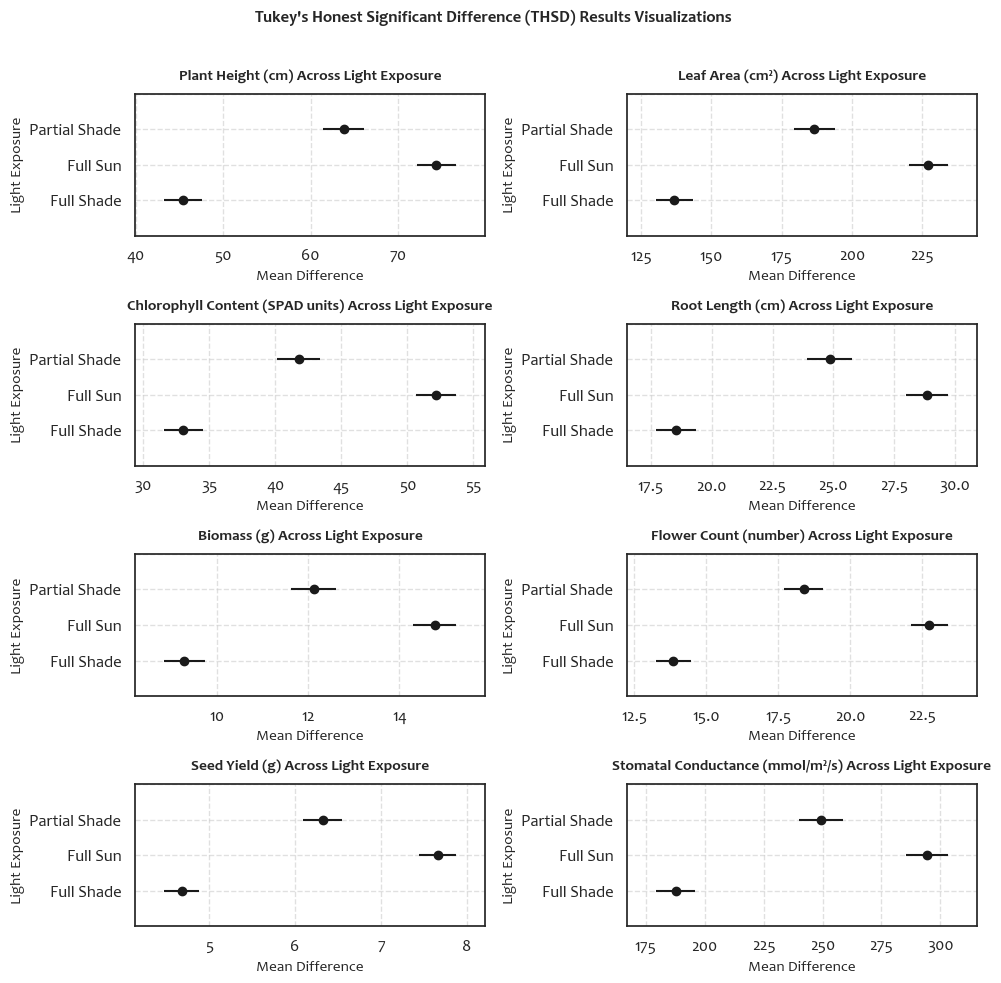

In [252]:
def plot_tukey_hsd(df, variables, group):
    
    num_variables = len(variables)
    rows = math.ceil(num_variables / 2)
    cols = min(num_variables, 2)

    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))
    plt.rcParams.update({'font.family': 'Candara', 'font.style': 'normal', 'font.size': 11})
    fig.suptitle("Tukey's Honest Significant Difference (THSD) Results Visualizations", fontsize=12, fontweight='bold')
    axes = axes.flatten() if num_variables > 1 else [axes]

    for idx, column in enumerate(variables):
        tukey_result = pairwise_tukeyhsd(df[column], df[group], alpha=0.05)
        tukey_result.plot_simultaneous(figsize=(10,10), ax=axes[idx])
        axes[idx].set_title(f"{column} Across {group}", fontsize=11, pad=10, fontweight='bold')
        axes[idx].set_xlabel("Mean Difference", fontsize=11)
        axes[idx].set_ylabel(group, fontsize=11)
        axes[idx].grid(linestyle="--", alpha=0.6)

    for idx in range(num_variables, len(axes)):fig.delaxes(axes[idx])
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()
    return fig
    
if __name__ == "__main__":
    FACTOR = 'Light Exposure'
    ANALYSIS_METRICS = df.select_dtypes(include=[np.number]).columns.tolist()
    fig = plot_tukey_hsd(df, ANALYSIS_METRICS, FACTOR)

<h2 style='font-family: Viner Hand ITC; font-size: 20px; font-weight: 600'>9.3: Compact Letter Display (CLD) Table</h2>

In [238]:
def letters(df, alpha=0.05):
    df["p-adj"] = df["p-adj"].astype(float)
    group1 = set(df.group1.tolist())
    group2 = set(df.group2.tolist())
    groupSet = group1 | group2
    groups = list(groupSet)
    letters = list(string.ascii_lowercase)[:len(groups)]
    cldgroups = letters
    cld = pd.DataFrame(list(zip(groups, letters, cldgroups)))
    cld[3] = ""
    
    for row in df.itertuples():
        if df["p-adj"][row[0]] > alpha:
            cld.loc[groups.index(df["group1"][row[0]]), 2] += cld.loc[groups.index(df["group2"][row[0]]), 1]
            cld.loc[groups.index(df["group2"][row[0]]), 2] += cld.loc[groups.index(df["group1"][row[0]]), 1]
        if df["p-adj"][row[0]] < alpha:
            cld.loc[groups.index(df["group1"][row[0]]), 3] += cld.loc[groups.index(df["group2"][row[0]]), 1]
            cld.loc[groups.index(df["group2"][row[0]]), 3] += cld.loc[groups.index(df["group1"][row[0]]), 1]
    
    cld[2] = cld[2].apply(lambda x: "".join(sorted(x)))
    cld[3] = cld[3].apply(lambda x: "".join(sorted(x)))
    cld.rename(columns={0: "groups"}, inplace=True)
    cld = cld.sort_values(cld.columns[2], key=lambda x: x.str.len())
    cld["labels"] = ""
    letters = list(string.ascii_lowercase)
    unique = []
    
    for item in cld[2]:
        for fitem in cld["labels"].unique():
            for c in range(len(fitem)):
                if not set(unique).issuperset(set(fitem[c])):
                    unique.append(fitem[c])
        g = len(unique)
        for kitem in cld[1]:
            if kitem in item:
                if cld.loc[cld[1] == kitem, "labels"].iloc[0] == "":
                    cld.loc[cld[1] == kitem, "labels"] += letters[g]
                if kitem in " ".join(cld.loc[cld["labels"] == letters[g], 3]):
                    g = len(unique) + 1
                if len(set(cld.loc[cld[1] == kitem, "labels"].iloc[0]).intersection(cld.loc[cld[2] == item, "labels"].iloc[0])) <= 0:
                    if letters[g] not in list(cld.loc[cld[1] == kitem, "labels"].iloc[0]):
                        cld.loc[cld[1] == kitem, "labels"] += letters[g]
                    if letters[g] not in list(cld.loc[cld[2] == item, "labels"].iloc[0]):
                        cld.loc[cld[2] == item, "labels"] += letters[g]
    
    cld = cld.sort_values("labels")
    cld.drop(columns=[1, 2, 3], inplace=True)
    cld = dict(zip(cld["groups"], cld["labels"]))
    return cld

In [246]:
def compute_cld_table(df, group, exclude_cols=None):
    if exclude_cols is None:
        exclude_cols = []

    numeric_cols = df.select_dtypes(include=[np.number]).columns
    numeric_cols = [col for col in numeric_cols if col not in exclude_cols]
    def calculate_stats_for_column(col_name):
        model = smf_ols(f'{col_name}~C({group})', data=df).fit()
        anova_results = anova_lm(model)
        p_value = anova_results.loc[f'C({group})', 'PR(>F)']
        tukey = pairwise_tukeyhsd(df[col_name], df[group])
        Turkey_results = pd.DataFrame(data=tukey._results_table.data[1:], columns=tukey._results_table.data[0])
        group_labels = letters(Turkey_results)
        stats = df.groupby(group)[col_name].agg(['mean', 'sem']).round(2)
        stats['letter'] = stats.index.map(group_labels)
        stats['formatted'] = stats.apply(
            lambda x: f"{x['mean']:.2f} ± {x['sem']:.2f} {x['letter']}", axis=1)
        
        return stats['formatted'], p_value
    results = {}
    p_values = {}
    for col in numeric_cols:
        results[col], p_values[col] = calculate_stats_for_column(col)
    
    results_df = pd.DataFrame(results)
    results_df.index.name = group
    p_values_formatted = {col: f"{p:.4f}" + ('***' if p <= 0.001 else '**' if p <= 0.01 else '*' if p <= 0.05 else 'ns') 
                         for col, p in p_values.items()}
    p_value_df = pd.DataFrame([p_values_formatted], index=['p-value'])
    final_results = pd.concat([results_df, p_value_df])
    return final_results
    
def cld_table(df, group, savepath=None):
    data = df.copy()
    group_col = starndardize_name(group)
    data.columns = data.columns.to_series().apply(starndardize_name)
    results_df = compute_cld_table(data, group=group_col)
    results_df_columns = df.select_dtypes(include=[np.number]).columns
    results_df.columns = results_df_columns
    return results_df

if __name__ == "__main__":
    FACTOR = 'Light Exposure'
    results = cld_table(df, FACTOR)
    display(results.T)

Full Shade         Full Sun  \
Plant Height (cm)                  45.39 ± 0.78 a   74.39 ± 1.81 c   
Leaf Area (cm²)                   136.79 ± 2.32 a  227.23 ± 5.95 c   
Chlorophyll Content (SPAD units)   33.02 ± 0.62 a   52.17 ± 1.18 c   
Root Length (cm)                   18.52 ± 0.26 a   28.84 ± 0.77 c   
Biomass (g)                         9.29 ± 0.16 a   14.77 ± 0.38 c   
Flower Count (number)              13.86 ± 0.21 a   22.76 ± 0.55 c   
Seed Yield (g)                      4.68 ± 0.07 a    7.66 ± 0.18 c   
Stomatal Conductance (mmol/m²/s)  187.67 ± 3.29 a  294.33 ± 7.03 c   

                                    Partial Shade    p-value  
Plant Height (cm)                  63.78 ± 1.30 b  0.0000***  
Leaf Area (cm²)                   186.68 ± 3.22 b  0.0000***  
Chlorophyll Content (SPAD units)   41.76 ± 0.88 b  0.0000***  
Root Length (cm)                   24.84 ± 0.37 b  0.0000***  
Biomass (g)                        12.12 ± 0.27 b  0.0000***  
Flower Count (number)              18.39 ± 0.30 b  0.0000***  
Seed Yield (g)                      6.32 ± 0.11 b  0.0000***  
Stomatal Conductance (mmol/m²/s)  249.19 ± 4.95 b  0.0000***

In [247]:
if __name__ == "__main__":
    FACTOR = 'Fertilizer'
    results = cld_table(df, FACTOR)
    display(results.T)

Control          Organic  \
Plant Height (cm)                  54.55 ± 1.58 a   65.61 ± 2.69 b   
Leaf Area (cm²)                   167.76 ± 4.32 a  194.26 ± 8.37 b   
Chlorophyll Content (SPAD units)   39.76 ± 1.12 a   44.85 ± 1.77 a   
Root Length (cm)                   21.97 ± 0.58 a   25.15 ± 1.03 b   
Biomass (g)                        10.91 ± 0.26 a   12.56 ± 0.47 b   
Flower Count (number)              17.13 ± 0.48 a   19.36 ± 0.82 a   
Seed Yield (g)                      5.68 ± 0.17 a    6.41 ± 0.26 a   
Stomatal Conductance (mmol/m²/s)  221.38 ± 6.67 a  256.74 ± 9.06 b   

                                         Synthetic   p-value  
Plant Height (cm)                  61.84 ± 2.42 ab  0.0028**  
Leaf Area (cm²)                   184.36 ± 8.09 ab   0.0316*  
Chlorophyll Content (SPAD units)    41.60 ± 1.67 a  0.0646ns  
Root Length (cm)                   24.53 ± 0.86 ab   0.0193*  
Biomass (g)                         12.48 ± 0.56 b   0.0137*  
Flower Count (number)               18.12 ± 0.75 a  0.0766ns  
Seed Yield (g)                       6.43 ± 0.25 a   0.0339*  
Stomatal Conductance (mmol/m²/s)  247.81 ± 9.74 ab   0.0113*

<h2 style='font-family:  Viner Hand ITC; font-size: 20px; font-weight: 600'>9.4: Compact Letter Display (CLD) Visualization</h2>


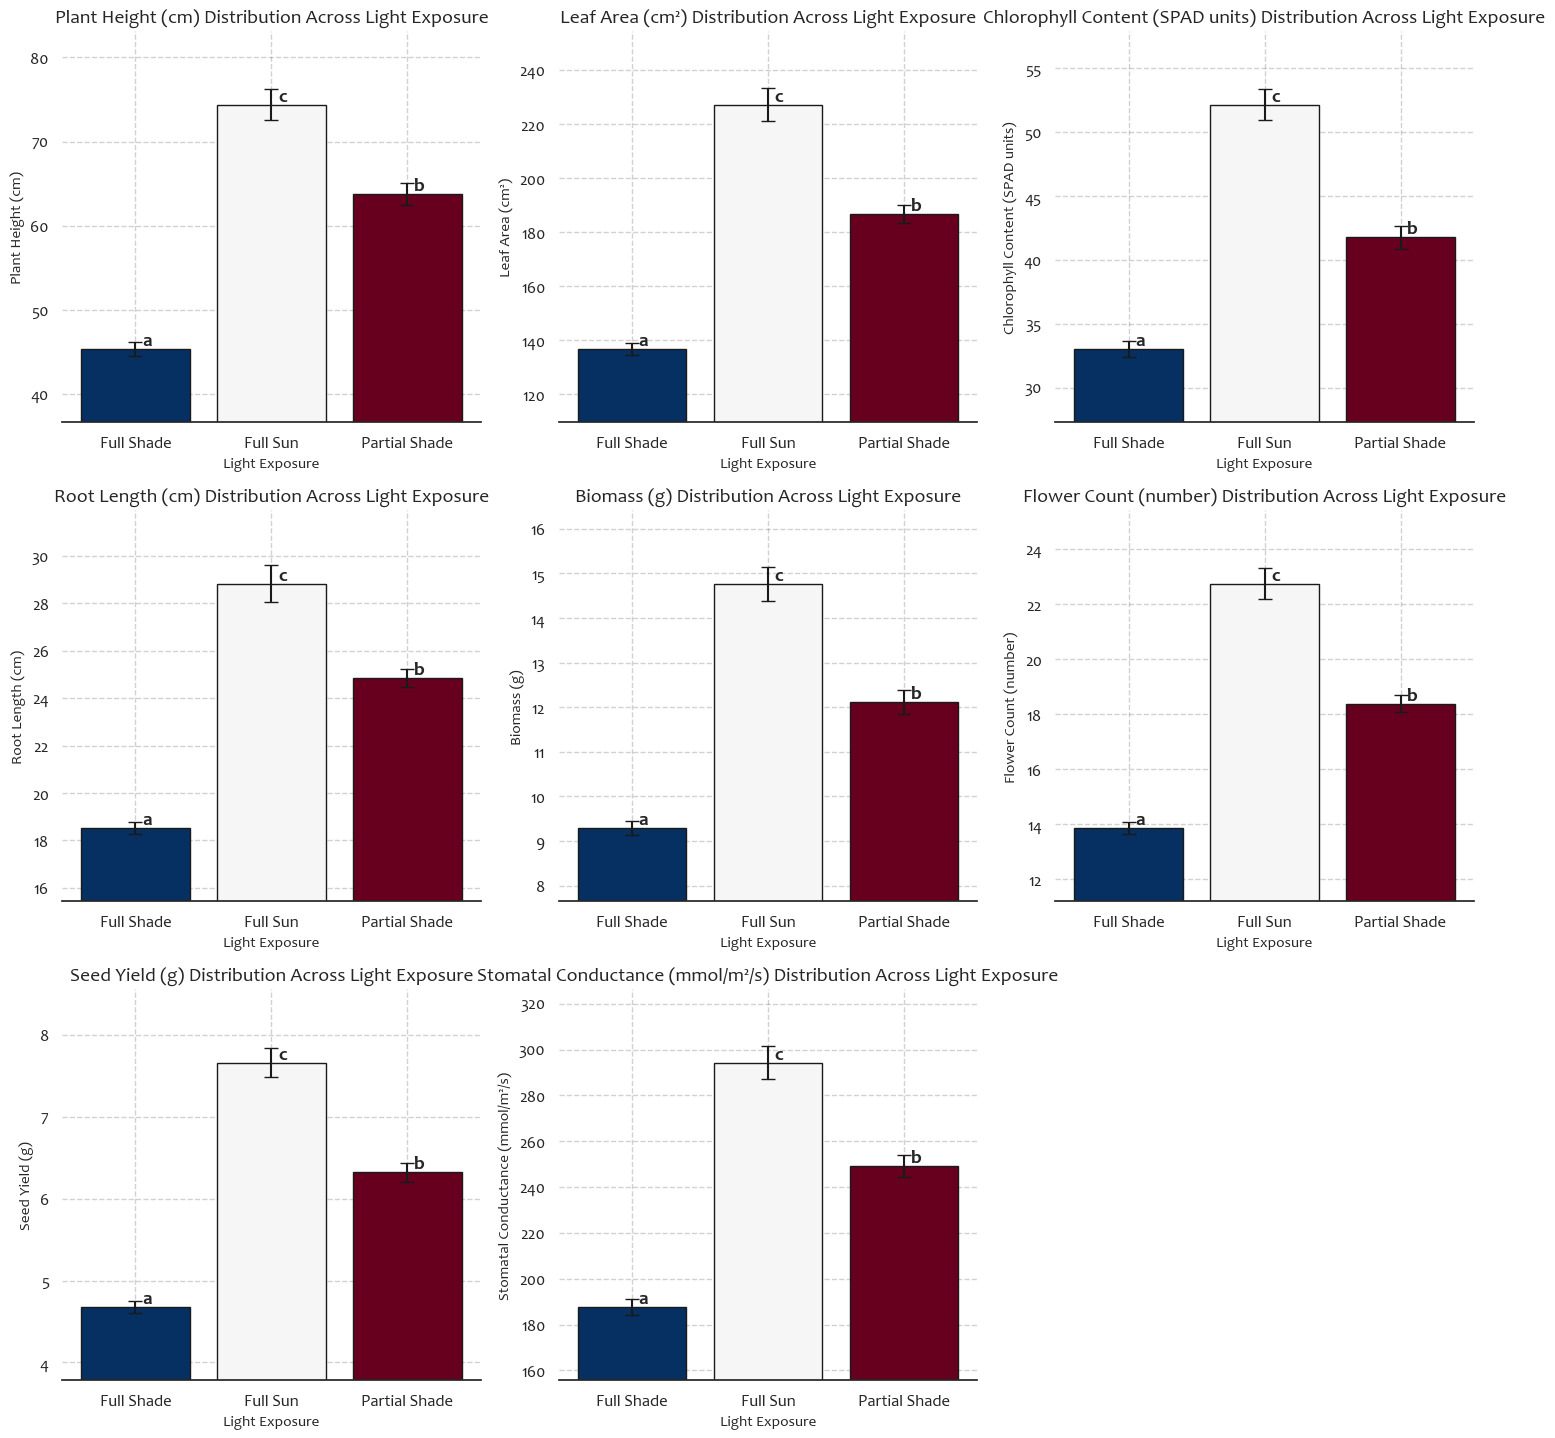

In [261]:
def set_smart_ylim(ax, data, scale_type='linear', buffer=0.05):
    data_min = np.nanmin(data)
    data_max = np.nanmax(data)
    
    if data_min == data_max:
        if data_min == 0:
            data_max = 1
        else:
            data_min *= 0.9
            data_max *= 1.1
    
    range_span = data_max - data_min
    data_min -= buffer * range_span
    data_max += buffer * range_span
    
    if scale_type == 'log':
        data_min = max(data_min, 1e-3)  # avoid log(0)
        ax.set_yscale('log')
    
    if scale_type == 'percent':
        data_min = max(0, data_min)
        data_max = min(100, data_max)
    
    ax.set_ylim(data_min, data_max)
    return ax

def get_tukey_results(df: pd.DataFrame, variable: str, group_column: str):
    tukey = pairwise_tukeyhsd(df[variable], groups=df[group_column])
    results = pd.DataFrame(tukey._results_table.data[1:], columns=tukey._results_table.data[0])
    group_labels = letters(results)
    agg_df = (df.groupby(group_column)[variable].agg(["mean", "sem"]).reset_index())
    return agg_df, group_labels

def compact_letters_plot(df, numerical_columns, group_column, ncols=3):
    num_vars = len(numerical_columns)
    cols = min(num_vars, ncols)
    rows = math.ceil(num_vars / cols)

    plt.rcParams.update({'font.family': 'Candara', 'font.style': 'normal', 'font.size': 12 })
    
    if num_vars == 1: fig, axes = plt.subplots(rows, cols, figsize=(9, 8))
    else:  fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))
    axes = np.array(axes).flatten() if num_vars > 1 else [axes]
    
    for idx, col in enumerate(numerical_columns):
        agg_df, group_labels = get_tukey_results(df, col, group_column)
        ax = axes[idx]
        error = np.full(len(agg_df), agg_df["sem"])
        colors = plt.cm.RdBu_r(np.linspace(0, 1, len(agg_df)))
        bars = ax.bar(agg_df[group_column], agg_df["mean"], yerr=error, color=colors, edgecolor='k', capsize=5)
        sns.despine(ax=ax, left=True, right=True, bottom=False)
        
        for bar, Letters in zip(bars, agg_df[group_column]):
            height = bar.get_height()
            ax.annotate(
                group_labels[Letters],
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(8, 0), 
                textcoords="offset points",
                ha="center", 
                va="bottom", 
                fontsize=14, 
                fontweight="bold"
            )
        
        ax = set_smart_ylim(ax,agg_df["mean"], scale_type='linear', buffer=0.3)
        ax.set_title(f"{col} Distribution Across {group_column}", fontsize=14)
        ax.grid(linestyle="--", alpha=0.2, color='k')
        ax.set_xlabel(group_column, fontsize=11)
        ax.set_ylabel(col, fontsize=11)
    for idx in range(num_vars, len(axes)): fig.delaxes(axes[idx]) 
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()
    return fig
    
if __name__ == "__main__":
    FACTOR = 'Light Exposure'
    ANALYSIS_METRICS = df.select_dtypes(include=[np.number]).columns.tolist()
    fig = compact_letters_plot(df, ANALYSIS_METRICS, FACTOR)

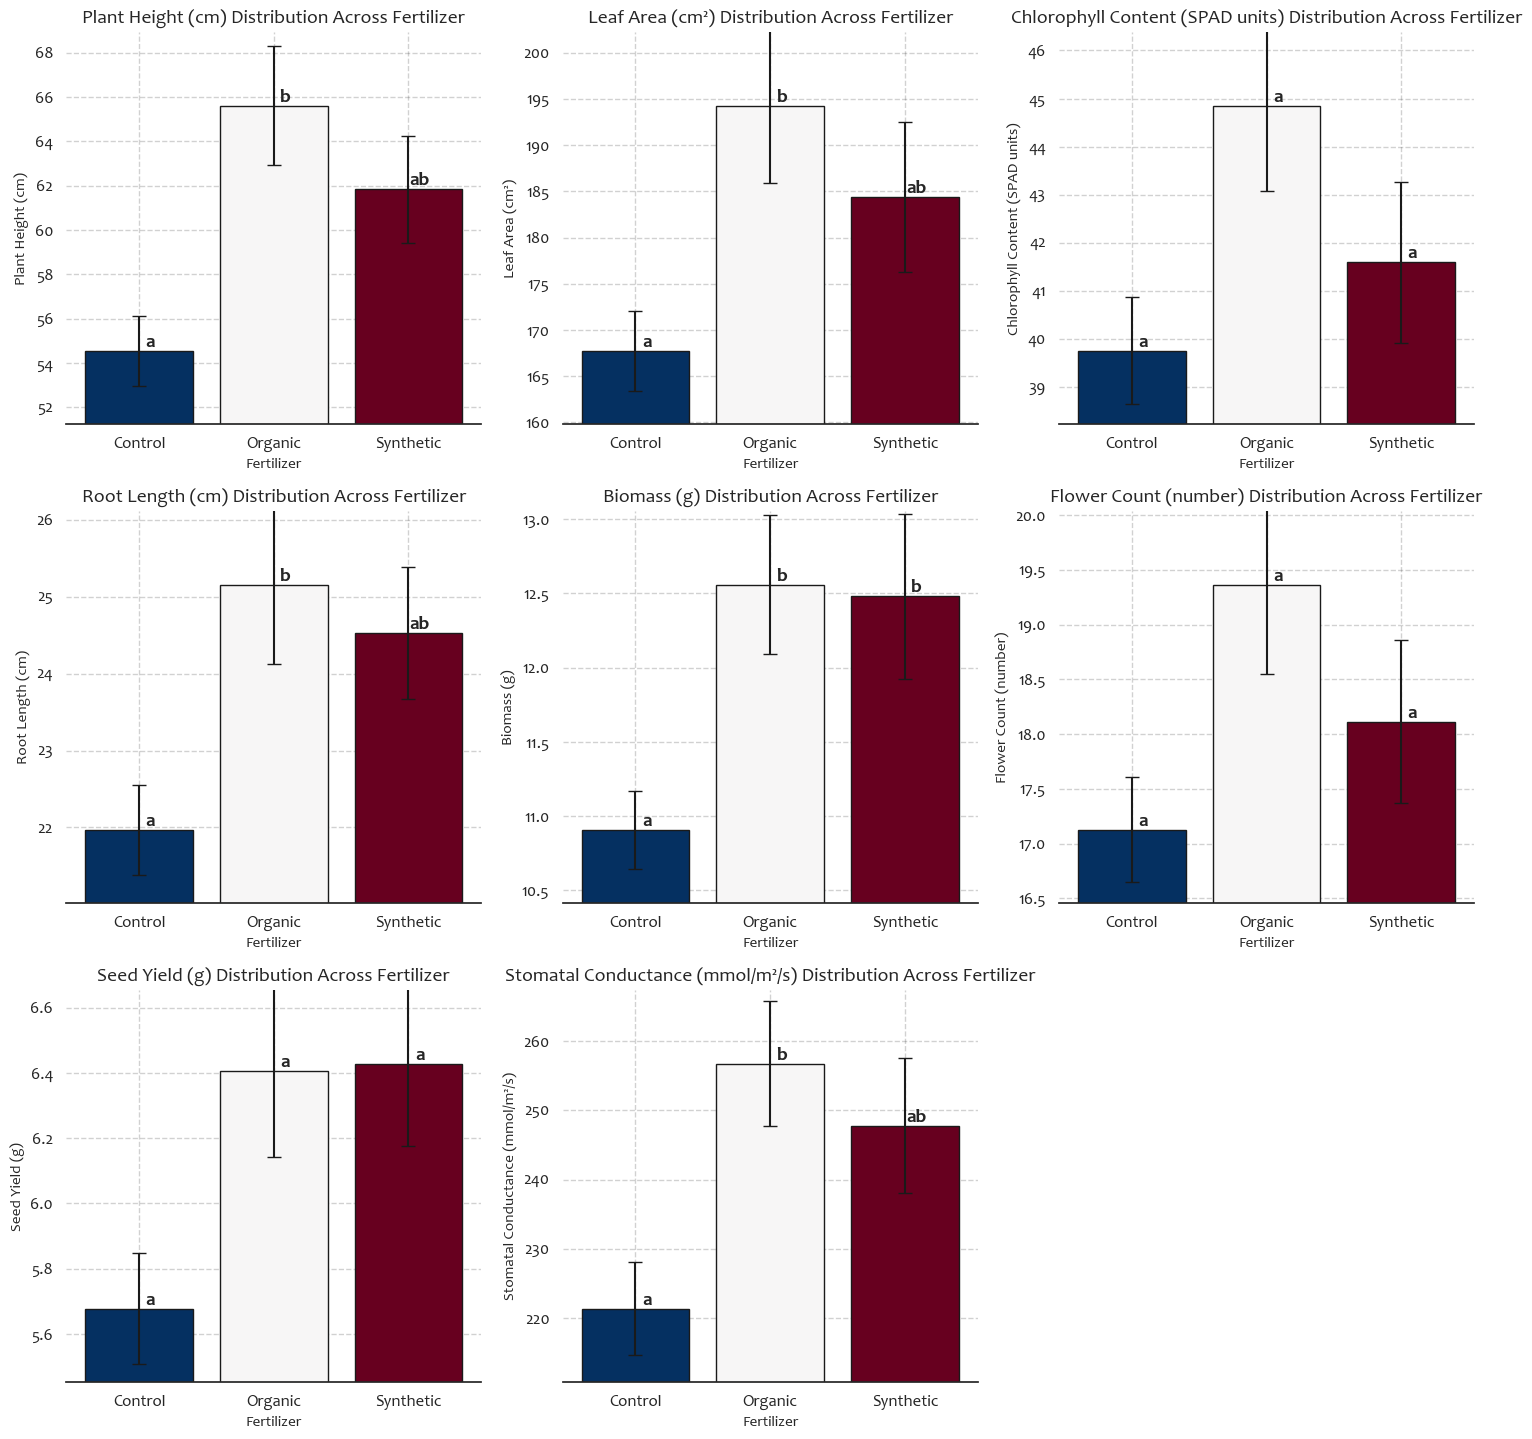

In [264]:
if __name__ == "__main__":
    FACTOR = 'Fertilizer'
    ANALYSIS_METRICS = df.select_dtypes(include=[np.number]).columns.tolist()
    fig = compact_letters_plot(df, ANALYSIS_METRICS, FACTOR)

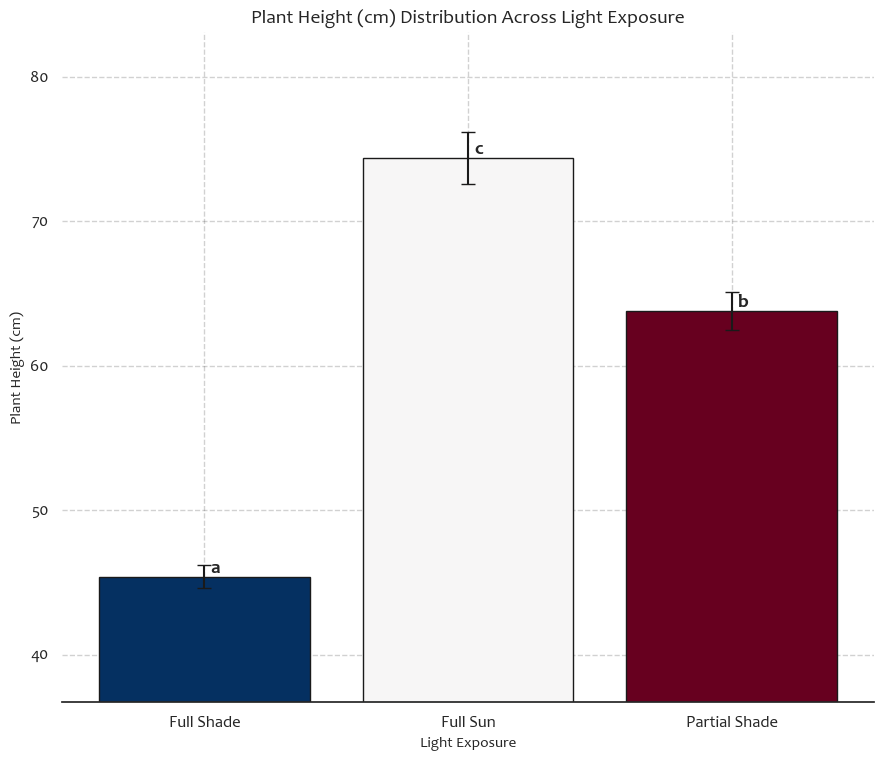

In [263]:
if __name__ == "__main__":
    FACTOR = 'Light Exposure'
    ANALYSIS_METRICS = df.select_dtypes(include=[np.number]).columns.tolist()[:1]
    for METRICS in ANALYSIS_METRICS:
        METRICS_LIST = [METRICS]
        fig = compact_letters_plot(df, METRICS_LIST, FACTOR)
        

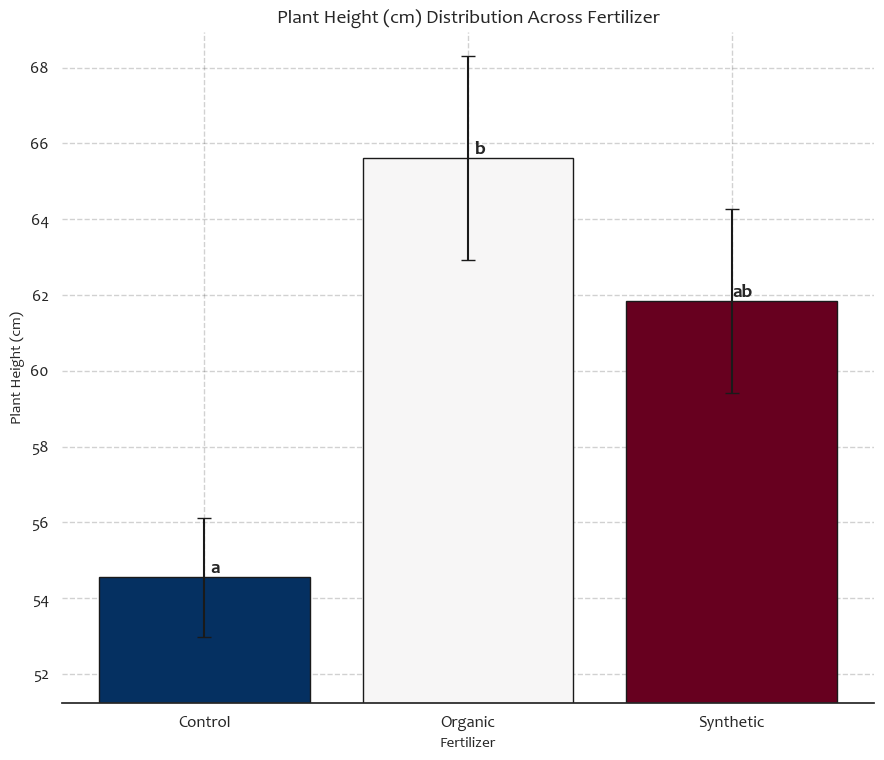

In [265]:
if __name__ == "__main__":
    FACTOR = 'Fertilizer'
    ANALYSIS_METRICS = df.select_dtypes(include=[np.number]).columns.tolist()[:1]
    for METRICS in ANALYSIS_METRICS:
        METRICS_LIST = [METRICS]
        fig = compact_letters_plot(df, METRICS_LIST, FACTOR)
        

<h1 style='font-family: French Script MT; font-size: 30px; font-weight: 600'>10.0: Quantifying Relationships and Magnitudes of an The effects</h1>

<H3 style='font-size: 25px; color: blue; font-family: French Script MT; font-weight: 600'>10.1: Partial Eta-squared (ηp²))</H3>

In [294]:
import re
import pandas as pd
import numpy as np
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm


def standardize_name(text: str) -> str:
    return re.sub(r'[^a-zA-Z]', "", text)


def interpret_p_value(p_value: float) -> str:
    if pd.isna(p_value):
        return "-"
    return "Significant" if p_value < 0.05 else "Not significant"


def interpret_eta_squared(eta_squared: float) -> str:
    if eta_squared >= 0.14:
        return "Large effect size (≥ 14%)"
    elif eta_squared >= 0.06:
        return "Medium effect size (6% - 14%)"
    else:
        return "Small effect size (< 6%)"


def compute_partial_eta_squared(df: pd.DataFrame, numerical_columns: list, factors: list) -> pd.DataFrame:
    # Standardize all column names once
    df = df.rename(columns={col: standardize_name(col) for col in df.columns})
    factors = [standardize_name(f) for f in factors]
    numerical_columns = [standardize_name(c) for c in numerical_columns]

    results = []

    # Loop through dependent vars (numerical) and independent vars (factors)
    for dep_var in numerical_columns:
        for factor in factors:
            formula = f'{dep_var} ~ C({factor})'
            model = ols(formula, data=df).fit()
            anova_table = anova_lm(model, typ=2)

            # Compute ηp² for this factor
            SS_factor = anova_table.loc[f'C({factor})', 'sum_sq']
            SS_error = anova_table.loc['Residual', 'sum_sq']
            partial_eta_squared = SS_factor / (SS_factor + SS_error)

            # Store results
            for source, row in anova_table.iterrows():
                results.append({
                    "Variable": dep_var,
                    "Source": source,
                    "Sum Sq": row["sum_sq"],
                    "df": row["df"],
                    "F-Value": row["F"],
                    "p-Value": row["PR(>F)"],
                    "Significance (α<0.05)": interpret_p_value(row["PR(>F)"]),
                    "Partial Eta-squared (ηp²)": partial_eta_squared
                })

    # Create results dataframe
    eta_squared_df = pd.DataFrame(results).fillna('-')
    eta_squared_df['Interpretation'] = eta_squared_df['Partial Eta-squared (ηp²)'].apply(
        lambda x: interpret_eta_squared(x) if isinstance(x, (int, float)) else "-"
    )
    return eta_squared_df

if __name__ == "__main__":
    FACTORS = ['Fertilizer', 'Light Exposure']
    ANALYSIS_METRICS = df.select_dtypes(include=[np.number]).columns.tolist()
    results = compute_partial_eta_squared(df, ANALYSIS_METRICS, FACTORS)
    display(results)

Variable            Source    Sum Sq     df F-Value  \
0                 PlantHeightcm     C(Fertilizer)   2540.40   2.00    6.20   
1                 PlantHeightcm          Residual  23984.47 117.00       -   
2                 PlantHeightcm  C(LightExposure)  18145.50   2.00  126.68   
3                 PlantHeightcm          Residual   8379.37 117.00       -   
4                    LeafAreacm     C(Fertilizer)  14394.90   2.00    3.56   
5                    LeafAreacm          Residual 236693.54 117.00       -   
6                    LeafAreacm  C(LightExposure) 172586.54   2.00  128.61   
7                    LeafAreacm          Residual  78501.90 117.00       -   
8   ChlorophyllContentSPADunits     C(Fertilizer)    529.81   2.00    2.81   
9   ChlorophyllContentSPADunits          Residual  11047.89 117.00       -   
10  ChlorophyllContentSPADunits  C(LightExposure)   7682.98   2.00  115.40   
11  ChlorophyllContentSPADunits          Residual   3894.72 117.00       -   
12                 RootLengthcm     C(Fertilizer)    229.57   2.00    4.09   
13                 RootLengthcm          Residual   3286.71 117.00       -   
14                 RootLengthcm  C(LightExposure)   2279.30   2.00  107.80   
15                 RootLengthcm          Residual   1236.97 117.00       -   
16                     Biomassg     C(Fertilizer)     70.05   2.00    4.45   
17                     Biomassg          Residual    921.36 117.00       -   
18                     Biomassg  C(LightExposure)    630.13   2.00  102.03   
19                     Biomassg          Residual    361.28 117.00       -   
20            FlowerCountnumber     C(Fertilizer)    100.21   2.00    2.63   
21            FlowerCountnumber          Residual   2232.52 117.00       -   
22            FlowerCountnumber  C(LightExposure)   1660.98   2.00  144.65   
23            FlowerCountnumber          Residual    671.75 117.00       -   
24                   SeedYieldg     C(Fertilizer)     14.81   2.00    3.49   
25                   SeedYieldg          Residual    248.58 117.00       -   
26                   SeedYieldg  C(LightExposure)    187.74   2.00  145.19   
27                   SeedYieldg          Residual     75.65 117.00       -   
28    StomatalConductancemmolms     C(Fertilizer)  27248.35   2.00    4.66   
29    StomatalConductancemmolms          Residual 342422.36 117.00       -   
30    StomatalConductancemmolms  C(LightExposure) 241275.13   2.00  109.93   
31    StomatalConductancemmolms          Residual 128395.58 117.00       -   

   p-Value Significance (α<0.05)  Partial Eta-squared (ηp²)  \
0     0.00           Significant                       0.10   
1        -                     -                       0.10   
2     0.00           Significant                       0.68   
3        -                     -                       0.68   
4     0.03           Significant                       0.06   
5        -                     -                       0.06   
6     0.00           Significant                       0.69   
7        -                     -                       0.69   
8     0.06       Not significant                       0.05   
9        -                     -                       0.05   
10    0.00           Significant                       0.66   
11       -                     -                       0.66   
12    0.02           Significant                       0.07   
13       -                     -                       0.07   
14    0.00           Significant                       0.65   
15       -                     -                       0.65   
16    0.01           Significant                       0.07   
17       -                     -                       0.07   
18    0.00           Significant                       0.64   
19       -                     -                       0.64   
20    0.08       Not significant                       0.04   
21       -                     -                       0.04   

<H3 style='font-size: 25px; color: Blue; font-family: French Script MT; font-weight: 600'>10.2. Eta-squared (η²)</H3>

In [296]:
import re
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols

def standardize_name(text: str) -> str:
    """Remove non-alphabetic characters from a string for safe column names."""
    return re.sub(r'[^a-zA-Z]', "", text)


def calculate_eta_squared(aov_table: pd.DataFrame) -> float:
    """
    Calculate eta-squared (η²) from an ANOVA table.
    η² = SS_between / SS_total
    """
    ss_between = aov_table["sum_sq"].iloc[0]
    ss_total = aov_table["sum_sq"].sum()
    return ss_between / ss_total


def perform_anova_and_calculate_eta(df: pd.DataFrame, metrics: list, factors: list) -> pd.DataFrame:
    # Standardize column and factor names once
    df = df.rename(columns={col: standardize_name(col) for col in df.columns})
    factors = [standardize_name(f) for f in factors]

    results = []

    for metric in metrics:
        metric_name = standardize_name(metric)
        formula = f'{metric_name} ~ ' + ' + '.join([f'C({f})' for f in factors])
        model = ols(formula, data=df).fit()
        aov_table = sm.stats.anova_lm(model, typ=2)

        # Calculate eta-squared for the first factor only
        eta_sq = calculate_eta_squared(aov_table)
        aov_table["Eta-squared (η²)"] = np.nan
        aov_table.loc[aov_table.index[0], "Eta-squared (η²)"] = eta_sq

        # Format results
        anova_df = aov_table.reset_index().rename(columns={"index": "Source"})
        anova_df.insert(0, "Metric", metric)
        results.append(anova_df)

    return pd.concat(results, ignore_index=True).fillna('-')


if __name__ == "__main__":
    FACTORS = ['Fertilizer', 'Light Exposure']
    ANALYSIS_METRICS = df.select_dtypes(include=[np.number]).columns.tolist()
    
    results = perform_anova_and_calculate_eta(df, ANALYSIS_METRICS, FACTORS)
    display(results)


Metric            Source    sum_sq     df  \
0                  Plant Height (cm)     C(Fertilizer)   3092.83   2.00   
1                  Plant Height (cm)  C(LightExposure)  18697.92   2.00   
2                  Plant Height (cm)          Residual   5286.55 115.00   
3                    Leaf Area (cm²)     C(Fertilizer)  19516.70   2.00   
4                    Leaf Area (cm²)  C(LightExposure) 177708.34   2.00   
5                    Leaf Area (cm²)          Residual  58985.20 115.00   
6   Chlorophyll Content (SPAD units)     C(Fertilizer)    772.91   2.00   
7   Chlorophyll Content (SPAD units)  C(LightExposure)   7926.07   2.00   
8   Chlorophyll Content (SPAD units)          Residual   3121.81 115.00   
9                   Root Length (cm)     C(Fertilizer)    293.04   2.00   
10                  Root Length (cm)  C(LightExposure)   2342.78   2.00   
11                  Root Length (cm)          Residual    943.93 115.00   
12                       Biomass (g)     C(Fertilizer)     93.06   2.00   
13                       Biomass (g)  C(LightExposure)    653.14   2.00   
14                       Biomass (g)          Residual    268.23 115.00   
15             Flower Count (number)     C(Fertilizer)    145.20   2.00   
16             Flower Count (number)  C(LightExposure)   1705.96   2.00   
17             Flower Count (number)          Residual    526.55 115.00   
18                    Seed Yield (g)     C(Fertilizer)     20.10   2.00   
19                    Seed Yield (g)  C(LightExposure)    193.04   2.00   
20                    Seed Yield (g)          Residual     55.54 115.00   
21  Stomatal Conductance (mmol/m²/s)     C(Fertilizer)  35092.48   2.00   
22  Stomatal Conductance (mmol/m²/s)  C(LightExposure) 249119.26   2.00   
23  Stomatal Conductance (mmol/m²/s)          Residual  93303.10 115.00   

        F PR(>F) Eta-squared (η²)  
0   33.64   0.00             0.11  
1  203.37   0.00                -  
2       -      -                -  
3   19.03   0.00             0.08  
4  173.23   0.00                -  
5       -      -                -  
6   14.24   0.00             0.07  
7  145.99   0.00                -  
8       -      -                -  
9   17.85   0.00             0.08  
10 142.71   0.00                -  
11      -      -                -  
12  19.95   0.00             0.09  
13 140.01   0.00                -  
14      -      -                -  
15  15.86   0.00             0.06  
16 186.29   0.00                -  
17      -      -                -  
18  20.81   0.00             0.07  
19 199.84   0.00                -  
20      -      -                -  
21  21.63   0.00             0.09  
22 153.52   0.00                -  
23      -      -                -

<H3 style='font-size: 25px; color: blue; font-family: French Script MT; font-weight: 600'>10.3. Cohen's d</H3>

In [305]:
import numpy as np
import pandas as pd
from itertools import combinations

def cohens_d(group1: np.ndarray, group2: np.ndarray) -> float:
    mean_diff = np.mean(group1) - np.mean(group2)
    pooled_std = np.sqrt((np.var(group1, ddof=1) + np.var(group2, ddof=1)) / 2)
    return mean_diff / pooled_std

def interpret_cohens_d(d_value: float) -> str:
    d_abs = abs(d_value)
    if d_abs < 0.2: return "Small effect size"
    elif d_abs < 0.5: return "Medium effect size"
    elif d_abs < 0.8: return "Large effect size"
    else: return "Very large effect size"


def calculate_effect_sizes(df: pd.DataFrame, group_column: str, numerical_columns: list) -> pd.DataFrame:
    results = []
    group_values = df[group_column].unique()
    for column in numerical_columns:
        for g1, g2 in combinations(group_values, 2):
            group1 = df[df[group_column] == g1][column]
            group2 = df[df[group_column] == g2][column]

            d_value = cohens_d(group1, group2)
            results.append({
                'Column': column,
                'Factor': group_column,
                'Group 1': f'{g1}',
                'Group 2': f'{g2}',
                'Meam Diff..': group1.mean() - group2.mean(),
                "Cohen's d": d_value,
                'Interpretation': interpret_cohens_d(d_value)
            })

    return pd.DataFrame(results)

if __name__ == "__main__":
    FACTOR = 'Fertilizer'
    ANALYSIS_METRICS = df.select_dtypes(include=[np.number]).columns.tolist()[:4]
    results = calculate_effect_sizes(df, FACTOR, ANALYSIS_METRICS)
    display(results)

Column      Factor  Group 1    Group 2  \
0                  Plant Height (cm)  Fertilizer  Control    Organic   
1                  Plant Height (cm)  Fertilizer  Control  Synthetic   
2                  Plant Height (cm)  Fertilizer  Organic  Synthetic   
3                    Leaf Area (cm²)  Fertilizer  Control    Organic   
4                    Leaf Area (cm²)  Fertilizer  Control  Synthetic   
5                    Leaf Area (cm²)  Fertilizer  Organic  Synthetic   
6   Chlorophyll Content (SPAD units)  Fertilizer  Control    Organic   
7   Chlorophyll Content (SPAD units)  Fertilizer  Control  Synthetic   
8   Chlorophyll Content (SPAD units)  Fertilizer  Organic  Synthetic   
9                   Root Length (cm)  Fertilizer  Control    Organic   
10                  Root Length (cm)  Fertilizer  Control  Synthetic   
11                  Root Length (cm)  Fertilizer  Organic  Synthetic   

    Meam Diff..  Cohen's d      Interpretation  
0        -11.06      -0.80   Large effect size  
1         -7.28      -0.56   Large effect size  
2          3.78       0.23  Medium effect size  
3        -26.50      -0.63   Large effect size  
4        -16.60      -0.40  Medium effect size  
5          9.89       0.19   Small effect size  
6         -5.09      -0.55   Large effect size  
7         -1.84      -0.20  Medium effect size  
8          3.26       0.30  Medium effect size  
9         -3.18      -0.60   Large effect size  
10        -2.56      -0.55   Large effect size  
11         0.63       0.10   Small effect size

<h3 style='font-size: 25px; color: Blue; font-family: French Script MT; font-weight: 600'>10.4: Regression Analysis</h3>

In [312]:
import re
import pandas as pd
from typing import List
from statsmodels.formula.api import ols


def standardize_column_name(name: str) -> str:
    return re.sub(r'[^a-zA-Z]', '', name)


def regression_analysis(df: pd.DataFrame, dependent_vars: List[str], group_cols: List[str]) -> pd.DataFrame:
    results = []

    df_clean = df.rename(columns={col: standardize_column_name(col) for col in df.columns})
    dep_vars_clean = [standardize_column_name(col) for col in dependent_vars]
    group_cols_clean = [standardize_column_name(col) for col in group_cols]

    for dep_var in dep_vars_clean:
        for factor in group_cols_clean:
            formula = f"{dep_var} ~ C({factor})"
            model = ols(formula, data=df_clean).fit()
            coef_table = model.summary2().tables[1]

            intercept = model.params.get('Intercept', None)

            for index, row in coef_table.iterrows():
                # Safe percentage difference calculation
                perct_diff = None
                if intercept and intercept != 0:
                    perct_diff = (row["Coef."] / intercept) * 100

                results.append({
                    "Dependent Variable": dep_var,
                    "Factor": factor,
                    "Term": index,
                    "Coefficient": row["Coef."],
                    "Std. Error": row["Std.Err."],
                    "t-Value": row["t"],
                    "p-Value": row["P>|t|"],
                    "95% CI Lower": row["[0.025"],
                    "95% CI Upper": row["0.975]"],
                    "Percentage Diff (%)": perct_diff
                })

    return pd.DataFrame(results).sort_values(
        by=["Dependent Variable", "Factor"]
    ).reset_index(drop=True)


if __name__ == "__main__":
    group_cols = ['Fertilizer', 'Light Exposure']   # categorical predictors
    dependent_vars = df.select_dtypes(include=[float, int]).columns.tolist()[:4]
    regression_results = regression_analysis(df, dependent_vars, group_cols)
    display(regression_results)


Dependent Variable         Factor  \
0   ChlorophyllContentSPADunits     Fertilizer   
1   ChlorophyllContentSPADunits     Fertilizer   
2   ChlorophyllContentSPADunits     Fertilizer   
3   ChlorophyllContentSPADunits  LightExposure   
4   ChlorophyllContentSPADunits  LightExposure   
5   ChlorophyllContentSPADunits  LightExposure   
6                    LeafAreacm     Fertilizer   
7                    LeafAreacm     Fertilizer   
8                    LeafAreacm     Fertilizer   
9                    LeafAreacm  LightExposure   
10                   LeafAreacm  LightExposure   
11                   LeafAreacm  LightExposure   
12                PlantHeightcm     Fertilizer   
13                PlantHeightcm     Fertilizer   
14                PlantHeightcm     Fertilizer   
15                PlantHeightcm  LightExposure   
16                PlantHeightcm  LightExposure   
17                PlantHeightcm  LightExposure   
18                 RootLengthcm     Fertilizer   
19                 RootLengthcm     Fertilizer   
20                 RootLengthcm     Fertilizer   
21                 RootLengthcm  LightExposure   
22                 RootLengthcm  LightExposure   
23                 RootLengthcm  LightExposure   

                                 Term  Coefficient  Std. Error  t-Value  \
0                           Intercept        39.76        1.52    26.20   
1            C(Fertilizer)[T.Organic]         5.09        2.17     2.34   
2          C(Fertilizer)[T.Synthetic]         1.84        2.16     0.85   
3                           Intercept        33.02        0.87    37.96   
4        C(LightExposure)[T.Full Sun]        19.14        1.26    15.19   
5   C(LightExposure)[T.Partial Shade]         8.74        1.30     6.74   
6                           Intercept       167.76        7.02    23.88   
7            C(Fertilizer)[T.Organic]        26.50       10.06     2.63   
8          C(Fertilizer)[T.Synthetic]        16.60       10.00     1.66   
9                           Intercept       136.79        3.90    35.03   
10       C(LightExposure)[T.Full Sun]        90.45        5.66    15.98   
11  C(LightExposure)[T.Partial Shade]        49.90        5.82     8.57   
12                          Intercept        54.55        2.24    24.40   
13           C(Fertilizer)[T.Organic]        11.06        3.20     3.45   
14         C(Fertilizer)[T.Synthetic]         7.28        3.18     2.29   
15                          Intercept        45.39        1.28    35.58   
16       C(LightExposure)[T.Full Sun]        29.00        1.85    15.68   
17  C(LightExposure)[T.Partial Shade]        18.39        1.90     9.67   
18                          Intercept        21.97        0.83    26.54   
19           C(Fertilizer)[T.Organic]         3.18        1.19     2.69   
20         C(Fertilizer)[T.Synthetic]         2.56        1.18     2.17   
21                          Intercept        18.52        0.49    37.79   
22       C(LightExposure)[T.Full Sun]        10.32        0.71    14.52   
23  C(LightExposure)[T.Partial Shade]         6.32        0.73     8.65   

    p-Value  95% CI Lower  95% CI Upper  Percentage Diff (%)  
0      0.00         36.75         42.76               100.00  
1      0.02          0.79          9.40                12.81  
2      0.40         -2.44          6.12                 4.63  
3      0.00         31.30         34.74               100.00  
4      0.00         16.65         21.64                57.98  
5      0.00          6.17         11.31                26.47  
6      0.00        153.85        181.67               100.00  
7      0.01          6.57         46.42                15.79  
8      0.10         -3.19         36.40                 9.90  
9      0.00        129.05        144.52               100.00  
10     0.00         79.24        101.66                66.12  
11     0.00         38.37         61.43                36.48  
12     0.00         50.12         58.98               100.00  
13  

---

This analysis was performed by **Jabulente**, a passionate and dedicated data analyst with a strong commitment to using data to drive meaningful insights and solutions. For inquiries, collaborations, or further discussions, please feel free to reach out via.  

----

<div align="center">  
    
[![GitHub](https://img.shields.io/badge/GitHub-Jabulente-black?logo=github)](https://github.com/Jabulente)  [![LinkedIn](https://img.shields.io/badge/LinkedIn-Jabulente-blue?logo=linkedin)](https://linkedin.com/in/jabulente-208019349)  [![Email](https://img.shields.io/badge/Email-jabulente@hotmail.com-red?logo=gmail)](mailto:Jabulente@hotmail.com)  

</div>


<h1 style='font-size: 35px; color: red; font-family: French Script MT; font-weight: 700; text-align: center'>Data to Drive Meaningful Insights and Solutions</h1>